# Progettino AQM

# Alla ricerca dell'autovalore dello stato fondamentale dell'hamiltoniana

#### Autori:
Francesco De Luca<br>
Ian Gremese<br>
Carlo Zollo

### Variational Quantum Eigensolver

##### Generalità

VQE: ricerca del minimo autovalore di un operatore hermitiano $\hat H$
- algoritmo ibrido classico-quantistico
- un approccio variazionale

Parametrizzazione $\left|\psi(\theta)\right> \quad \rightarrow \quad$ stima $E_{\theta}$ di $E_\text{min}: \quad E_\text{min} \leq E_{\theta} = \left<\psi(\theta)\middle|\hat H\middle|\psi(\theta)\right>\ .$

##### Componenti fondamentali

- _ansatz_: circuito quantistico (`QuantumCircuit()`) parametrizzato con $\theta$ che prepara lo stato di prova implementando l'evolutore unitario $\hat U(\theta)$;
- _ottimizzatore_: routine di minimizzazione classica (`optimizers`) che stabilisce i valori di $\theta$.

##### Procedimento

Il procedimento consiste nella ripetizione dei seguenti passaggi:

Parte quantistica:
1. $\left|\psi_0\right> \rightarrow\left|\psi(\theta)\right> = \hat U(\theta)\left|\psi_0\right>$

2. misura di $\left<\psi(\theta)\middle|\hat H\middle|\psi(\theta)\right>$

Parte classica:

1. ottimizzatore fornisce un nuovo set $\theta'$ di parametri per la successiva iterazione.

Iterando questo processo si giunge a uno stato arbitrariamente (almeno idealmente) vicino a $\left|\psi_\text{min}\right>$.

##### Aspetti da tenere a mente

Per una buona stima di $E_\text{min}$ sono fondamentalmente due gli aspetti di cui tener conto;

- ansatz:
    1. deve essere che $\exists \theta: \hat U(\theta)\left|\psi_0\right> = \left|\psi_\text{min}\right>$;
    2. usare meno parametri $\theta$ possibile per limitare la complessità dell'analisi e gli errori di calcolo;
- hardware:
    1. rumore $\rightarrow$ la funzione che calcola $\langle \hat H \rangle$ non riflette necessariamente la realtà;
    2. per alcuni ottimizzatori $\langle \hat H \rangle$ il numero di valutazioni di $\theta$ dipende dal loro numero.

È quindi importante la scelta di ansatz e ottimizzatore efficienti ed efficaci, dipendente dalla situazione fisica in esame.

### Armamentario generale, da caricare prima delle diverse operazioni

#### Diagonalizzazione computazionale "classica"

Codice funzionale alla compilazione delle hamiltoniane da diagonalizzare.

Importiamo operatori e matrici di Pauli

In [3]:
from qiskit.quantum_info.operators import Operator, Pauli

Funzione per la diagonalizzazione classica di una lista di lunghezza variabile di operatori $\hat H$, che ha la forma `([H0, H1, H2, ...], )`.

In [4]:
import numpy as np
from numpy import linalg
from math import sqrt

def class_par_H_diagonalizer(*H):
    E_l = []
    P_l = []
    Eivals = []
    GSvals = []
    num_qubits = 2

    for k in H[0]: #H is ([H0, H1, ...],), so Hj can be selected as H[0][j]
        E_l, P_l = linalg.eig(k.data)
        E_l = np.real(E_l)
        Eivals.append(np.sort(E_l))
        GSvals.append(np.min(E_l))
        
    return GSvals, Eivals

#### Diagonalizzazione quantistica con il VQE

Codice per la scrittura delle hamiltoniane da diagonalizzare:

In [5]:
import numpy as np
from numpy import linalg
from qiskit.opflow import X, Y, Z, I, primitive_ops

Funzione che cerca il minimo autovalore dell'hamiltoniana:

In [6]:
from IPython.display import display as ipd_display, clear_output as ipd_clear, Markdown
from qiskit.algorithms import VQE
from qiskit.quantum_info import Statevector
from qiskit.visualization import array_to_latex

def VQE_par_H_diagonalizer(local_vqe,*H):
    
    #Ci riferiamo alla variabile globale
    #perché cambia il modo in cui la "passa".
    #Se non facciamo così dopo non riesce a modificarla
    global intermediate_info
    intermediate_info = {
        'nfev': [],
        'parameters': [],
        'energy': [],
        'stddev': []
    }
    
    GSvals = []
    GSstat = []
    meanerr = []
    
    for i in range(len(H[0])):
        ipd_clear(wait=True)
        ipd_display("%da iterazione di %d"%(i+1,len(H[0])))
    
        local_result = local_vqe.compute_minimum_eigenvalue(H[0][i])
        GSvals.append(np.real(local_result.eigenvalue))
        GSstat.append(local_result.eigenstate)
        meanerr.append(intermediate_info['stddev'][-1])
    
    ipd_clear(wait=True)
    ipd_display("Finito.")
    
    return GSvals, GSstat, meanerr

Funzione per la raccolta di dati relativi all'ottimizzazione del VQE:

In [7]:
intermediate_info = {
    'nfev': [],
    'parameters': [],
    'energy': [],
    'stddev': []
}

def callback(nfev, parameters, energy, stddev):
    global intermediate_info
    intermediate_info['nfev'].append(nfev)
    intermediate_info['parameters'].append(parameters)
    intermediate_info['energy'].append(energy)
    intermediate_info['stddev'].append(stddev)

#### Funzioni per i grafici

Funzione usata per i grafici degli spettri calcolati con algoritmi computazionali classici e le energie di stato fondamentale determinate analiticamente:

In [8]:
import matplotlib.pyplot as plt

def plot_class(lists,Natoms):

    fig, ax = plt.subplots(figsize=(6,4), dpi=700)
#    pylab.rcParams.update({'font.size': 15})
    plt.xticks(B)

    #itero sulle diverse tecniche che ho utilizzato
    for i in range(2,len(lists)):
        ax.plot(B, lists[i], color="#FF9900", linewidth=1.5)
        
    #ax.scatter(b, energy, marker='o')
    ax.scatter(B, lists[0], marker='o')
    ax.plot(B, lists[1], color="#000000", linewidth=0.7)

    ax.set(xlabel='Campo magnetico B', ylabel='Energia', title='VQE su simulatore locale per {} atomi'.format(Natoms))

    ax.grid()
    plt.show()

Funzione usata per il confronto degli spettri calcolati classicamente con quelli trovati mediante VQE:

In [9]:
import matplotlib.pyplot as plt

#Funzione utilizzate per il plot delle energie: Accetta un input del tipo:
# [EnergiaClassicaDelGroundState,AutovaloriDelleEnergie,EnergiaRicavataAttraversoAltreTecniche]

def plot_tot(lists,Natoms):

    #plt.rcParams["figure.figsize"] = (20,10)
    fig, ax = plt.subplots(figsize=(6,4), dpi=700)
    plt.xticks(B)
    #pylab.rcParams.update({'font.size': 15})
    #ax.scatter(b, energy, marker='o')
    ax.scatter(B, lists[0], marker='o')
    ax.plot(B, lists[1], color="#000000", linewidth=0.5)
    
    #itero sulle diverse tecniche che ho utilizzato
    for i in range(2,len(lists)):
        ax.scatter(B, lists[i], marker='x')

    ax.set(xlabel='Campo magnetico B', ylabel='Energia', title='VQE su simulatore locale per {} atomi'.format(Natoms))

    ax.grid()
    plt.show()

Funzioni varie per la visualizzazione degli spettri energetici:

In [10]:
def plot_spectrum(list,B,Natoms):
    
    fig, ax = plt.subplots(figsize=(6,4), dpi=700)
    ax.plot(B, list, color="#000000", linewidth=1.)
    ax.set(xlabel='Campo Magnetico B', ylabel='Energia', title='Spettro di energia per {} atomi'.format(Natoms))
    ax.grid()
#    pylab.rcParams.update({'font.size': 15})
    plt.show()
    
def plot_spectrum_closeup(list,B,low,high,Natoms):
    
    fig, ax = plt.subplots(figsize=(6,4), dpi=700)
    ax.plot(B, list, color="#000000", linewidth=1.)
    ax.set(xlabel='Campo Magnetico B', ylabel='Energia', title='Spettro di energia per {} atomi'.format(Natoms))
    ax.set_ylim([low, high])
#    pylab.rcParams.update({'font.size': 15})
    plt.show()

def spectrum_class(Bmin,Bmax,Nstep,Natoms,J,gy,gz):
    
    B=[]
    B = np.linspace(Bmin,Bmax,Nstep).tolist()
    cH = []
    for k in B:
        cH.append(Spin_Magnet_Hamilton_class(Natoms,J,gy,gz,k))
    cGSEigE, EigE = class_par_H_diagonalizer(cH)
    
    plot_spectrum(EigE,B,Natoms)
    
#def spectrum_class(Bmin,Bmax,Nstep,Natoms,J,gy,gz):
#    
#    B=[]
#    B = np.linspace(Bmin,Bmax,Nstep).tolist()
#    cH = []
#    for k in B:
#        cH.append(Spin_Magnet_Hamilton_class(Natoms,J,gy,gz,k))
#    return cGSEigE, EigE = class_par_H_diagonalizer(cH)
    
def spectrum_class_closeup(Bmin,Bmax,Nstep,Natoms,J,gy,gz,low,high):
    
    
    B=[]
    B = np.linspace(Bmin,Bmax,Nstep).tolist()
    cH = []
    for k in B:
        cH.append(Spin_Magnet_Hamilton_class(Natoms,J,gy,gz,k))
    cGSEigE, EigE = class_par_H_diagonalizer(cH)

    plot_spectrum_closeup(EigE,B,low,high,Natoms)

Funzione per il grafico sovrapposto della linea dello stato fondamentale (calcolata classicamente) e delle energie ricavate attraverso VQE.

In [11]:
def pre_plot_qGS(Bmin,Bmax,Nstep,Neval,Natoms,J,gy,gz,qGS,qGSerr):
    
    B=[]
    Beval=[]
    B = np.linspace(Bmin,Bmax,Nstep).tolist()
    Beval= np.linspace(Bmin,Bmax,Neval).tolist()
    
    #Valutazione del ground state per lo spettro
    
    cH = []
    for k in B:
            cH.append(Spin_Magnet_Hamilton_class(Natoms,J,gy,gz,k))
    cGSEigE, EigE = class_par_H_diagonalizer(cH)
    
    #Valutazione del ground state per il confronto con VQE (può essere ottimizzato)
    
    cHeval=[]
    for j in Beval:
        cHeval.append(Spin_Magnet_Hamilton_class(Natoms,J,gy,gz,j))
    cGSEigEval, EigEval = class_par_H_diagonalizer(cHeval)
    return cGSEigEval, EigEval
    
def plot_qGS(Bmin,Bmax,Nstep,Neval,Natoms,J,gy,gz,qGS,qGSerr):
#    pylab.rcParams.update({'font.size': 15})
    cGSEigEval, EigEval = pre_plot_qGS(Bmin,Bmax,Nstep,Neval,Natoms,J,gy,gz,qGS,qGSerr)
    
    #Grafico
    Beval= np.linspace(Bmin,Bmax,Neval).tolist()
    fig, ax = plt.subplots(figsize=(6,4), dpi=700)
    plt.xticks(Beval)
    ax.plot(B, cGSEigE, color="#000000", linewidth=0.5)
    ax.scatter(Beval,cGSEigEval, marker='x')
    plt.errorbar(Beval, qGS,yerr=qGSerr, fmt='o')
    ax.set(xlabel='Campo Magnetico B', ylabel='Energia', title='VQE su simulatore locale per {} atomi'.format(Natoms))

    ax.grid()
    
    plt.show()
    
def plot_qGS_spectrum(Bmin,Bmax,Nstep,Neval,Natoms,J,gy,gz,qGS,qGSerr):
    
    cGSEigEval, EigEval = pre_plot_qGS(Bmin,Bmax,Nstep,Neval,Natoms,J,gy,gz,qGS,qGSerr)
    
    B=[]
    B = np.linspace(Bmin,Bmax,Nstep).tolist()
    cH = []
    for k in B:
        cH.append(Spin_Magnet_Hamilton_class(Natoms,J,gy,gz,k))
    cGSEigE, EigE = class_par_H_diagonalizer(cH)
    
    Beval= np.linspace(Bmin,Bmax,Neval).tolist()
    fig, ax = plt.subplots(figsize=(6,4), dpi=700)
    plt.xticks(Beval)
    ax.plot(B, EigE, color="#000000", linewidth=0.5)
    ax.scatter(Beval,cGSEigEval, marker='x')
    plt.errorbar(Beval, qGS,yerr=qGSerr, fmt='o')
    ax.set(xlabel='Campo Magnetico B', ylabel='Energia', title='VQE su simulatore locale e spettro di energia per {} atomi'.format(Natoms))
    ax.grid()

    plt.show()

Funzioni per i grafici degli errori:

In [12]:
#Funzioni per il plot degli errori

def plot_relerr(B,cGS,qGS):
    relerr=[]
    for i in range(len(B)):
        relerr.append(abs((cGS[i]-qGS[i])/cGS[i]))
        
    fig, ax = plt.subplots(figsize=(6,4), dpi=700)
    ax.rcParams.update({'font.size': 15})
    plt.xticks(B)
    ax.scatter(B,relerr, marker='x')
    
    ax.set(xlabel='Campo Magnetico B', ylabel='Errore relativo', title='')
    ax.grid()
    pylab.rcParams.update({'font.size': 15})
    plt.show()

def plot_abserr(B,cGS,qGS):
    abserr=[]
    for i in range(len(B)):
        abserr.append(abs(cGS[i]-qGS[i]))
        
    fig, ax = plt.subplots(figsize=(6,4), dpi=700)
    
    plt.xticks(B)
    ax.scatter(B,abserr, marker='x')
    
    ax.set(xlabel='Campo Magnetico B', ylabel='Errore assoluto', title='Errori assoluti sulle stime del VQE')
    ax.grid()
#    pylab.rcParams.update({'font.size': 15})
    plt.show()


#### Caricamento moduli

Comandi per il caricamento di moduli vari che saranno utilizzati nel notebook:

In [13]:
from qiskit.quantum_info import Kraus, SuperOp
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error
from qiskit.providers.models import BackendProperties
from qiskit.providers.aer import noise
from qiskit_nature.runtime import VQEProgram #VQEClient
from qiskit.test.mock import FakeVigo
from qiskit.providers.basicaer import QasmSimulatorPy, StatevectorSimulatorPy
from qiskit.algorithms import VQE

from qiskit.tools.monitor import job_monitor
from qiskit.algorithms.optimizers import SPSA, COBYLA, GradientDescent
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy #si può cercare l'equivalente Aer
from qiskit import Aer
from qiskit.utils import QuantumInstance

from qiskit.tools.visualization import plot_histogram, plot_state_city
from qiskit.visualization import plot_state_qsphere, plot_bloch_multivector
import qiskit.quantum_info as qi

from qiskit.opflow import X, Y, Z, I
from qiskit.circuit.library import EfficientSU2

##### Accesso a IBM Quantum

In [14]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')

##### Assegnazione dell'hardware e configurazione dell'esecuzione

Funzione che costruisce prima la quantum instance, poi l'istanza della VQE a partire dai parametri immessi dall'utente relativamente a:
- strumentazione: hardware, simulatore con/senza rumore;
- numero di <i>shots</i>;
- ottimizzatori: COBYLA, SPSA e GradientDescent :

In [15]:
def Custom_VQE_diag(BK,shots,optimizer):
    
    #Parte 1: definisco la quantum_instance
    
    #HW = 'ibmq_belem'
    BK = "noiseless" # "IBMnoisy", "Aernoisy", "noiseless", "hardware"

    if BK == "noiseless":

        backend = Aer.get_backend("aer_simulator")
        quantum_instance = QuantumInstance(backend,
                                           shots=shots)

        print(quantum_instance)

    if BK == "IBMnoisy":

        #device = IBMQ.get_provider().get_backend(HW)
        backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= Natoms and x.configuration().simulator))
        prop = backend.properties()
        #print(dir(backend.configuration()))
        #print(dir(backend.options))

        coupling_map = backend.configuration().coupling_map
        noise_model = backend.options.noise_model
        basis_gates = backend.configuration().basis_gates

        #backend = Aer.get_backend('qasm_simulator')
        quantum_instance = QuantumInstance(backend,
                                           shots=shots,
                                           noise_model=noise_model,
                                           basis_gates=basis_gates,
                                           coupling_map=coupling_map)

        print(quantum_instance)

    if BK == "Aernoisy":

        #Aer.backends()
        backend = Aer.get_backend('aer_simulator')
        #prop = backend.properties()
        #print(dir(backend))

        #Prendo i modelli per la simulazione con rumore da FakeVigo
        device = QasmSimulator.from_backend(FakeVigo())
        
        coupling_map = device.configuration().coupling_map
        noise_model = NoiseModel.from_backend(device)
        basis_gates = noise_model.basis_gates

        #seed = 170
        #iterations = 125
        #algorithm_globals.random_seed = seed

        quantum_instance = QuantumInstance(backend,
                                           noise_model=noise_model,
                                           basis_gates=basis_gates,
                                           seed_simulator=seed,
                                           seed_transpiler=seed,
                                           coupling_map=coupling_map)

        print(quantum_instance)

    if BK == "hardware":

        backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= Natoms and not x.configuration().simulator))
        print(backend)
        
    #Parte 2: definisco l'istanza della VQE
        
    if BK in ("IBMnoisy"):
        
        #VQEProgram invece di VQE(usata in sim locale)
        vqe = VQEProgram(ansatz=ansatz,
                 optimizer=optimizer,
                 initial_point=initial_point,
                 provider=provider, ##
                 backend=backend, ##
                 shots=shots, ##
                 measurement_error_mitigation=measurement_error_mitigation, ##
                 quantum_instance=quantum_instance, ####
                 callback=callback)

    if BK in ("hardware"):
        
        vqe = VQEProgram(ansatz=ansatz,
                 optimizer=optimizer,
                 initial_point=initial_point,
                 provider=provider, ##
                 backend=backend, ##
                 shots=shots, ##
                 measurement_error_mitigation=measurement_error_mitigation, ##
                 callback=callback)

    if BK in ("Aernoisy","noiseless"):
        
        vqe = VQE(ansatz=ansatz,
                 optimizer=optimizer,
                 initial_point=initial_point,
                 quantum_instance=quantum_instance,
                 callback=callback)    
        
    qGSEigE, qGSstat, meanerr = VQE_par_H_diagonalizer(vqe,qH)
    
    return qGSEigE, meanerr

## Hamiltoniana: Modello di Lipkin-Meshkov-Glick

$$\hat H = - \sum_{\substack{i,j=1\\i<j}}^N J\left( \hat \sigma_x^{(i)}\hat \sigma_x^{(j)} + \gamma\hat \sigma_y^{(i)}\hat \sigma_y^{(j)}\right) - B \sum_{i=1}^n \hat\sigma_z^{(i)},\quad\text{con }J=\frac{1}{N}$$

-Descrive sistema di N fermioni mutuamente interagenti immersi in campo magnetico trasverso.

-Hamiltoniana anisotropica (rappresentata da $\gamma$) in XY.

-$J$ fissato in modo tale che si presenti transizione di fase per $B \simeq 1$.

-Con il crescere del numero di atomi, in campo debole, la differenza tra GS e primo livello eccitato diminuisce.

### Caso con 2 atomi

### Soluzione analitica

La hamiltoniana può essere divisa in due parti:
- $\hat H_1 = - \sum_{\substack{i,j=1\\i<j}}^n J\left( \hat \sigma_x^{(i)}\hat \sigma_x^{(j)} + \gamma\hat \sigma_y^{(i)}\hat \sigma_y^{(j)}\right)$, che mescola le coppie $\left|00\right>$, $\left|11\right>$ e $\left|01\right>$, $\left|10\right>$ della base computazionale;
- $\hat H_2 = - B \sum_{i=1}^n \hat\sigma_z^{(i)}$, di cui tutti gli stati della base computazionale sono autostati.

Allora basta studiare come si mescolano le due coppie individuate da $\hat H_1$ e si trovano gli autovalori di $\hat H$:
- $E=\pm\sqrt{J^2(1-\gamma)^2+4B^2}$ per la coppia $\left|00\right>$ e $\left|11\right>$;
- $E=\pm J(1+\gamma)$ per la coppia $\left|01\right>$ e $\left|10\right>$.

A questo punto, per i diversi valori di $J$ e $B$ basta vedere quale dei valori di $E$ è il minimo, ma non l'abbiamo fatto a mano perché dipende anche dal segno dei due parametri. In questo caso, comunque, siamo interessati al caso di $J=\frac{1}{N}=\frac{1}{2}$.

Impostiamo i parametri per la nostra lista di hamiltoniane $\hat H$, cioè $J=\frac{1}{N}$, $\gamma$, e l'intervallo di $B$

In [16]:
Natoms = 2
J = 1./Natoms
gy = 2
gz = 0 #variabile coccige
Bmin=0.
Bmax=1.5
Neval=5
B = np.linspace(Bmin,Bmax,Neval).tolist()

In [17]:
GS1 = [min(-sqrt( J**2 * (1-gy)**2 + 4*i**2 ),+J*(1+gy),-J*(1+gy)) for i in B]

### Diagonalizzazione computazionale classica

#### Costruzione di $\hat H$ per la diagonalizzazione classica

Costruiamo la lista delle hamiltoniane per la diagonalizzazione computazionale classica sui diversi valori di $B$, usando operatori del tipo `Operators`, anche se sembra che in `class_par_H_diagonalizer` `k.data` manipoli la matrice, sia che sia fatta con Opflow sia che sia fatta con la libreria <b>Pauli_operators</b> e quindi funziona comunque:

In [18]:
def Spin_Magnet_Hamilton_class(Natoms,J,gy,gz,B):
    
    #initialize 0-dimensional Operators
    field=Operator([0])
    spin=Operator([0])
    
    #cycle over all qubits
    for i in range(Natoms):
       
        #Adds the spin field interaction for each atom
        field = (field^I)
        field -= (B*((I^i)^Z))
        
        #Adds a qubit to the spin part
        spin = spin^I
        
        #implementation for the i-th qubit
        #of spin-spin interactions with j-th qubit, with j<i
        for j in range(i):
            spin -= ( J * ((I^j)^X^(I^(i-j-1))^X))
            spin -= (J*gy*((I^j)^Y^(I^(i-j-1))^Y))
            
    return(spin+field)

In [19]:
cH = []
for k in B:
    cH.append(Spin_Magnet_Hamilton_class(Natoms,J,gy,gz,k))

#### Algoritmo per risoluzione classica

Invochiamo la funzione `spectrum_class(Bmin,Bmax,Nstep,Natoms,J,gy,gz)` che esegue la diagonalizzazione classica computazionale su un intervallo per $B$ scelto e con un campionamento arbitrariamente fine:

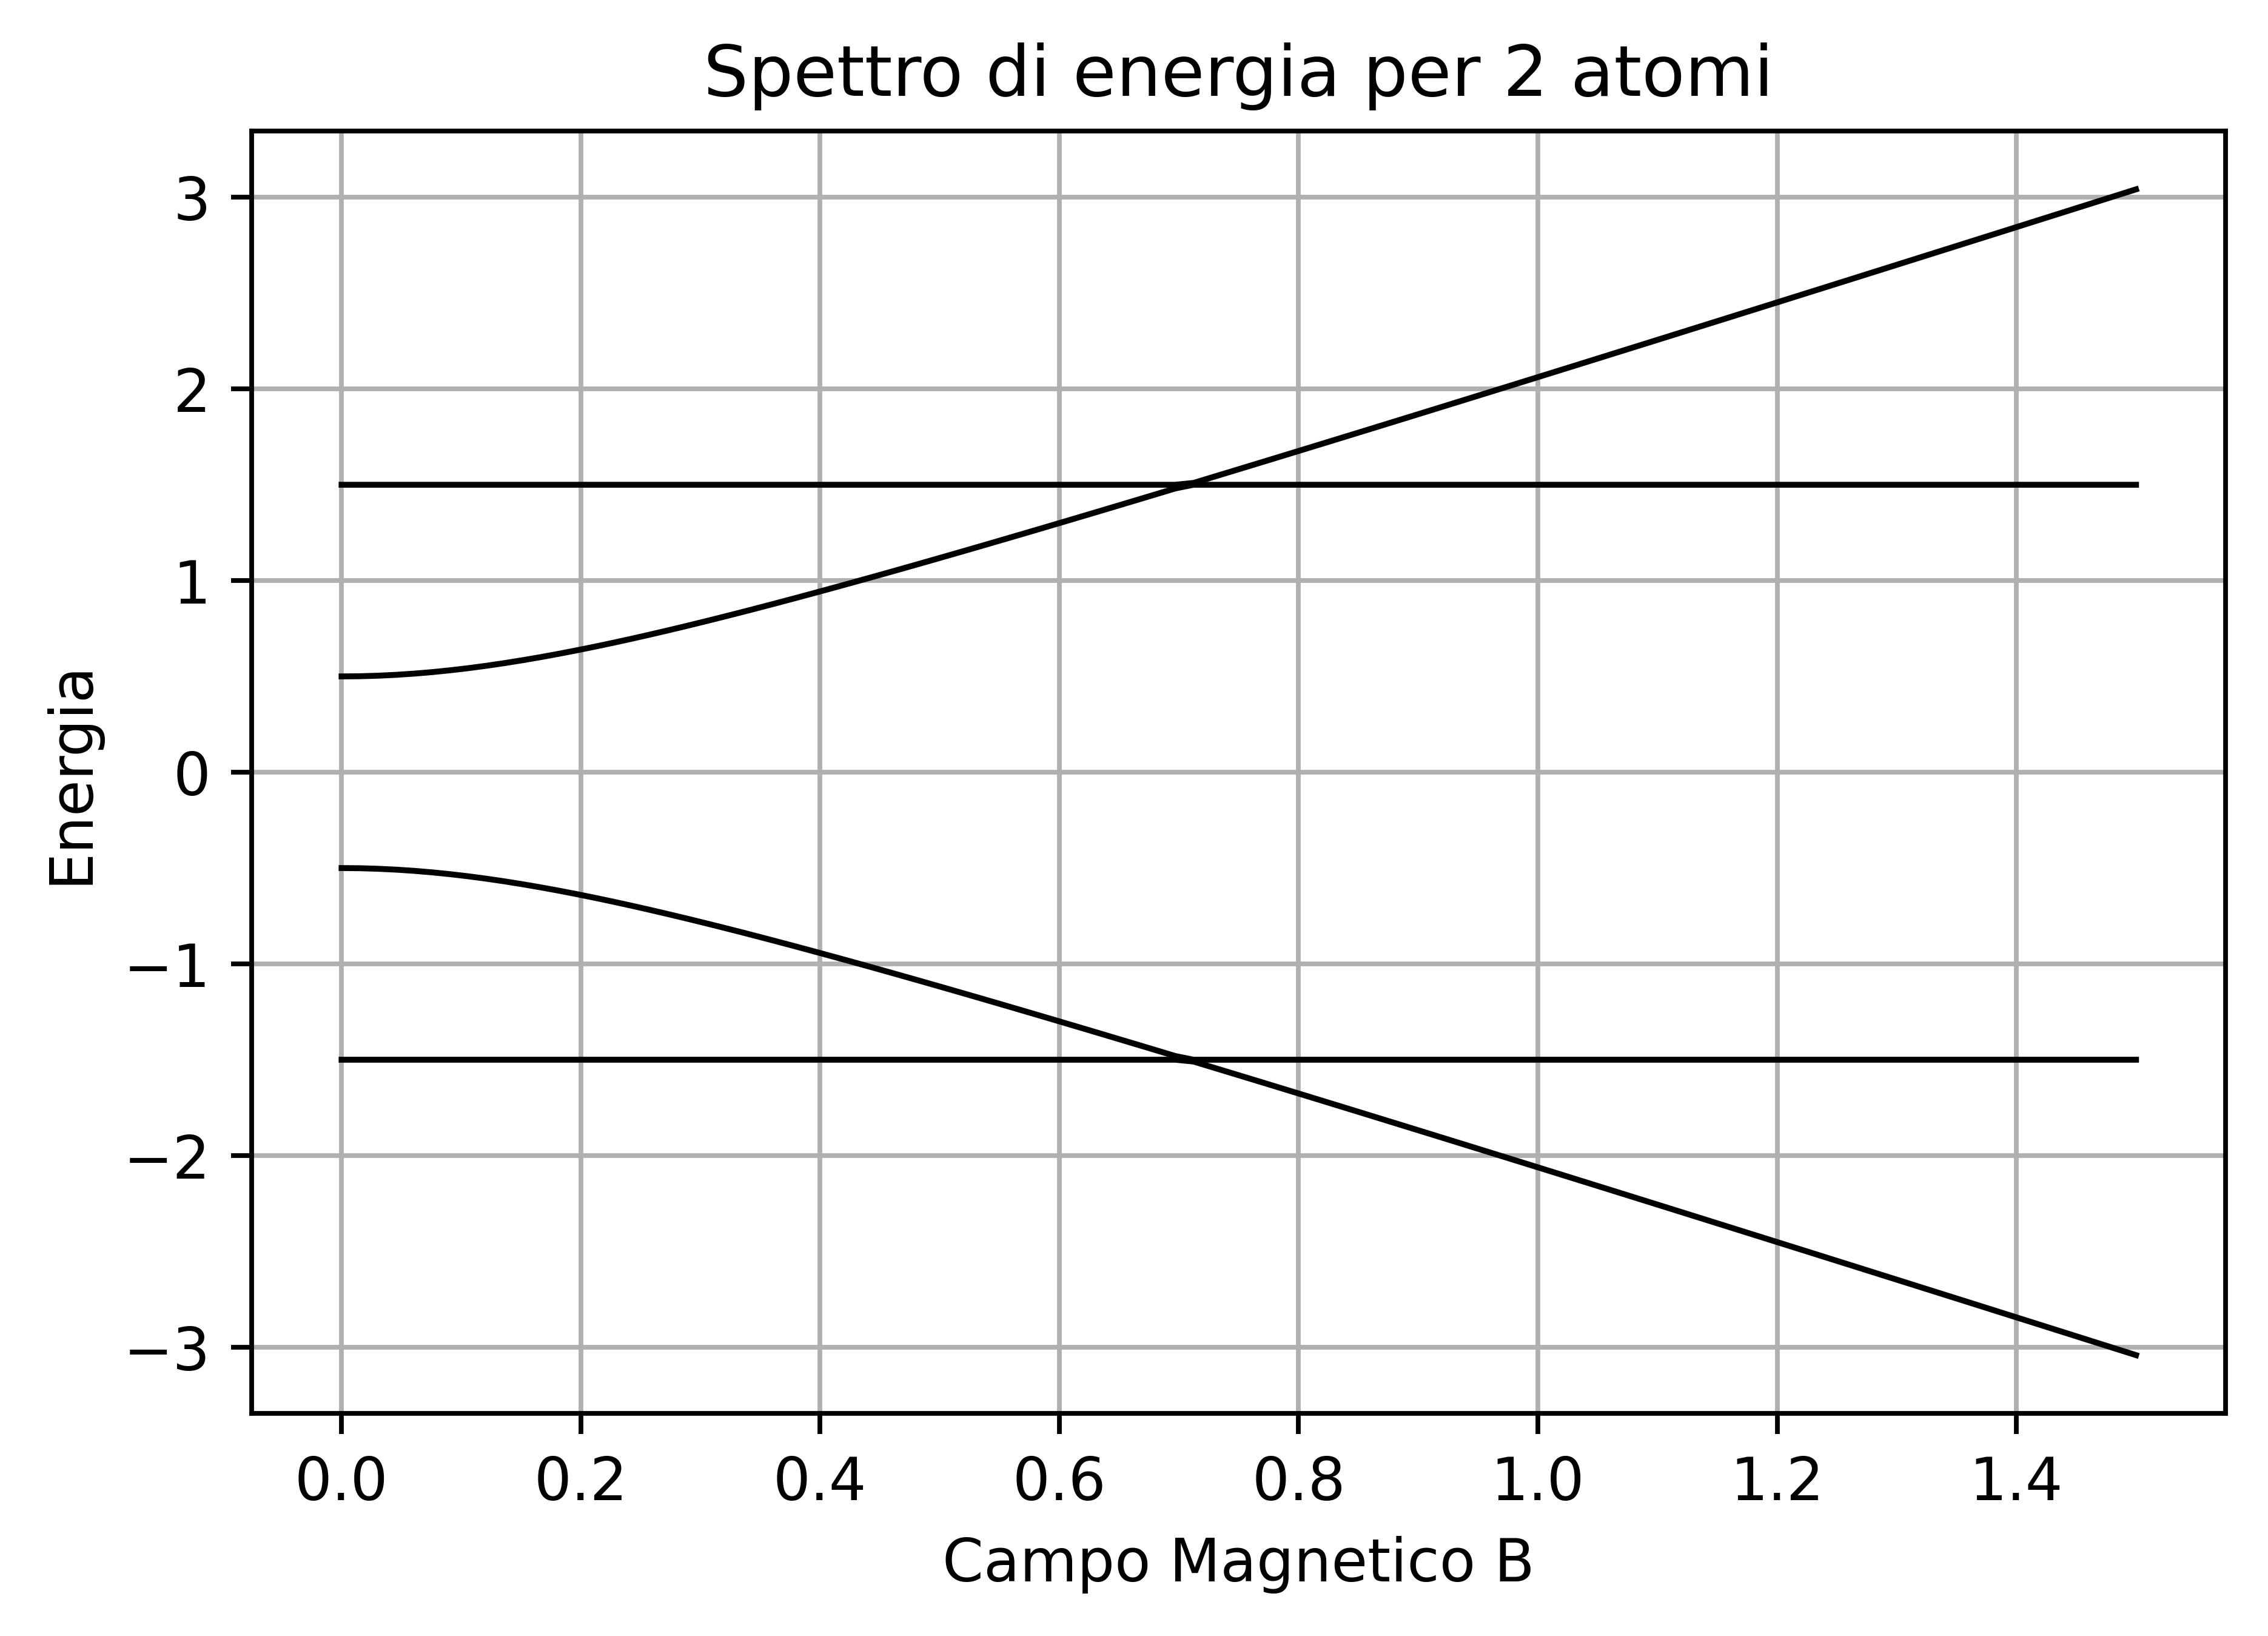

In [20]:
spectrum_class(0.,1.5,100,Natoms,J,gy,gz)

### Diagonalizzazione quantistica con il VQE locale

#### Costruzione di $\hat H$ per la diagonalizzazione quantistica
Costruiamo la lista delle hamiltoniane sui diversi valori di $B$, usando operatori del tipo `primitive_ops.PauliOp` che è l'unico tipo che l'algoritmo VQE accetta:

In [21]:
def Spin_Magnet_Hamilton_quant(Natoms,J,gy,gz,B):
    
    #initialize 0-dimensional Operators
    init = primitive_ops.PauliOp(Pauli('I'*Natoms),0)
    field,spins = [init]*2
    
    #cycle over all qubits
    for i in range(Natoms):
    
        #Adds the spin field interaction for each atom
        field -= primitive_ops.PauliOp(Pauli('I'*i+'Z'+'I'*(Natoms-i-1)),B)
        
        #implementation for the i-th qubit
        #of spin-spin interactions with j-th qubit, with j<i
        for j in range(i):
            spins -= primitive_ops.PauliOp(Pauli('I'*j+'X'+'I'*(i-j-1)+'X'+'I'*(Natoms-i-1)),J)
            spins -= primitive_ops.PauliOp(Pauli('I'*j+'Y'+'I'*(i-j-1)+'Y'+'I'*(Natoms-i-1)),J*gy)

    return (field+spins)

In [22]:
qH = []
for k in range(len(B)):
    qH.append(Spin_Magnet_Hamilton_quant(Natoms,J,gy,gz,B[k]))

#### Definizione dell'ansatz

Prendiamo l'ansatz `EfficientSU2` ecc., impostandone i parametri secondo la definizione che abbiamo dato al nostro problema.

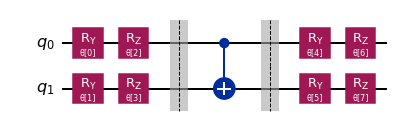

In [23]:
from qiskit.circuit.library import EfficientSU2

# the rotation gates are chosen randomly, so we set a seed for reproducibility
ansatz = EfficientSU2(Natoms, reps=1, entanglement='linear', insert_barriers=True) 
ansatz.decompose().draw('mpl', style='iqx')

#### Scelta dell'ottimizzatore

Usiamo l'ottimizzatore COBYLA:

In [24]:
optimizer = COBYLA(maxiter=50)

np.random.seed(10)  # seed for reproducibility
initial_point = np.random.random(ansatz.num_parameters)

#### Simulazione locale della VQE

Costruiamo la funzione per il VQE con ansatz, ottimizzatore, stato iniziale, "quantum instance" e funzione di callback scelti e facciamo eseguire il VQE con i parametri scelti:

In [25]:
from qiskit.providers.basicaer import StatevectorSimulatorPy, QasmSimulatorPy

local_vqe = VQE(ansatz=ansatz,
                optimizer=optimizer,
                initial_point=initial_point,
                quantum_instance=StatevectorSimulatorPy(),
                callback=callback)

qGSEigE, qGSstat, meanerr = VQE_par_H_diagonalizer(local_vqe,qH)

'Finito.'

### Risultati

Visualizzo stime delle energie dei GS e stime degli errori:

In [26]:
print('Eigenvalues:','Mean error:')
for i in range(len(qGSEigE)):
    print(qGSEigE[i],meanerr[i])

Eigenvalues: Mean error:
-1.1313906948296064 0.0
-1.4720159589048771 0.0
-1.5623512752587396 0.0
-2.3044666025634912 0.0
-3.028266781527084 0.0


Visualizzo il grafico con i risultati classici e della VQE:

In [27]:
qGSEigE

[-1.1313906948296064,
 -1.4720159589048771,
 -1.5623512752587396,
 -2.3044666025634912,
 -3.028266781527084]

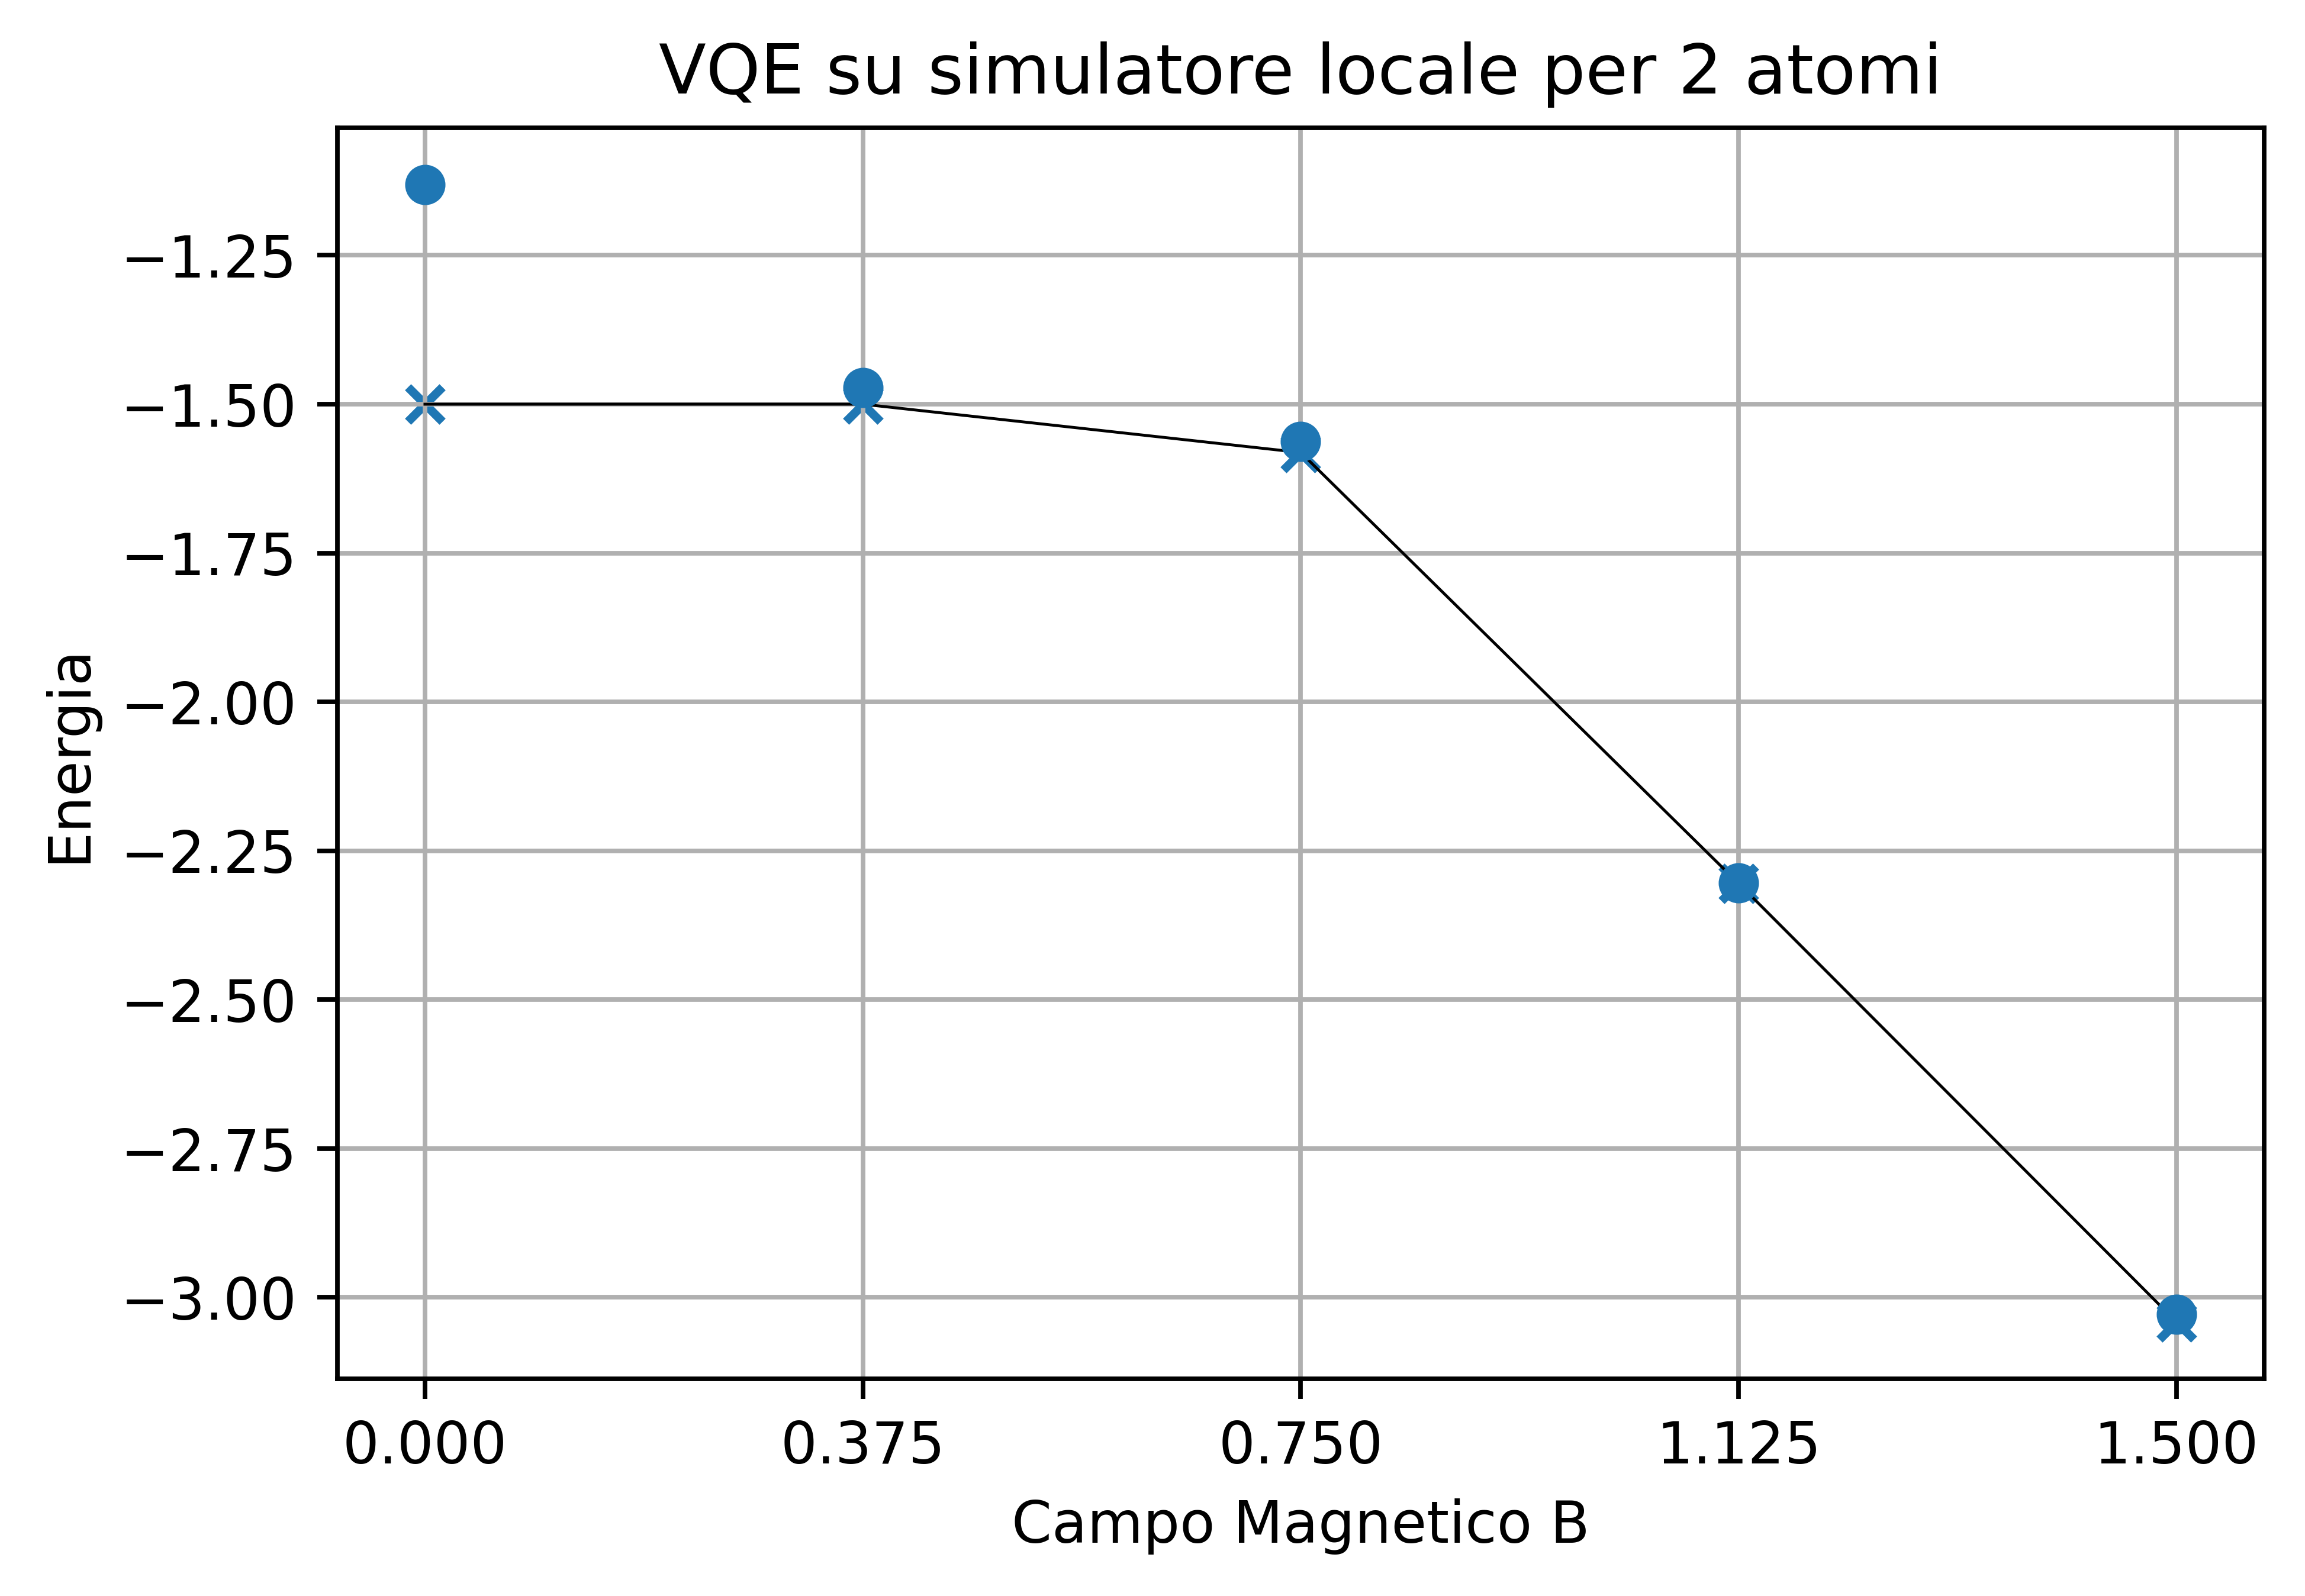

In [28]:
cGSEigE, EigE = class_par_H_diagonalizer(cH)
plot_qGS(Bmin,Bmax,100,Neval,Natoms,J,gy,gz,qGSEigE,meanerr)

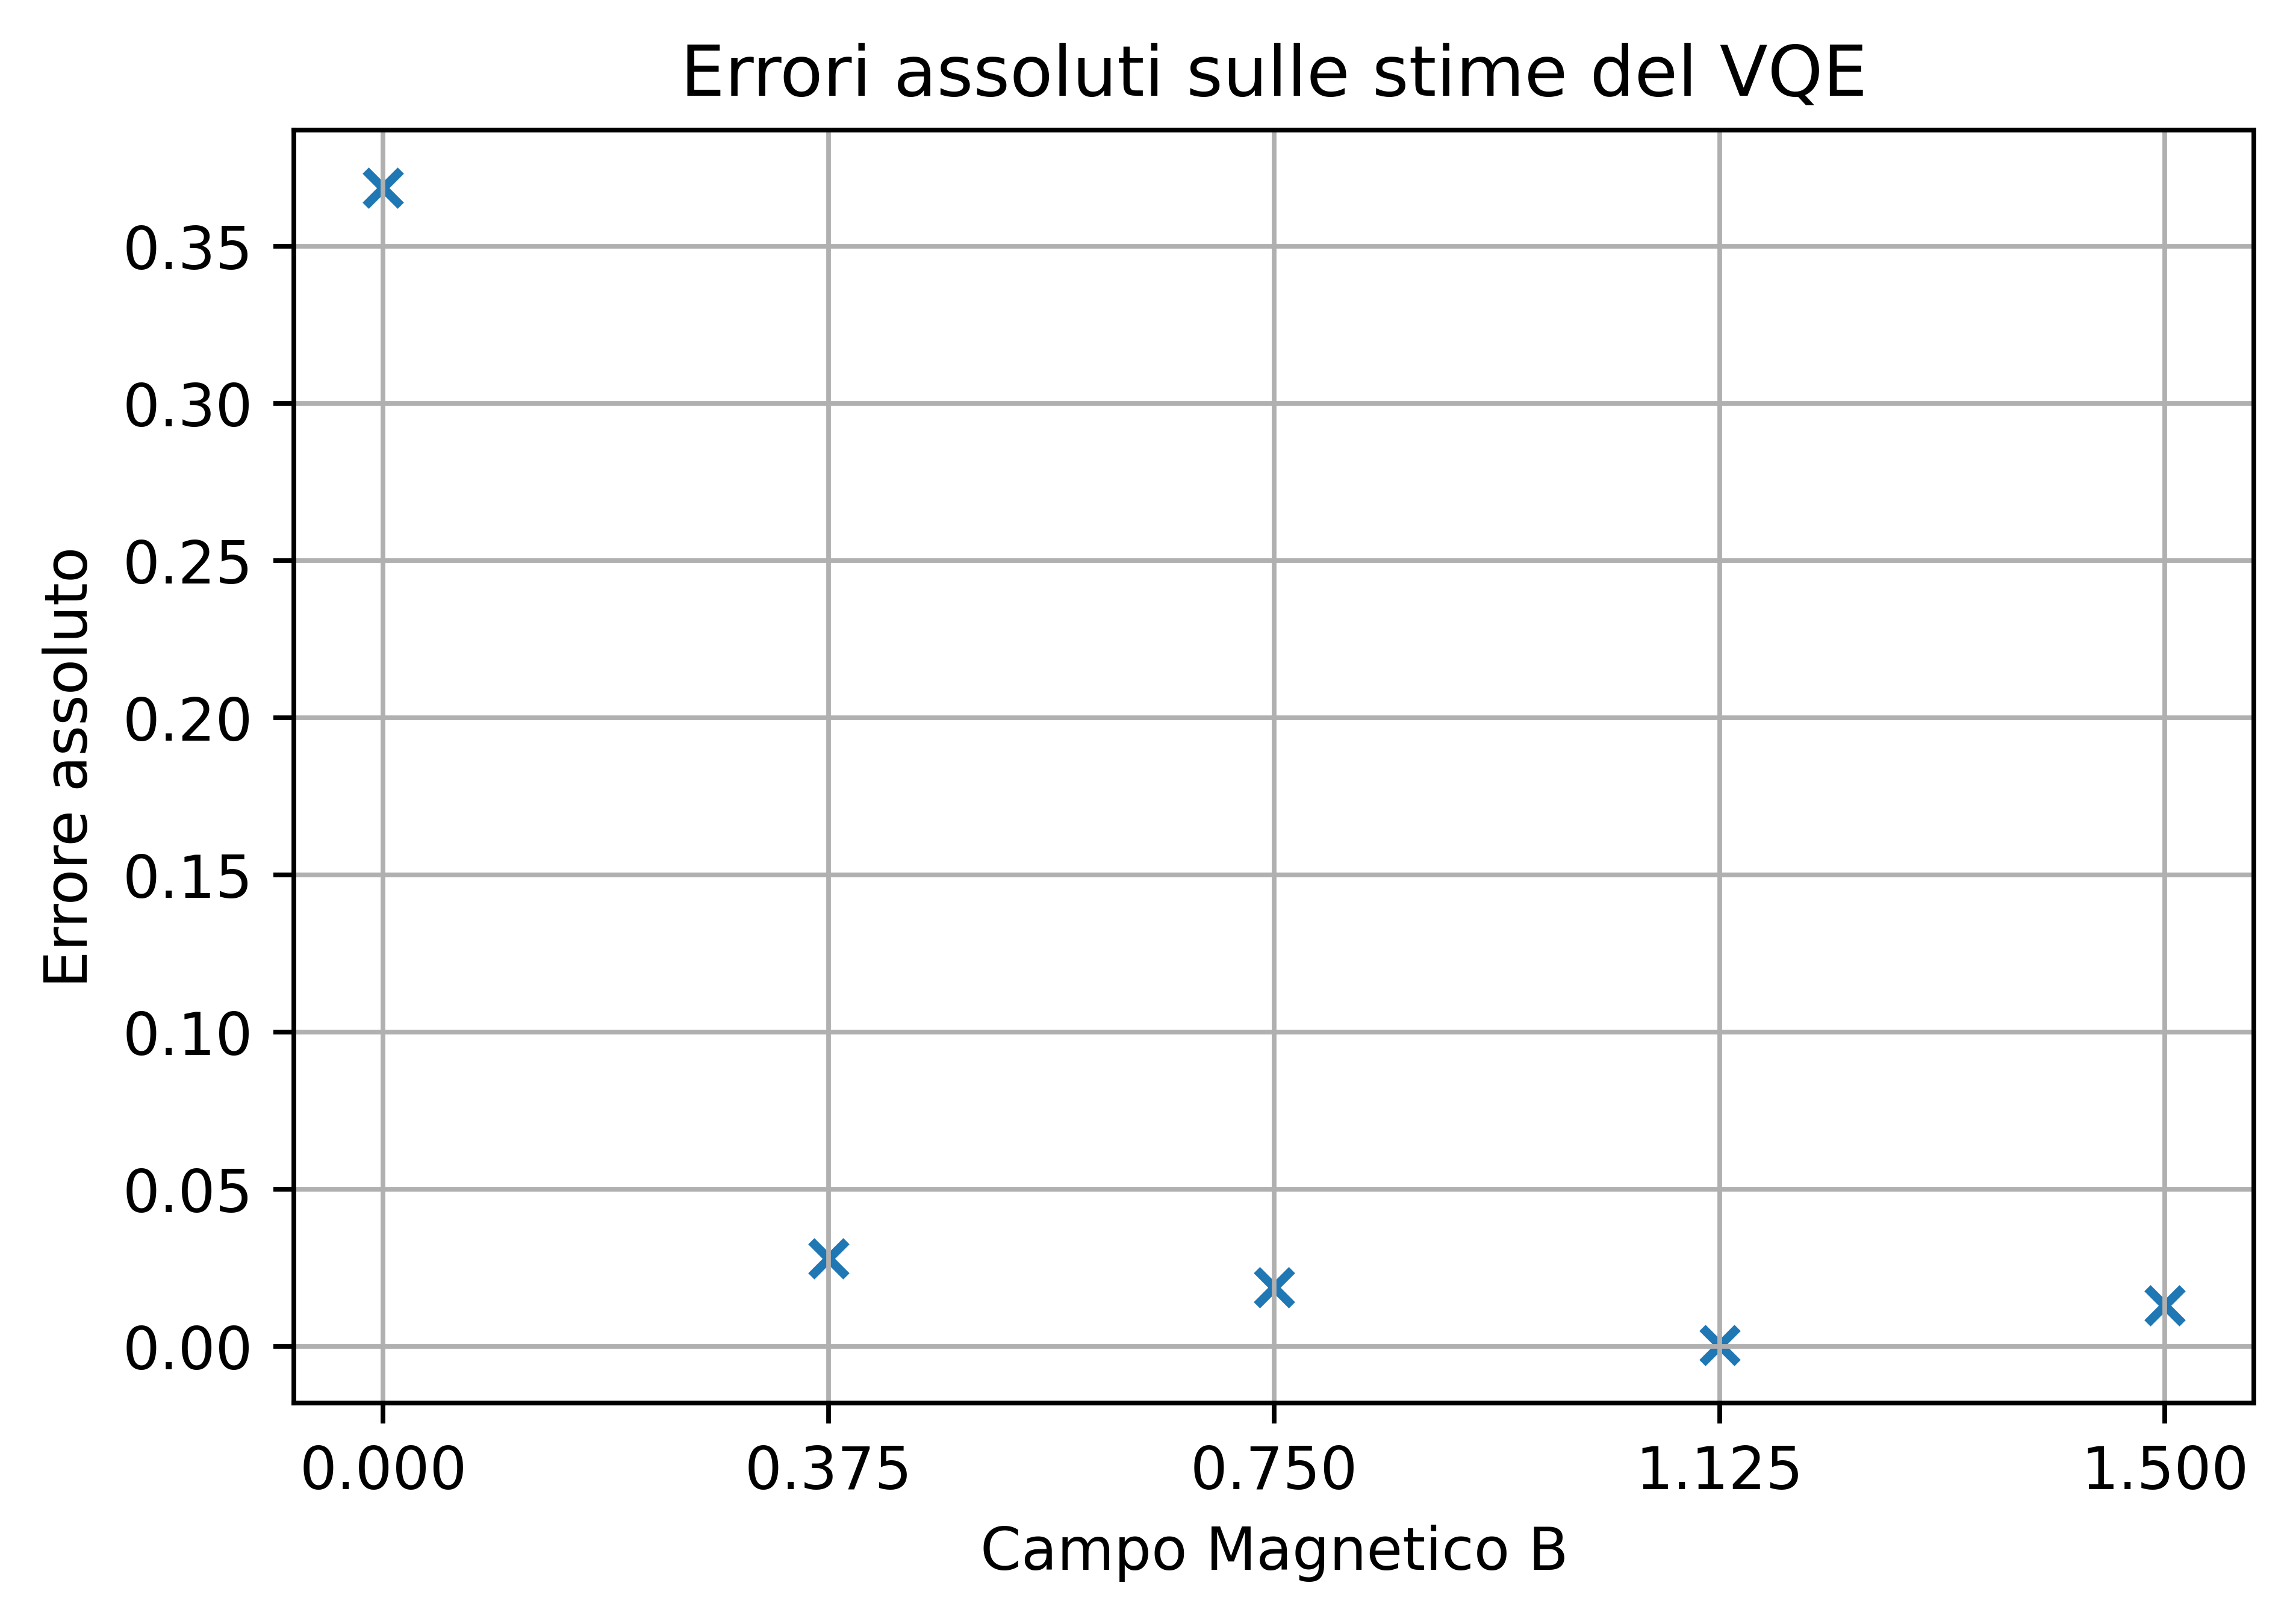

In [29]:
plot_abserr(B,GS1,qGSEigE)

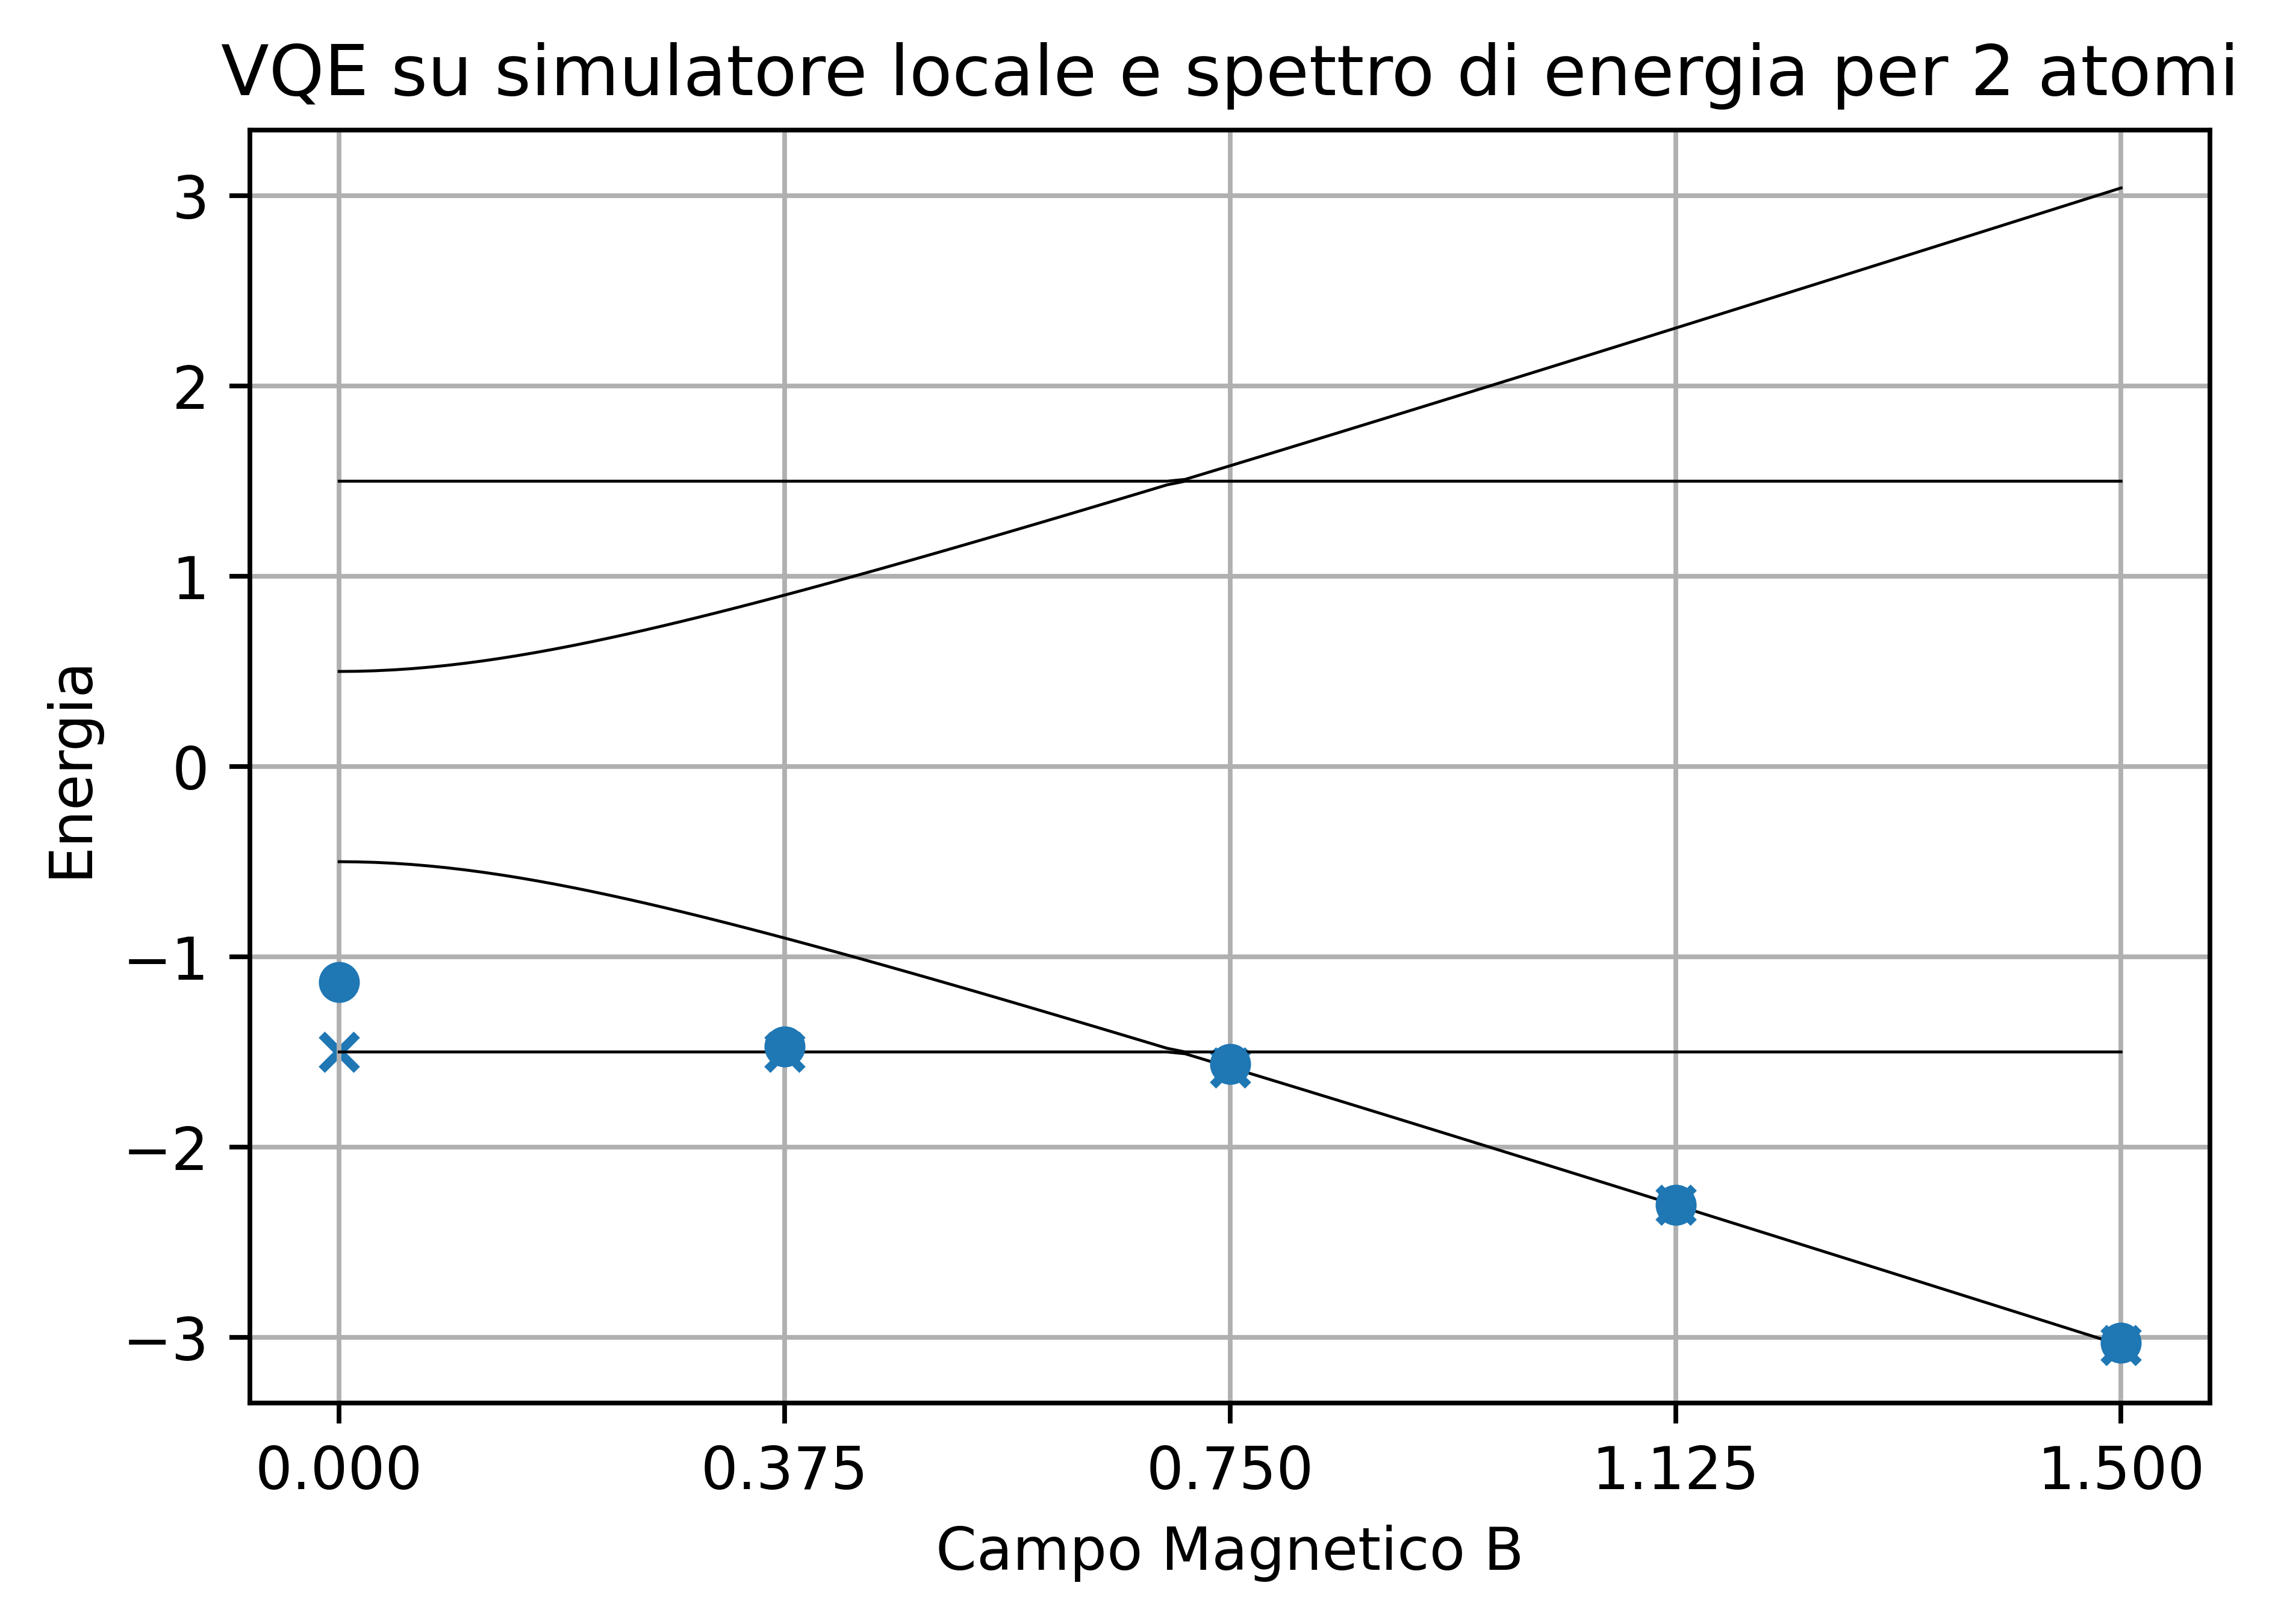

In [30]:
plot_qGS_spectrum(Bmin,Bmax,100,Neval,Natoms,J,gy,gz,qGSEigE,meanerr)

<IPython.core.display.Latex object>

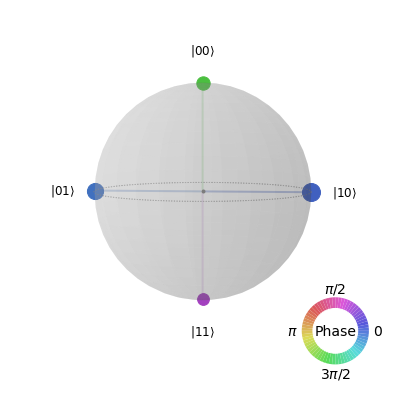

<IPython.core.display.Latex object>

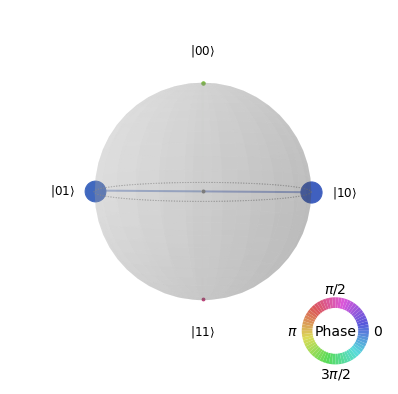

<IPython.core.display.Latex object>

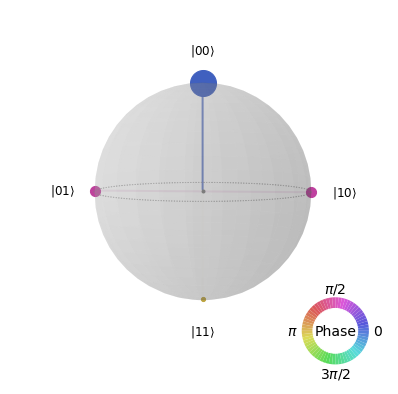

<IPython.core.display.Latex object>

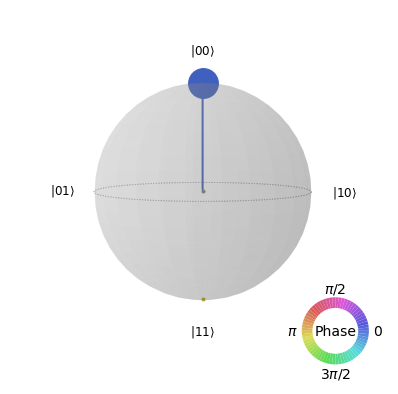

<IPython.core.display.Latex object>

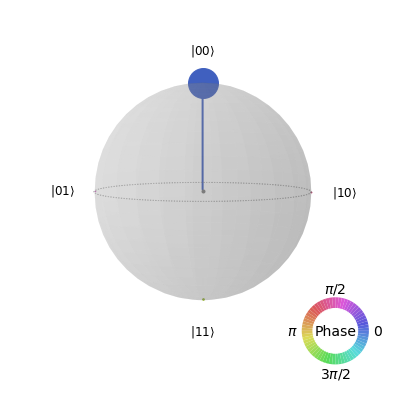

In [31]:
states = [[np.round(abs(j)**2,2)for j in i]for i in qGSstat]
states = [Statevector(entry) for entry in states]
for i in range(len(states)):
    display(array_to_latex(states[i], prefix="B={}:\qquad\\left|\\psi_0\\right>\\ \\to\\ ".format(round(B[i],3))))#Statevector(qGSstat[i])
    display(plot_state_qsphere(qGSstat[i]))

### Hardware/Simulator VQE

#### Preparazione

Costruisco la quantum instance e chiamo il VQE con i parametri immessi dall'utente relativamente a:
- strumentazione: hardware, simulatore con/senza rumore;
- numero di _shots_;
- ottimizzatore: SPSA, COBYLA:

In [32]:
shots = 512

optimizer = SPSA(maxiter=300) #, tol=0.001, rhobeg=1.0) per COBYLA

measurement_error_mitigation = True

qGSEigE1, meanerr1 = Custom_VQE_diag("noisy",shots,optimizer)

'Finito.'

#### Risultati

In [33]:
print('Eigenvalues:','Mean error:')
for i in range(len(qGSEigE1)):
    print(qGSEigE1[i],meanerr1[i])

Eigenvalues: Mean error:
-1.5 0.0
-1.47265625 0.0157082248586186
-1.6201171875 0.05234366957814885
-2.26953125 0.053402378520071105
-3.0019531249999996 0.05185266117175182


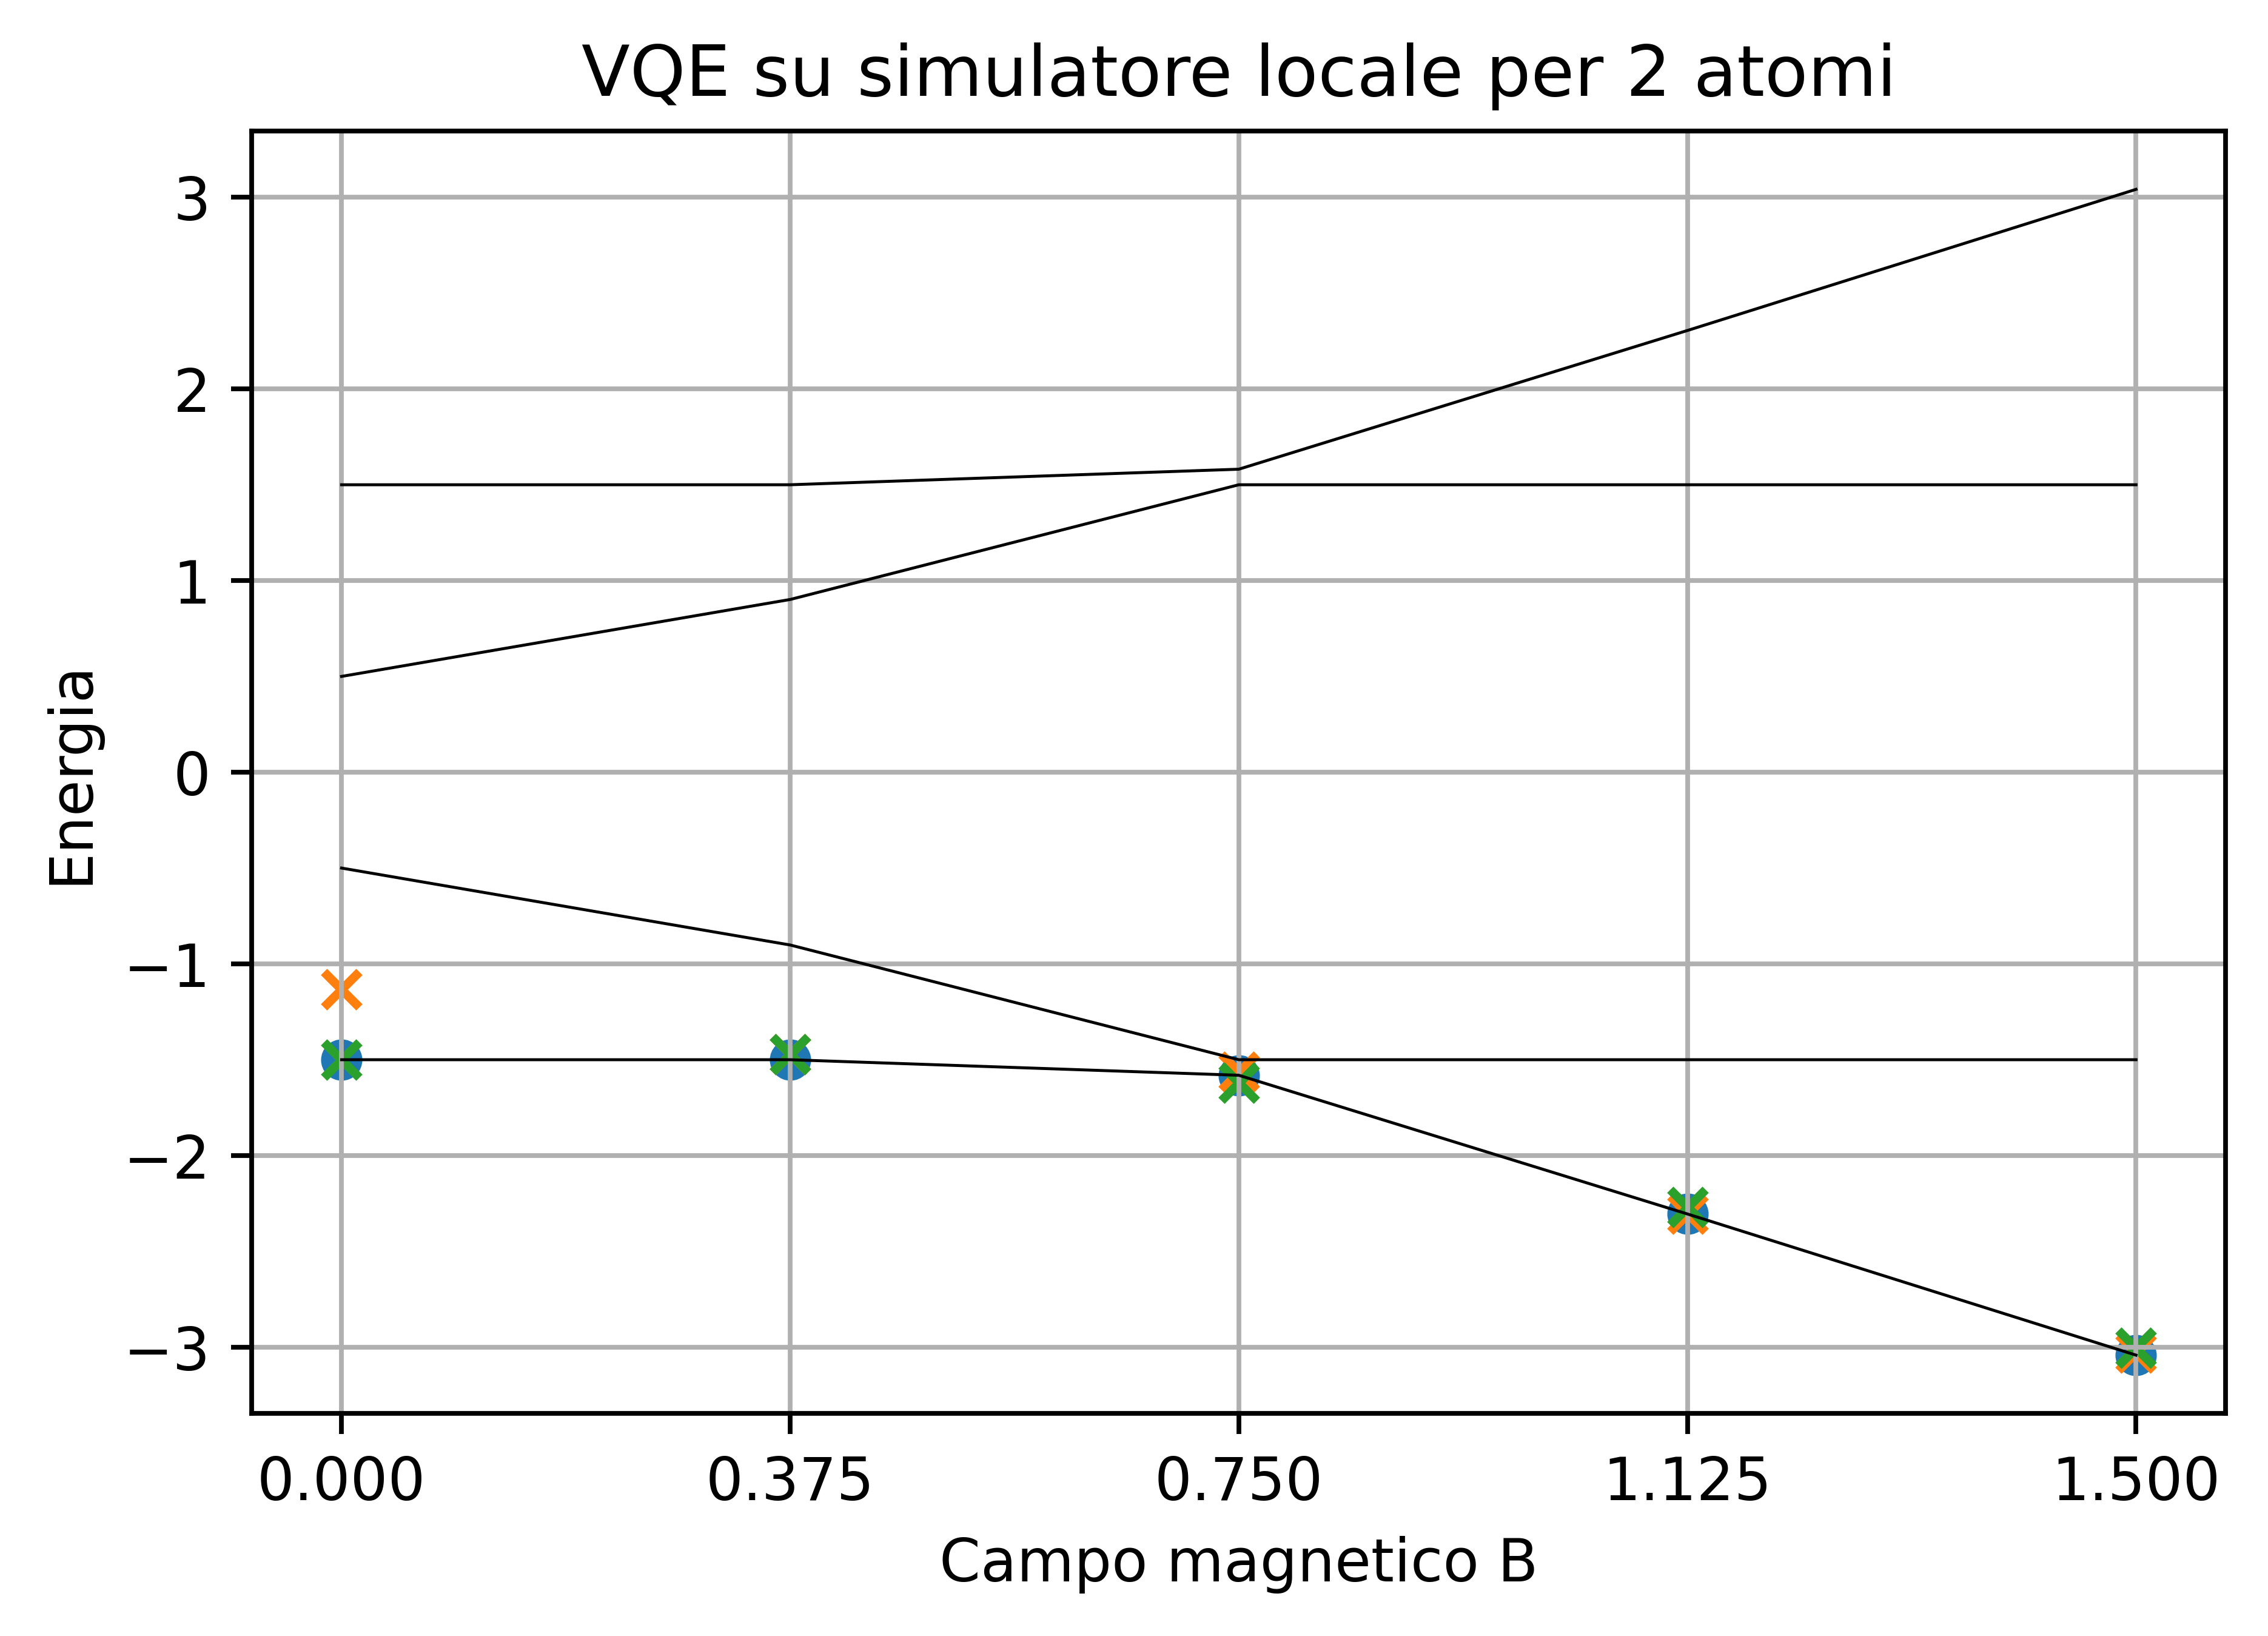

In [34]:
plot_tot([cGSEigE, EigE, qGSEigE, qGSEigE1],Natoms)

### Caso con 3 atomi

### Soluzione analitica

La hamiltoniana può essere divisa in due parti:
- $\hat H_1 = - \sum_{\substack{i,j=1\\i<j}}^n J\left( \hat \sigma_x^{(i)}\hat \sigma_x^{(j)} + \gamma\hat \sigma_y^{(i)}\hat \sigma_y^{(j)}\right)$, che mescola le quaterne $\left|000\right>$, $\left|110\right>$, $\left|101\right>$, $\left|011\right>$ e  $\left|111\right>$, $\left|001\right>$, $\left|010\right>$, $\left|100\right>$ della base computazionale;
- $\hat H_2 = - B \sum_{i=1}^n \hat\sigma_z^{(i)}$, di cui tutti gli stati della base computazionale sono autostati.

Allora basta studiare come si mescolano le due quaterne, questa volta, individuate da $\hat H_1$ e si trovano gli autovalori di $\hat H$:
- $E=-(\pm B+J(1+\gamma))\pm2\sqrt{J^2(1+\gamma^2-\gamma)^2+B^2\pm BJ(1+\gamma)}$;
- $E=\pm B + J(1+\gamma)$.

A questo punto, per i diversi valori di $J$ e $B$ basta vedere quale dei valori di $E$ è il minimo, ma non l'abbiamo fatto a mano perché dipende anche dal segno dei due parametri. Sicuramente si può escludere sempre $E=-(\pm B+J(1+\gamma))+2\sqrt{J^2(1+\gamma^2-\gamma)^2+B^2\pm BJ(1+\gamma)}$, mentre gli altri autovalori possono tutti essere quelli di minimo in diverse condizioni.

In [35]:
cH = []
Natoms = 3 #Cambiamo numero atomi
J = 1./Natoms
gy = 2
gz = 0
Bmin=0
Bmax=1.5
Neval=8
B = np.linspace(Bmin,Bmax,Neval).tolist()

In [36]:
def compGS1(J,gy,gz,B):
    a = B + J * (1. + gy)
    c = sqrt( J**2 * (1+gy**2-gy) + B**2 - B*J*(1+gy) )
    energy = - a - 2*c
    return energy

def compGS2(J,gy,gz,B):
    a = - B + J * (1. + gy)
    c = sqrt( J**2 * (1+gy**2-gy) + B**2 + B*J*(1+gy) )
    energy = - a - 2*c
    return energy

In [37]:
GS1 = [min(compGS1(J,gy,gz,i),compGS2(J,gy,gz,i),i+J*(1+gy),-i+J*(1+gy)) for i in B]

### Diagonalizzazione computazionale classica

#### Algoritmo per risoluzione classica

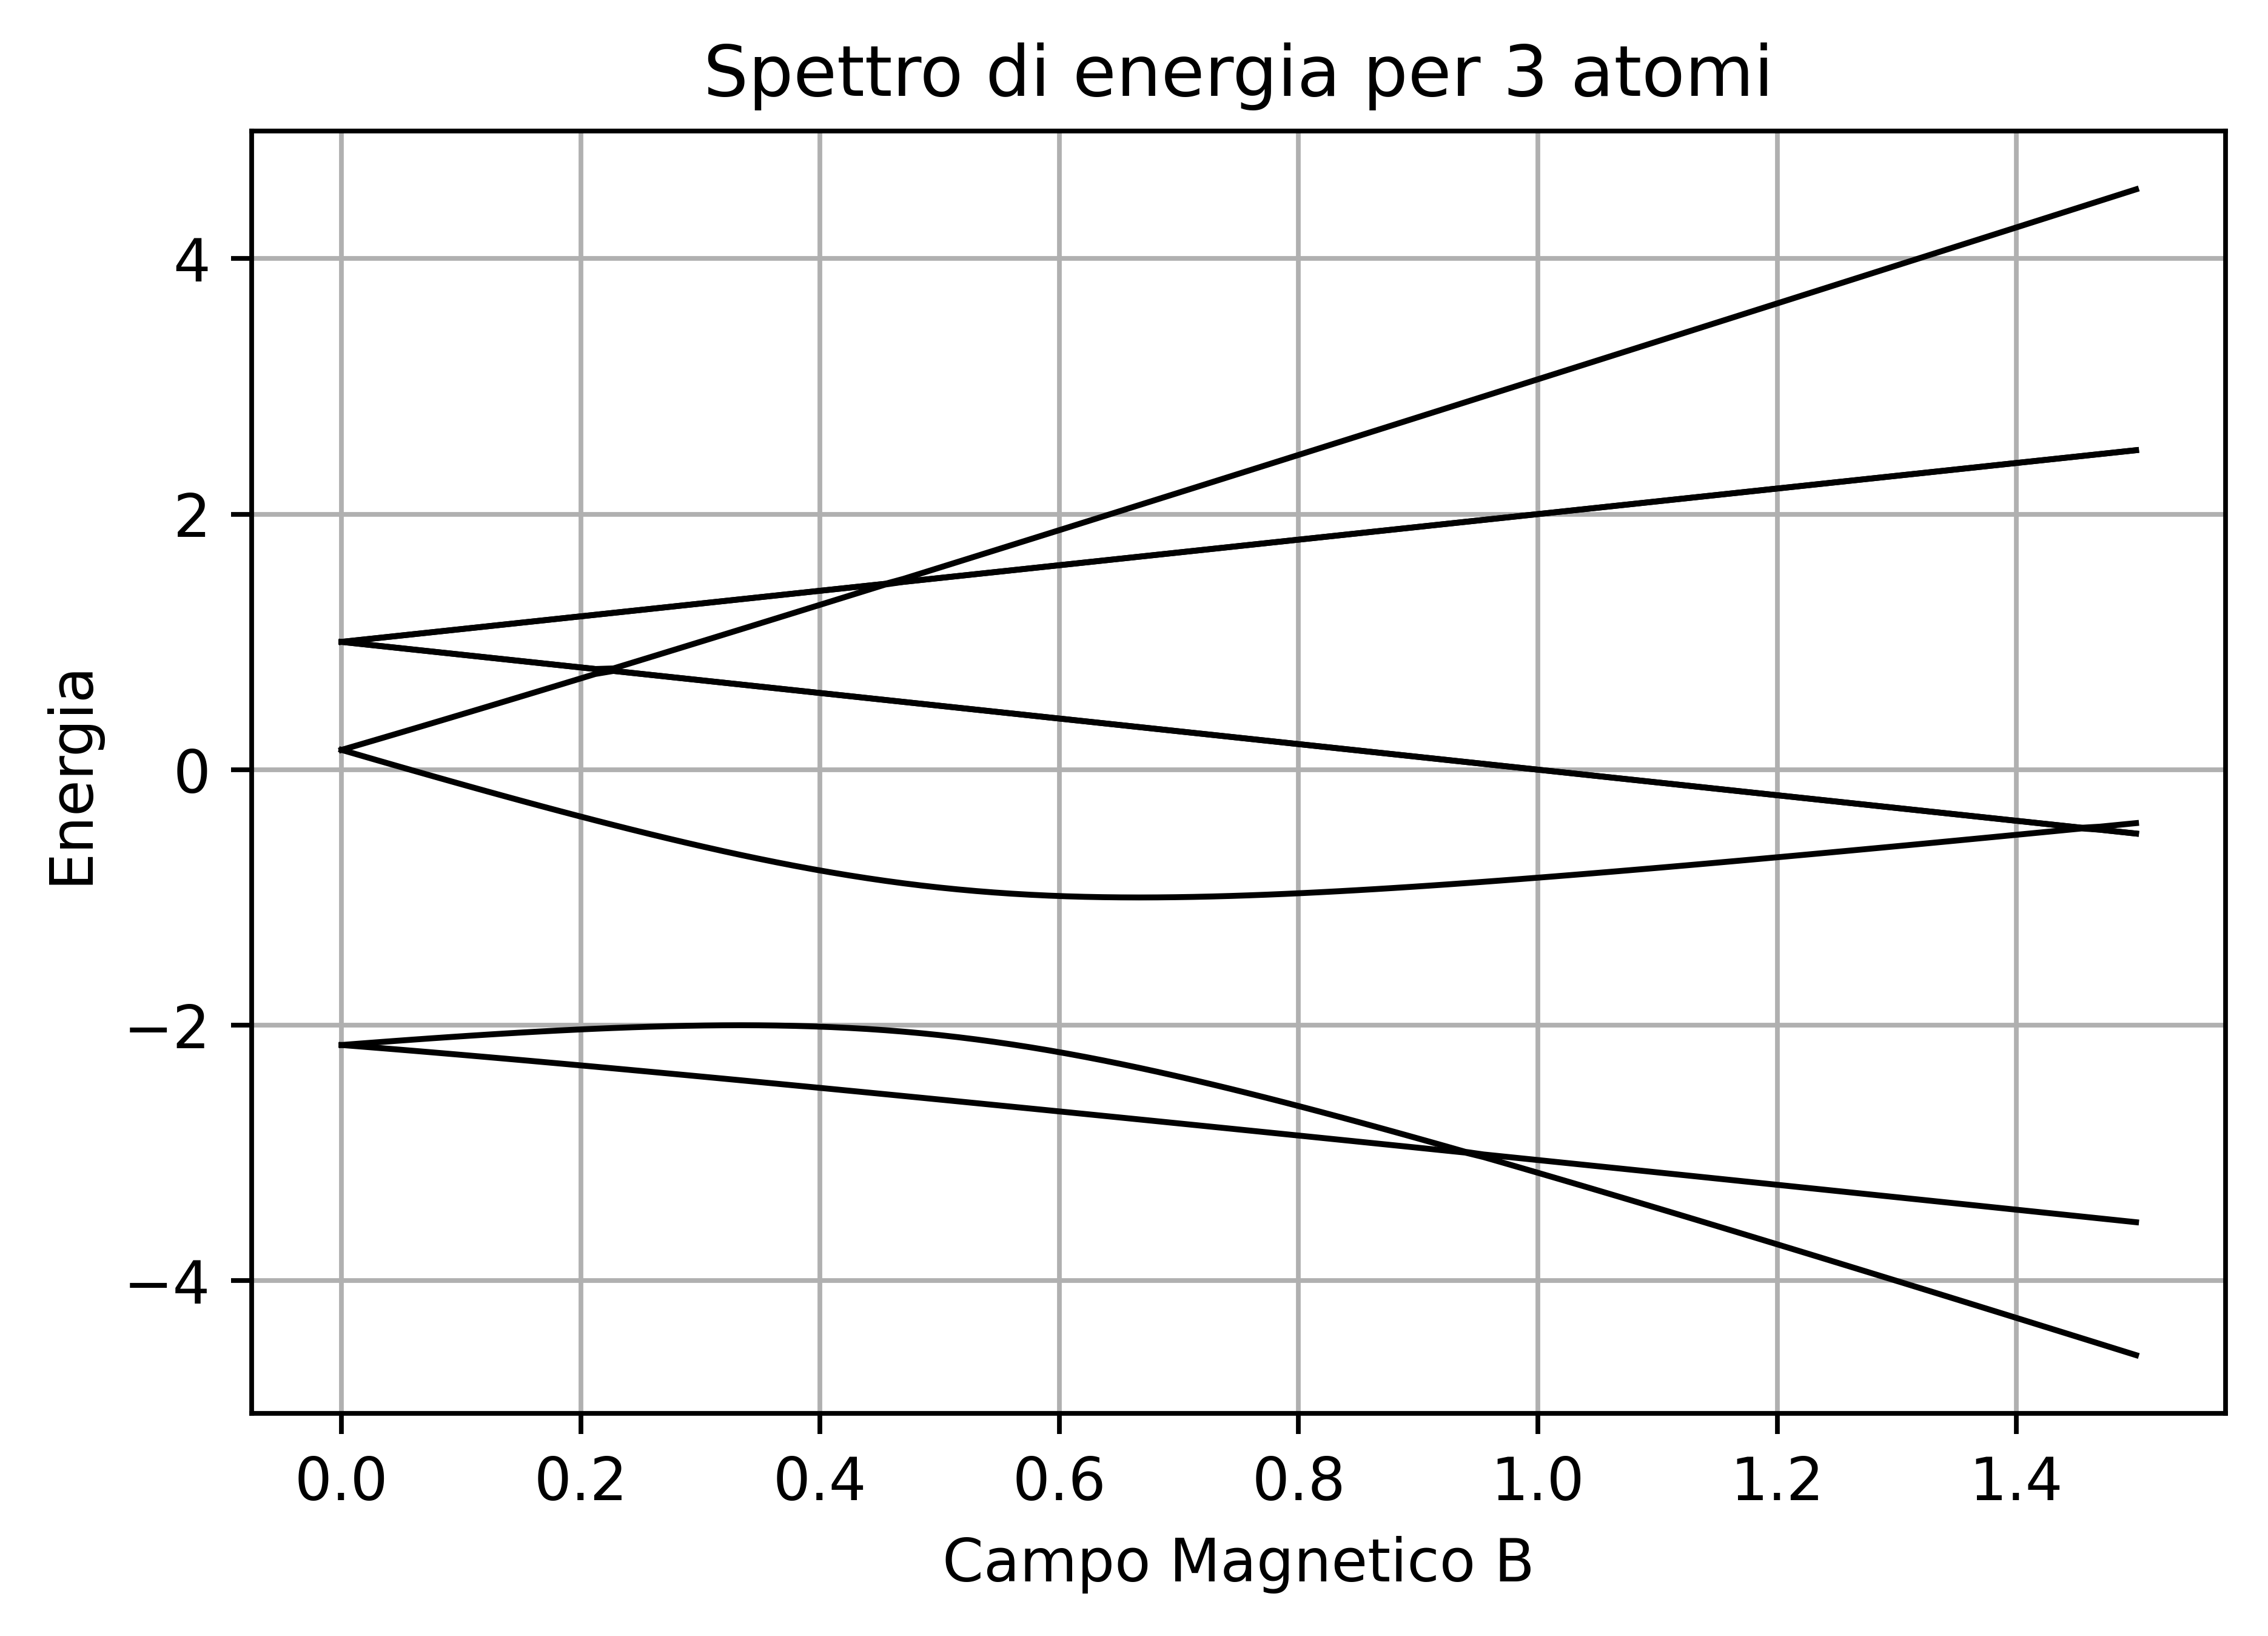

In [38]:
cH = []
for k in B:
    cH.append(Spin_Magnet_Hamilton_class(Natoms,J,gy,gz,k))
    
cGSEigE, EigE = class_par_H_diagonalizer(cH)
spectrum_class(0.,1.5,100,Natoms,J,gy,gz)

### Diagonalizzazione quantistica con il VQE locale

In [39]:
qH = []
for k in range(len(B)):
    qH.append(Spin_Magnet_Hamilton_quant(Natoms,J,gy,gz,B[k]))

#### Definizione dell'ansatz

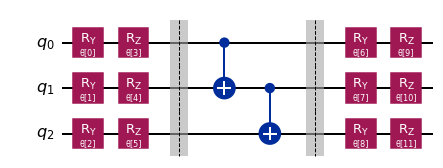

In [40]:
ansatz = EfficientSU2(Natoms, reps=1, entanglement='linear', insert_barriers=True) 
ansatz.decompose().draw('mpl', style='iqx')

#### Scelta dell'ottimizzatore

In [41]:
optimizer = COBYLA(maxiter=200)

np.random.seed(10)  # seed for reproducibility
initial_point = np.random.random(ansatz.num_parameters)

#### Simulazione locale della VQE

In [42]:
local_vqe = VQE(ansatz=ansatz,
                optimizer=optimizer,
                initial_point=initial_point,
                quantum_instance=StatevectorSimulatorPy(),
                callback=callback)

qGSEigE, qGSstat, meanerr = VQE_par_H_diagonalizer(local_vqe,qH)

'Finito.'

### Risultati

In [43]:
print('Eigenvalues:','Mean error:')
for i in range(len(qGSEigE)):
    print(qGSEigE[i],meanerr[i])

Eigenvalues: Mean error:
-2.0898608756772807 0.0
-2.12102830367441 0.0
-2.2775534158588084 0.0
-2.4728950003962726 0.0
-2.8253885578385316 0.0
-3.285383460817835 0.0
-3.881479636989411 0.0
-4.518502804687334 0.0


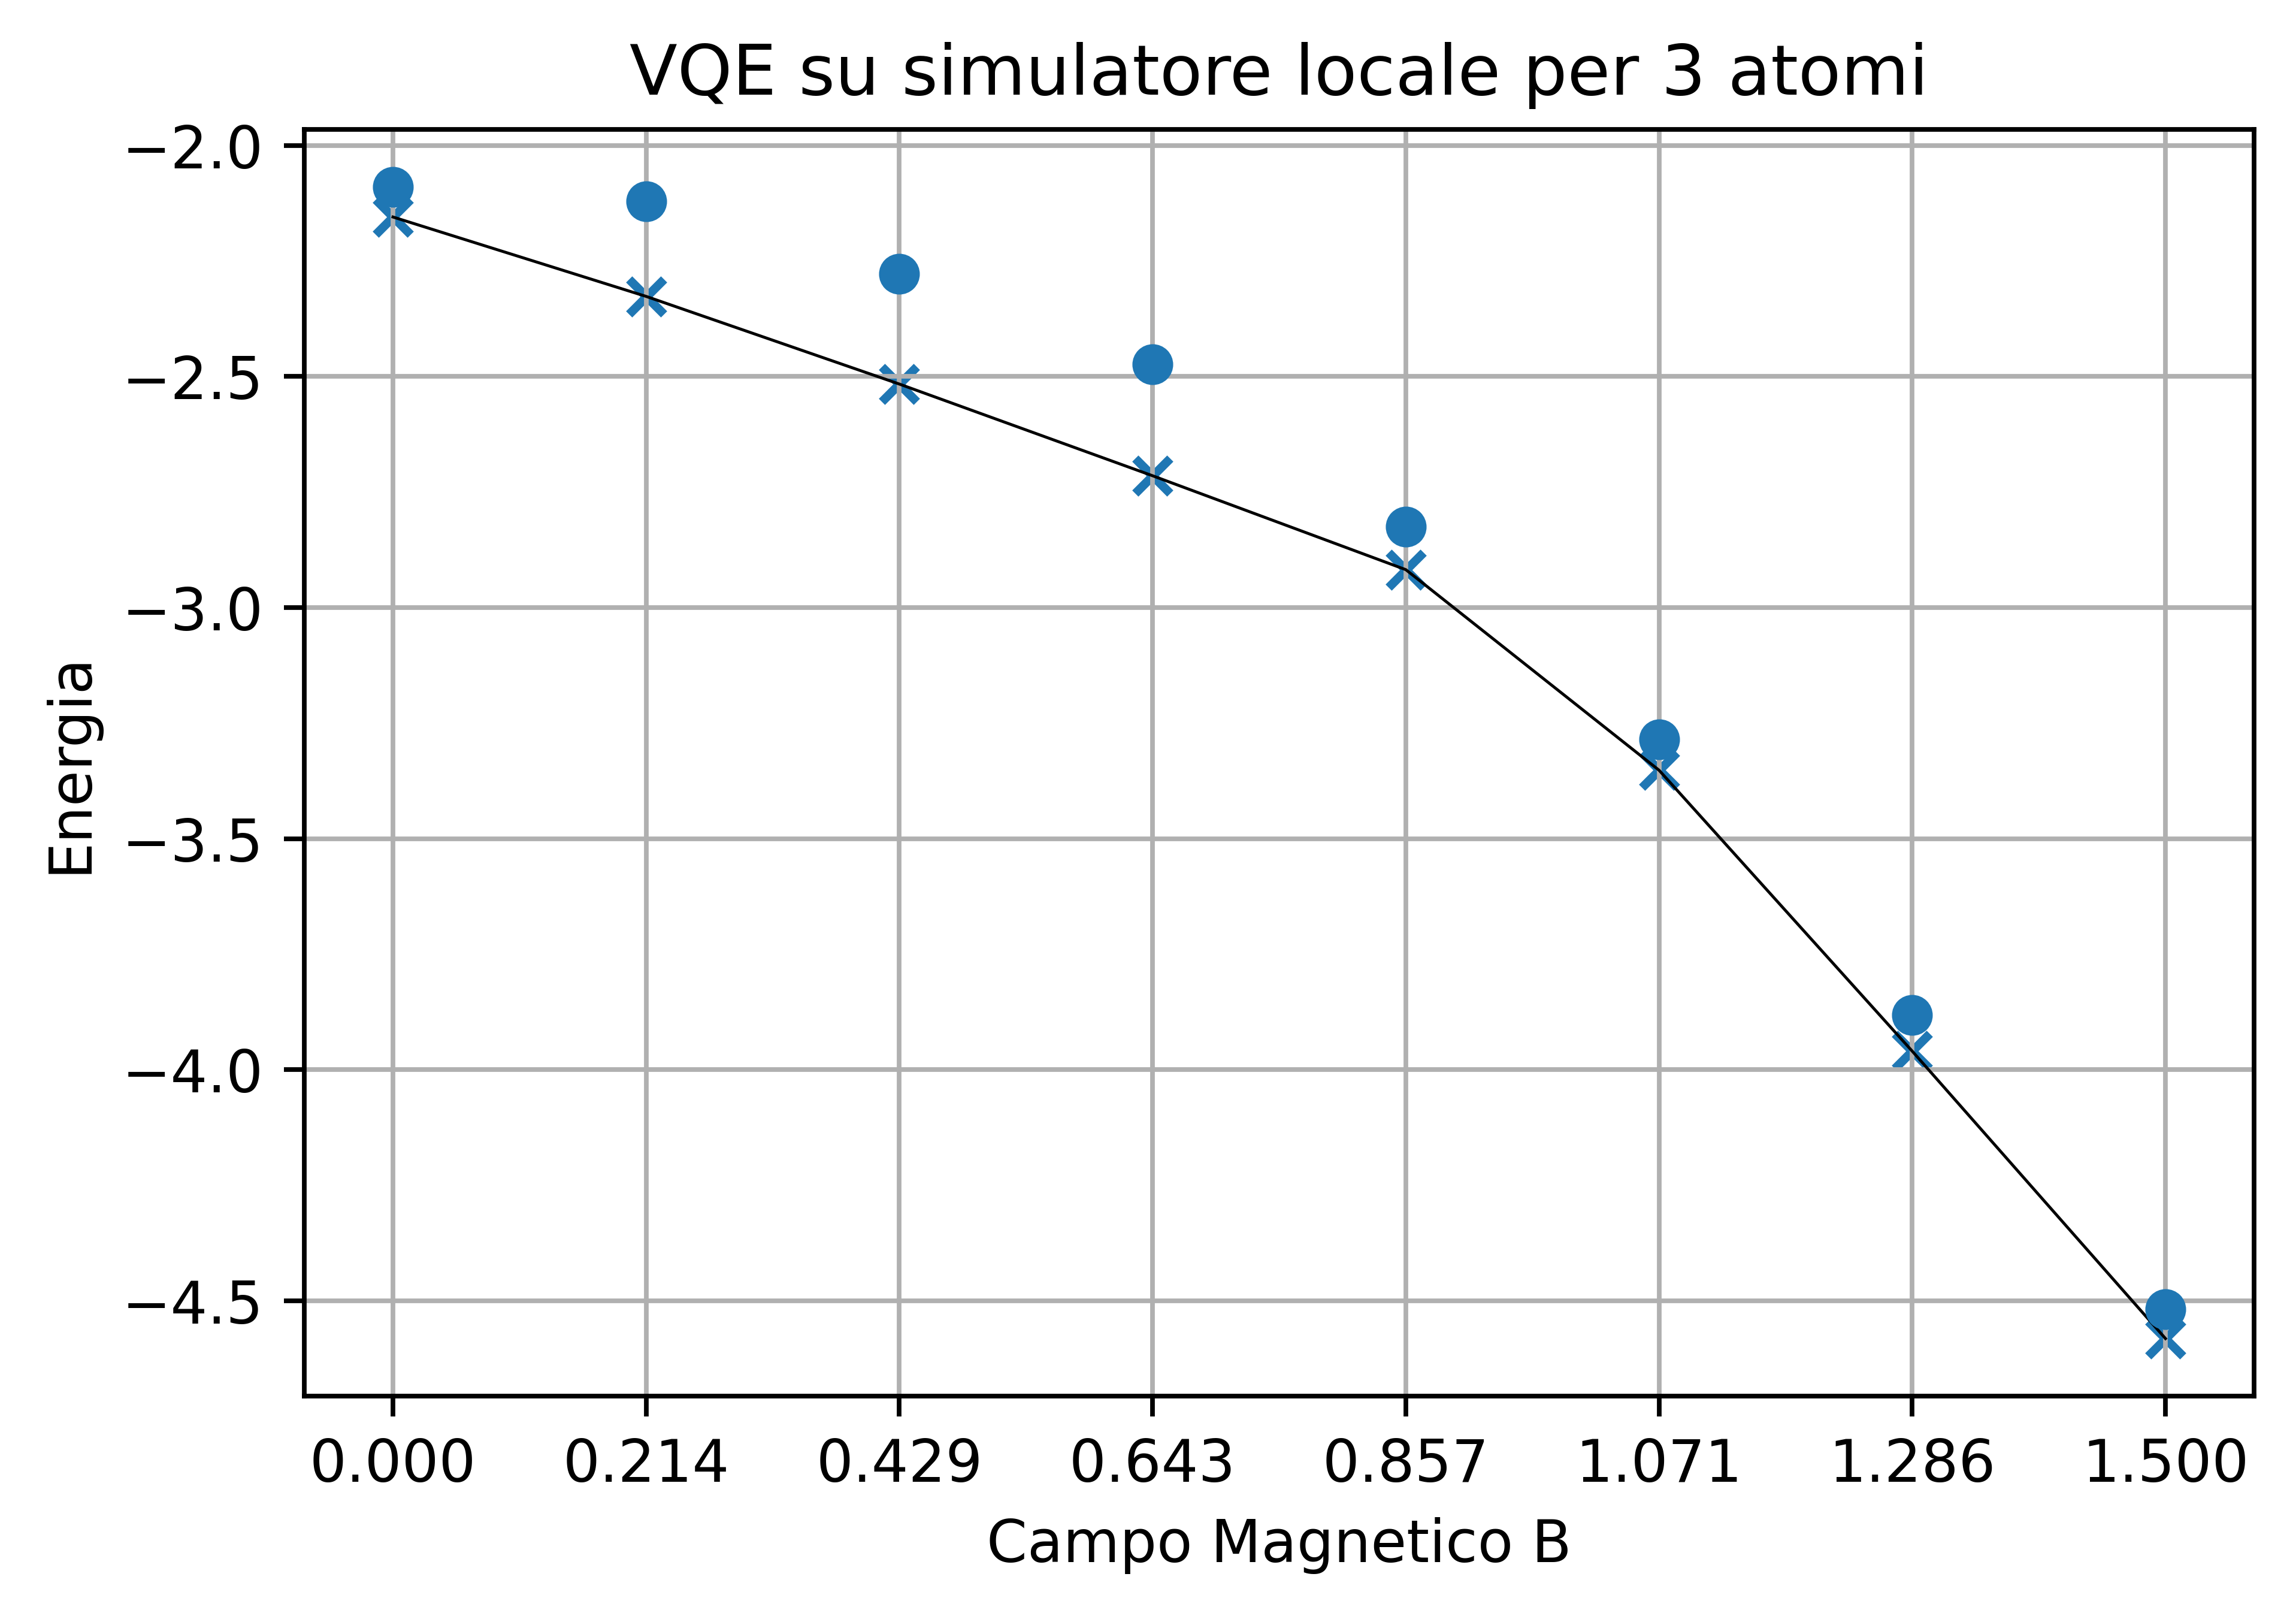

In [44]:
plot_qGS(Bmin,Bmax,100,Neval,Natoms,J,gy,gz,qGSEigE,meanerr)

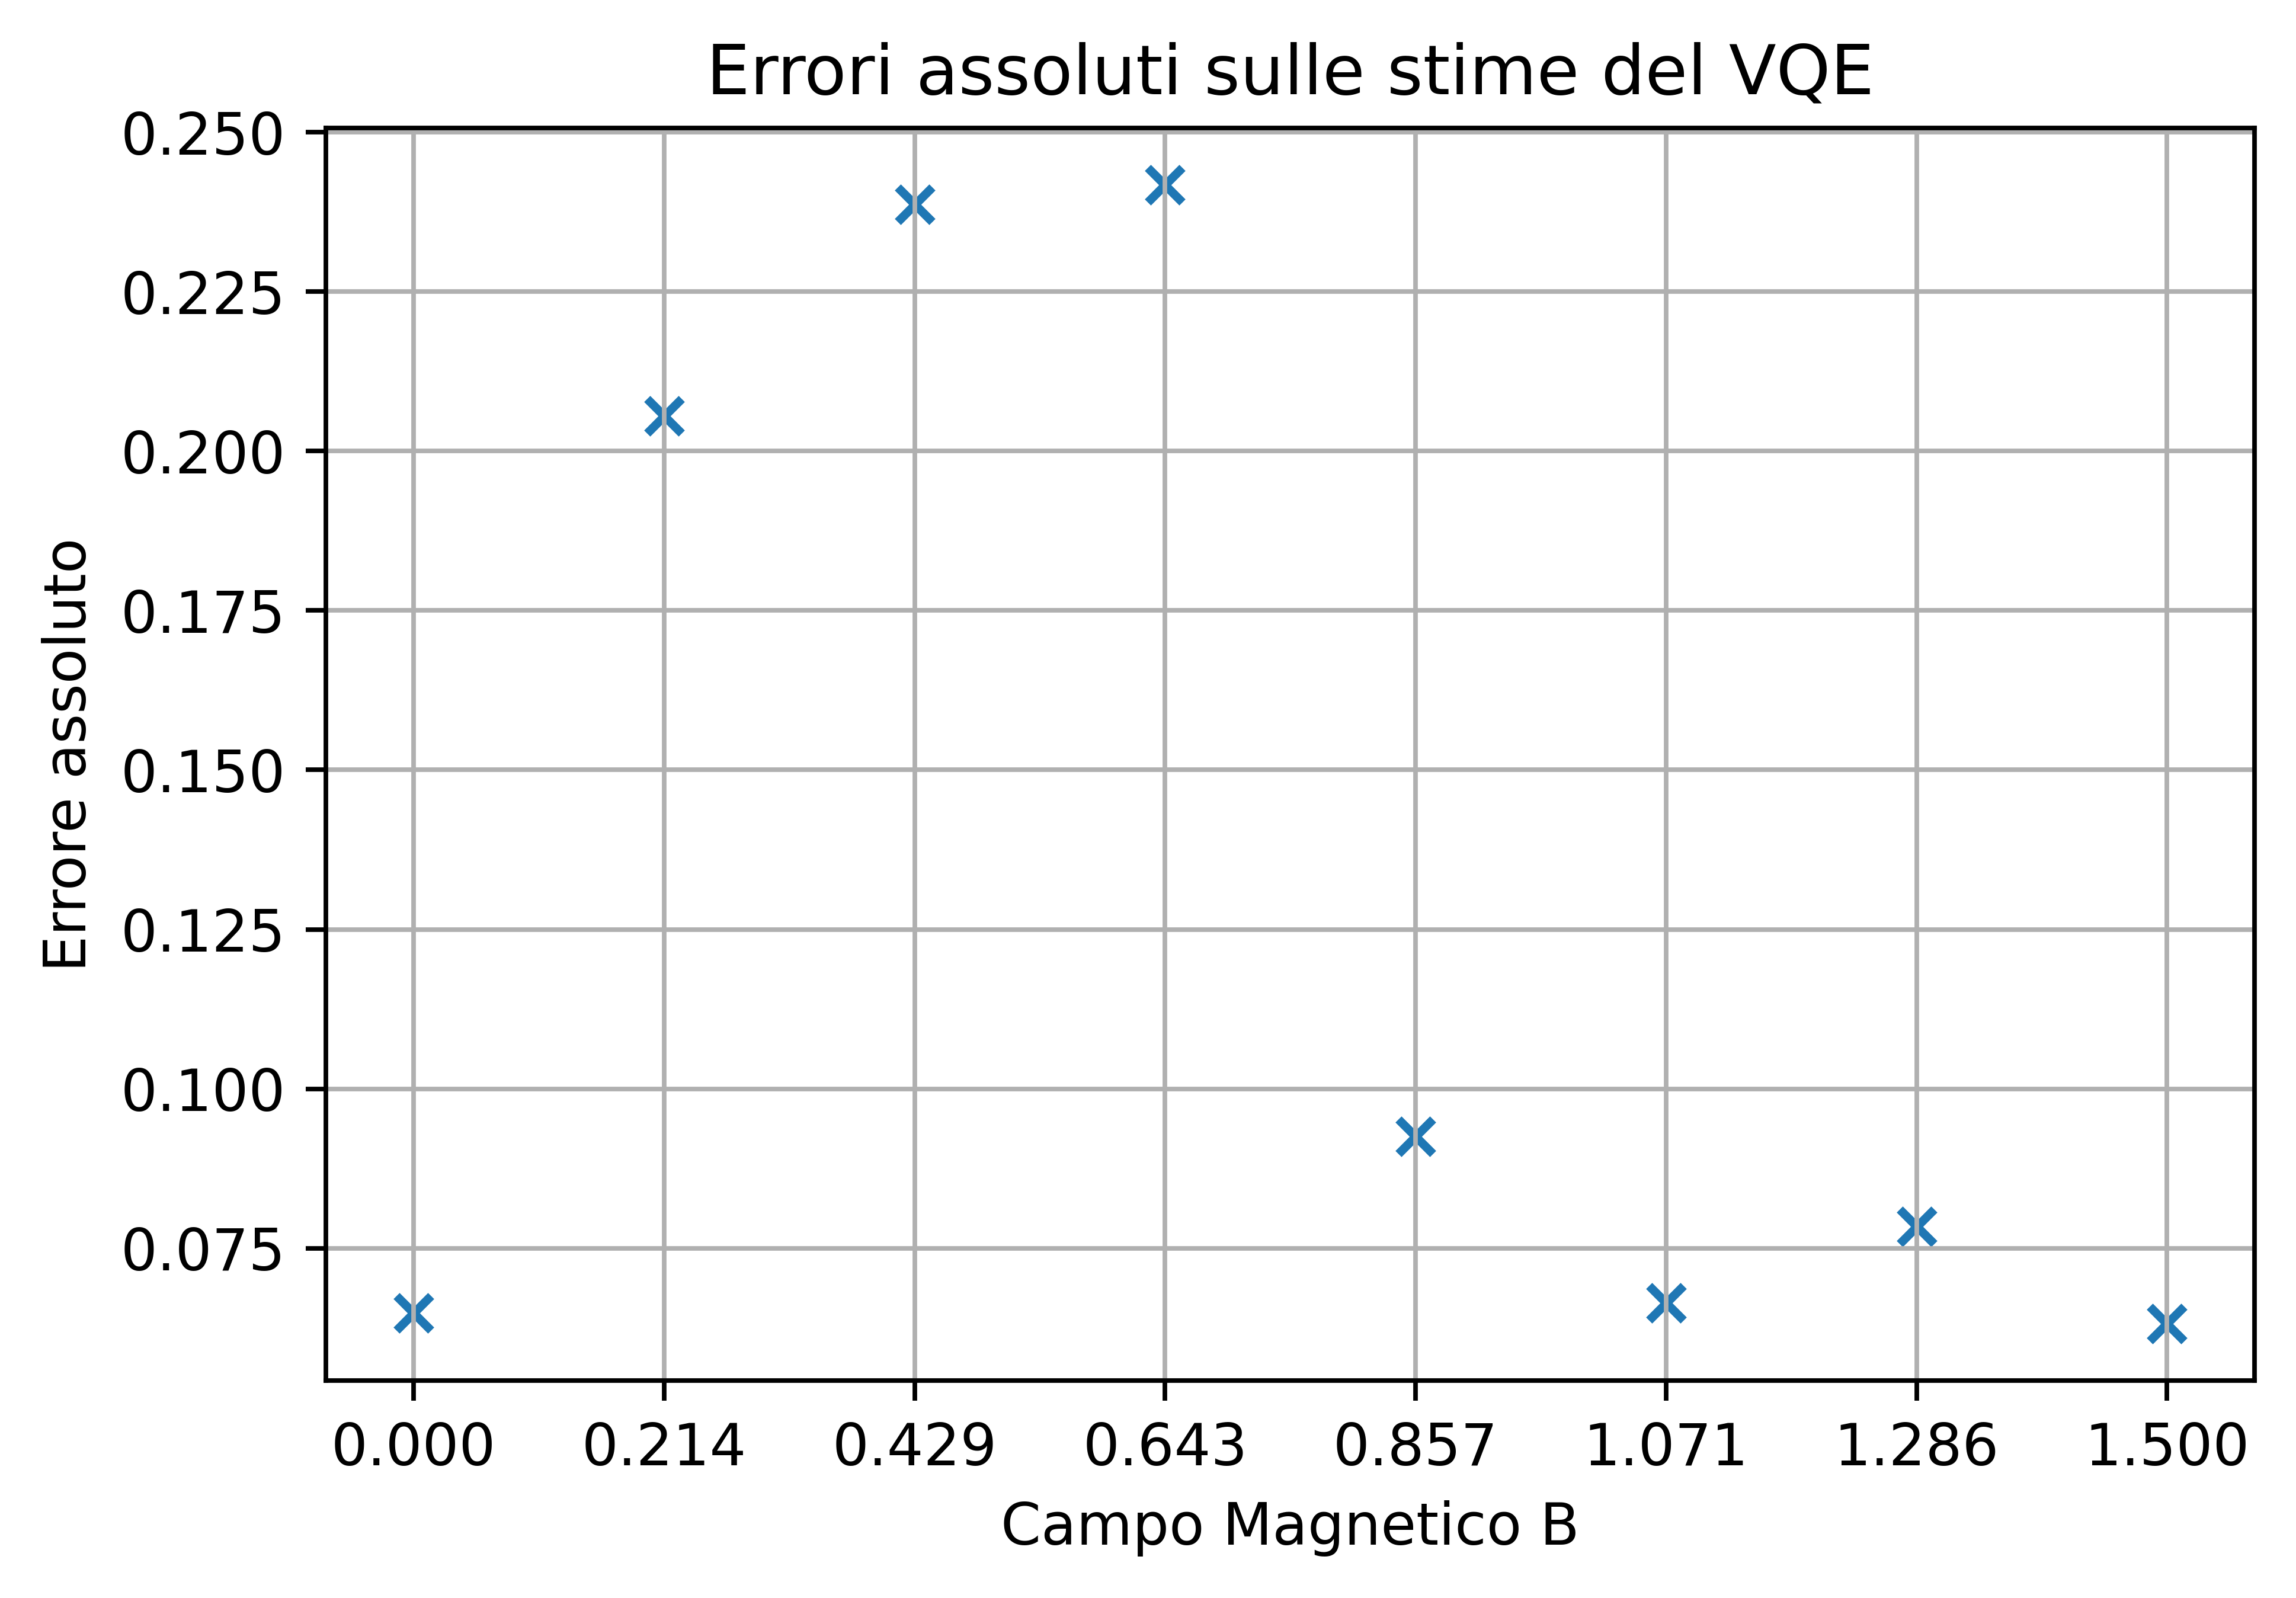

In [45]:
plot_abserr(B,GS1,qGSEigE)

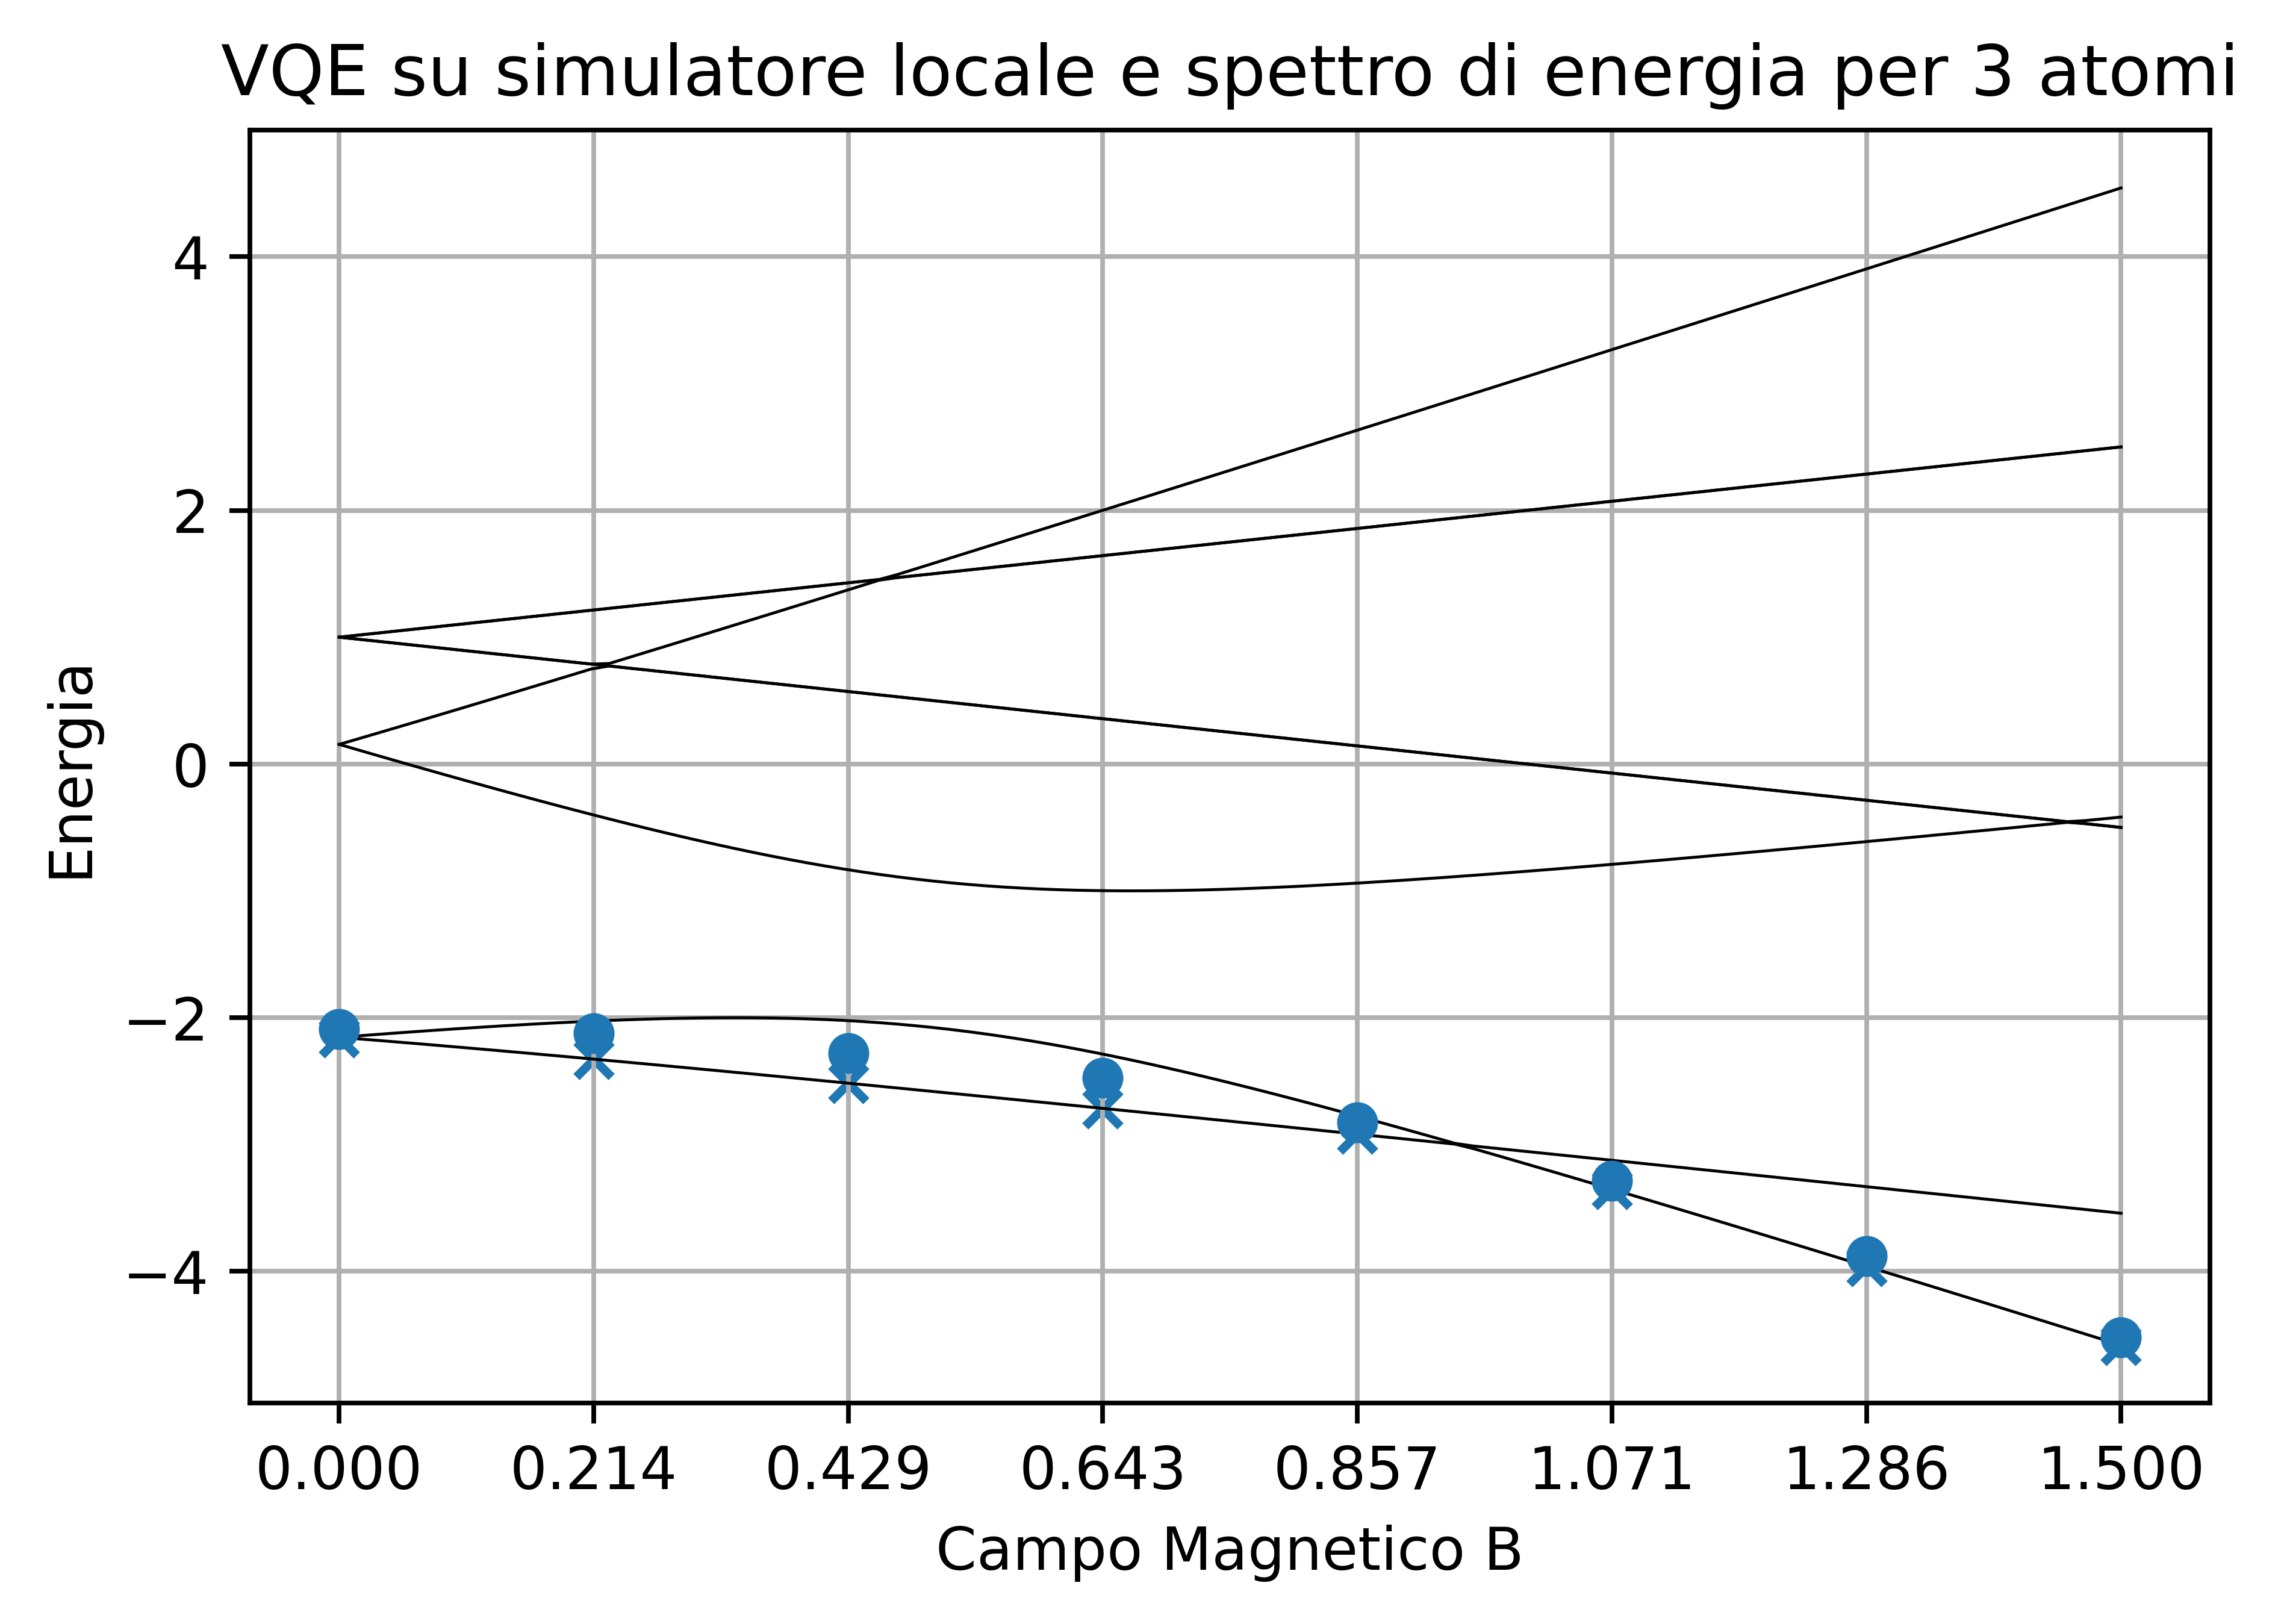

In [46]:
plot_qGS_spectrum(Bmin,Bmax,100,Neval,Natoms,J,gy,gz,qGSEigE,meanerr)

<IPython.core.display.Latex object>

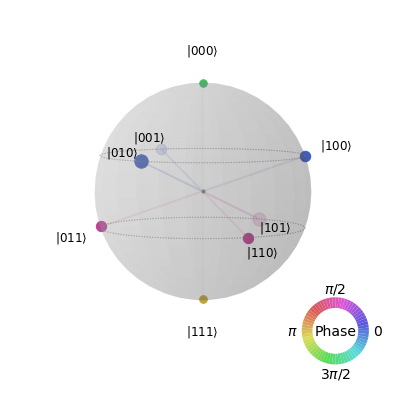

<IPython.core.display.Latex object>

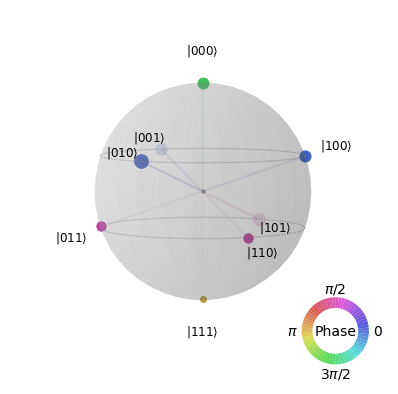

<IPython.core.display.Latex object>

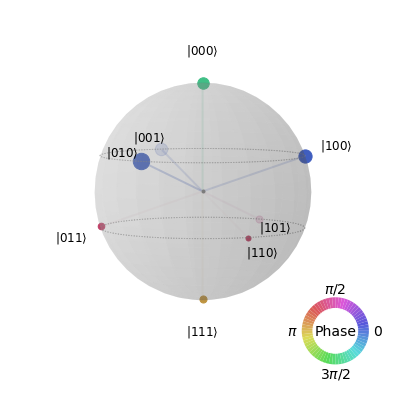

<IPython.core.display.Latex object>

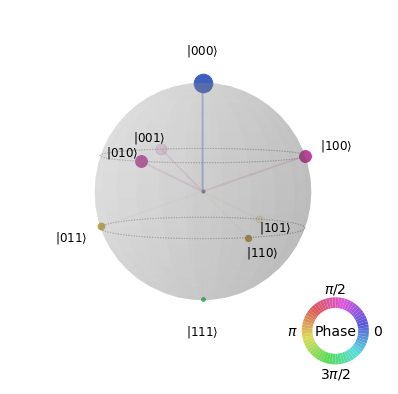

<IPython.core.display.Latex object>

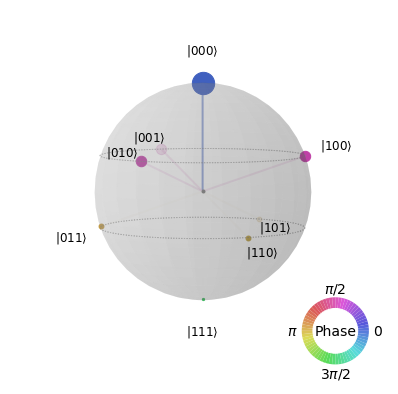

<IPython.core.display.Latex object>

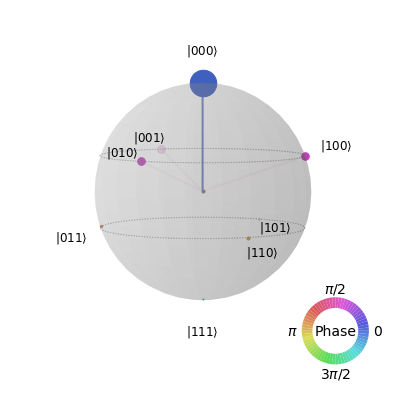

<IPython.core.display.Latex object>

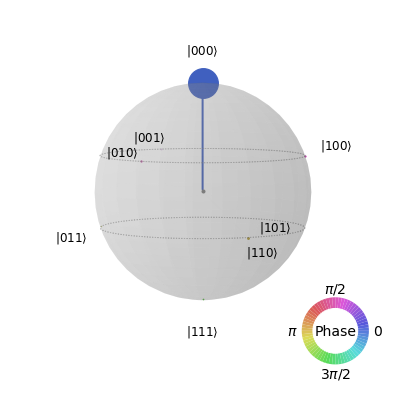

<IPython.core.display.Latex object>

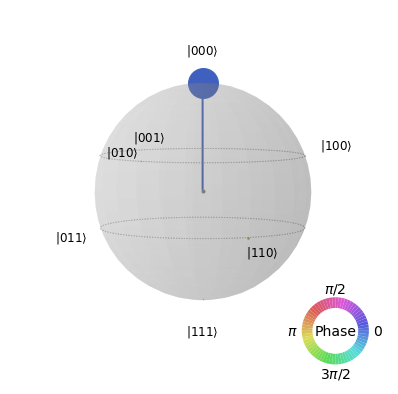

In [47]:
states = [[np.round(abs(j)**2,2)for j in i]for i in qGSstat]
states = [Statevector(entry) for entry in states]
for i in range(len(states)):
    display(array_to_latex(states[i], prefix="B={}:\qquad\\left|\\psi_0\\right>\\ \\to\\ ".format(round(B[i],3))))#Statevector(qGSstat[i])
    display(plot_state_qsphere(qGSstat[i]))

### Hardware/Simulator VQE

#### Preparazione

In [48]:
shots = 512

optimizer = SPSA(maxiter=200)

measurement_error_mitigation = True

qGSEigE1, meanerr1 = Custom_VQE_diag("noisy",shots,optimizer)

'Finito.'

#### Risultati

In [49]:
print('Eigenvalues:','Mean error:')
for i in range(len(qGSEigE1)):
    print(qGSEigE1[i],meanerr1[i])

Eigenvalues: Mean error:
-2.173177083333333 0.036100493402534725
-2.0718936011904763 0.035449695784712014
-2.277715773809524 0.05153497280799339
-2.341982886904762 0.0706621711924954
-2.6584821428571423 0.08103929843640749
-3.237909226190476 0.0642203191590991
-3.9512648809523805 0.059830536066595774
-4.488932291666668 0.06304670674972426


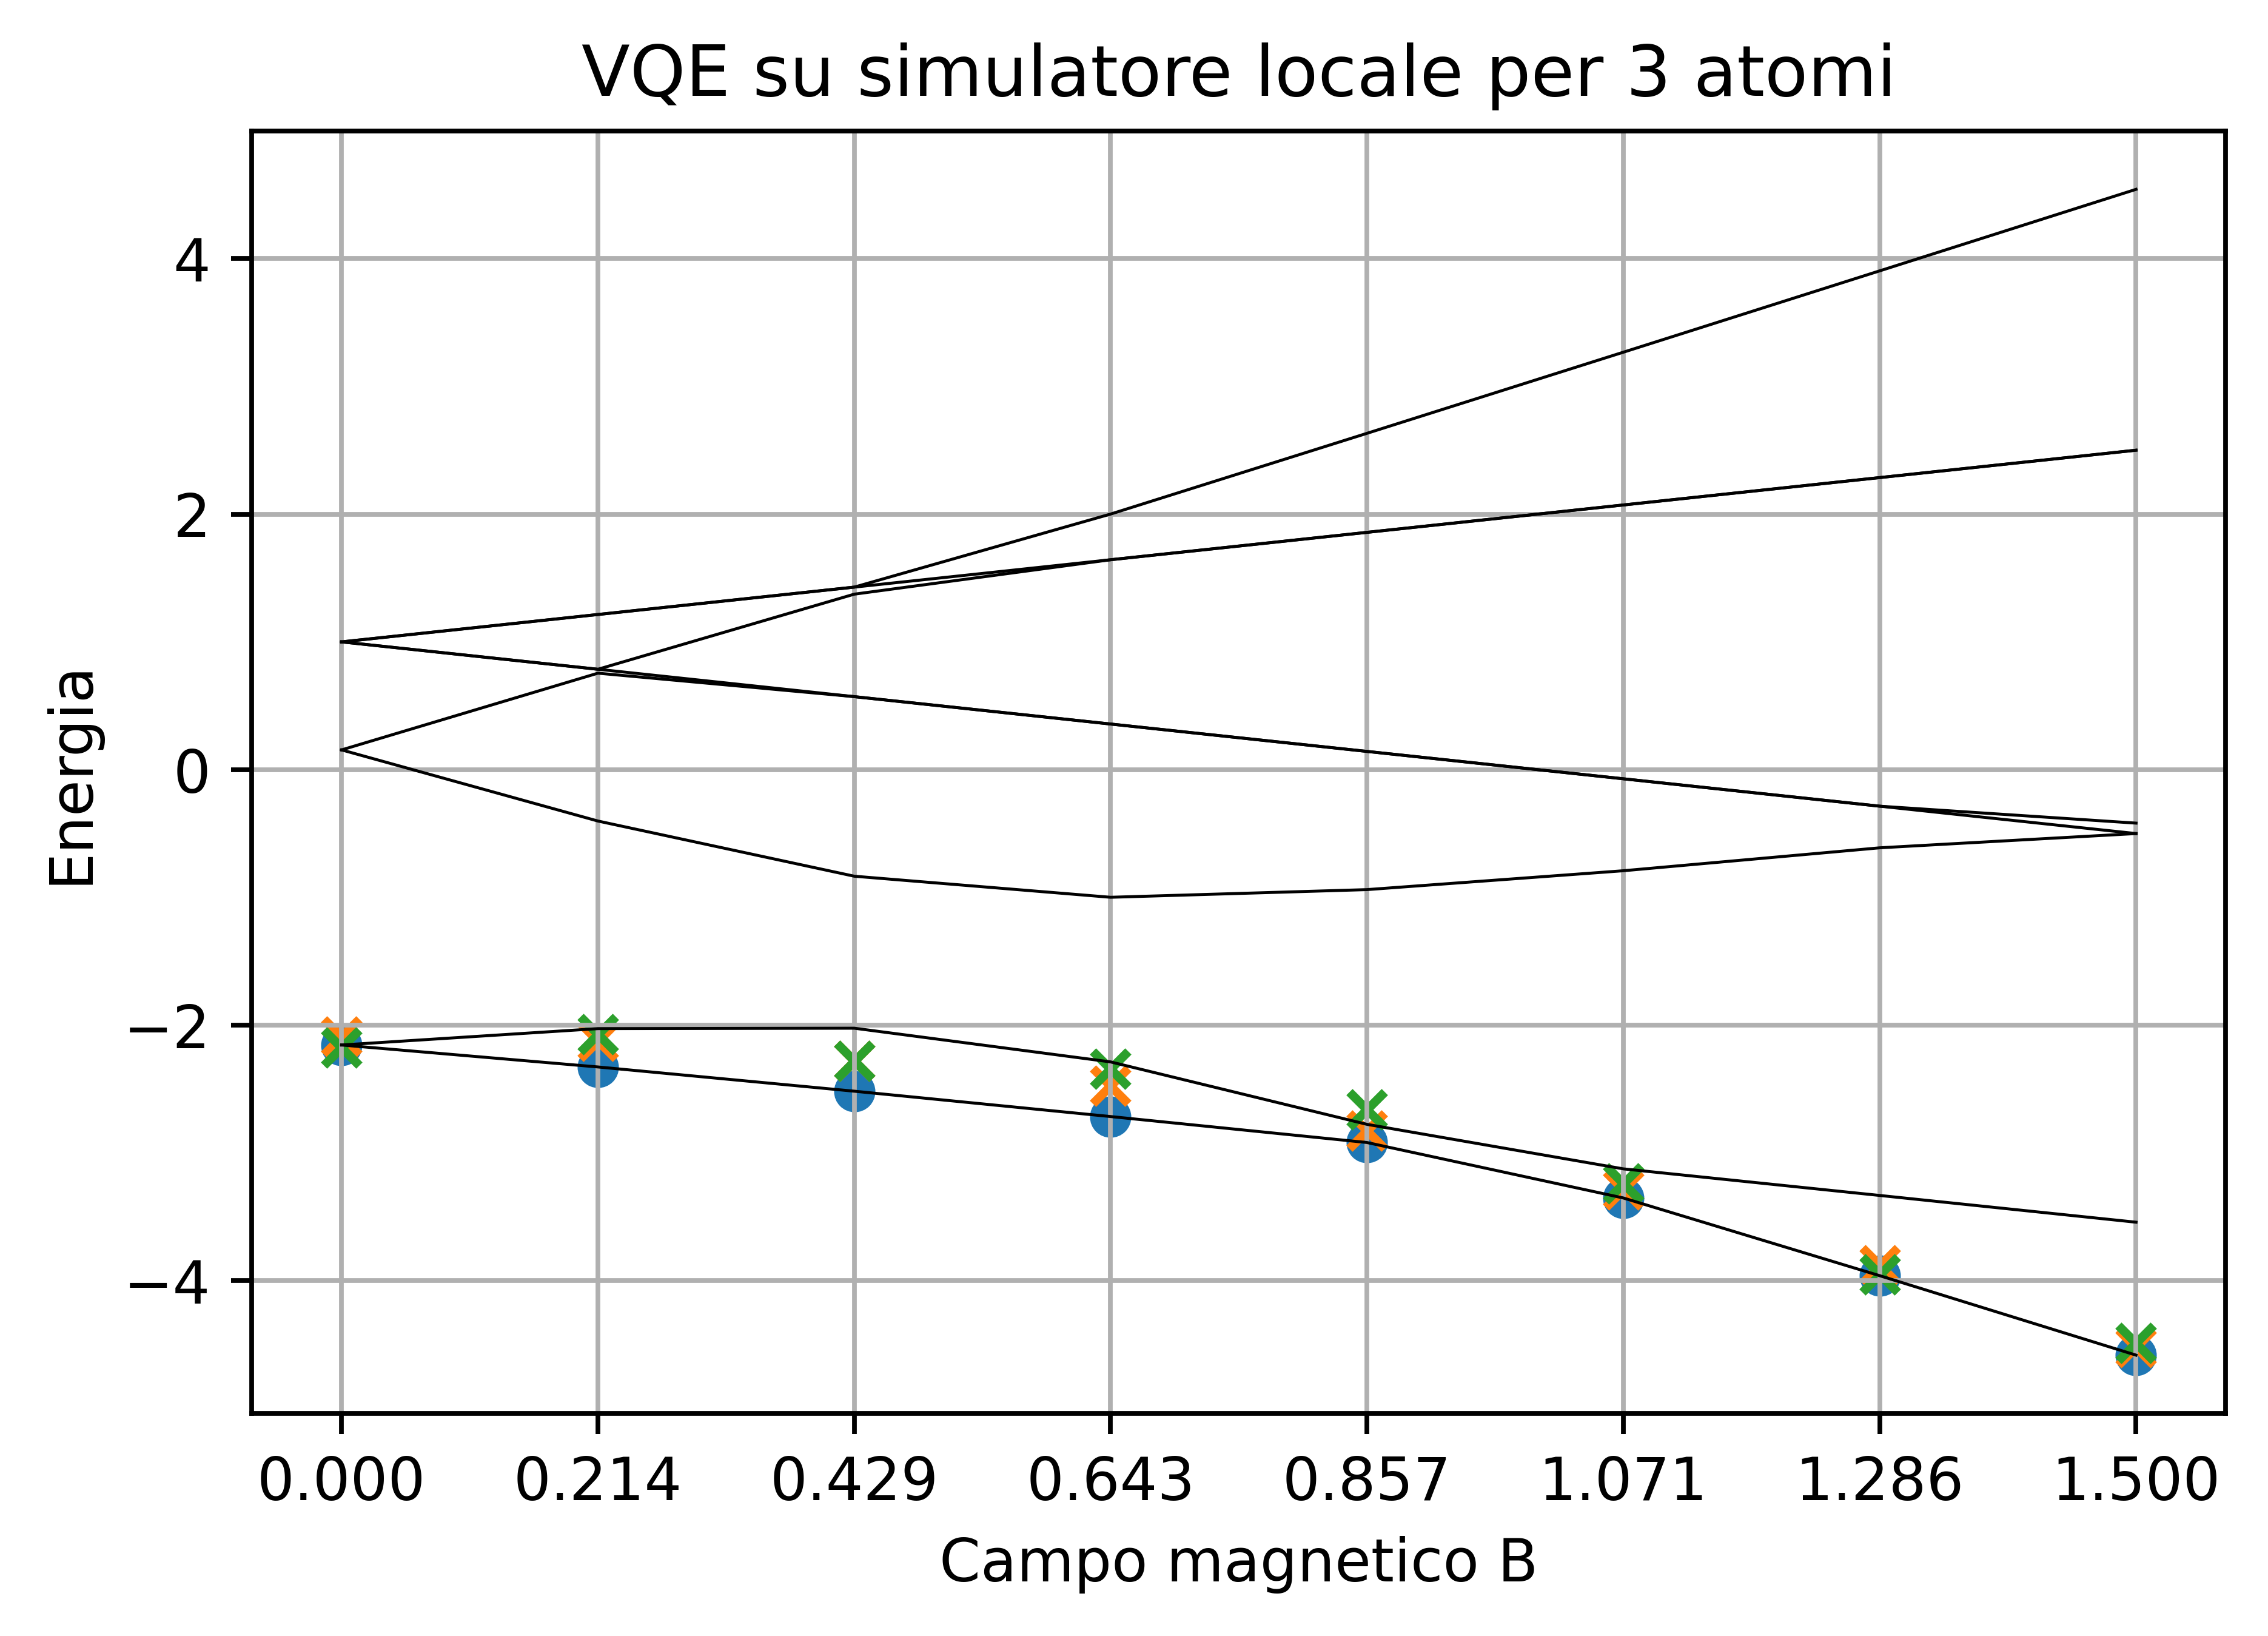

In [50]:
plot_tot([cGSEigE, EigE, qGSEigE, qGSEigE1],Natoms)

### Caso 10 Atomi

In [51]:
Natoms = 10 #Cambiamo numero atomi
J = 1./Natoms # 1/Natoms
gy = 2
gz = 0
Bmin=0.
Bmax=2
Neval=5
B = np.linspace(Bmin,Bmax,Neval).tolist()

### Diagonalizzazione computazionale classica

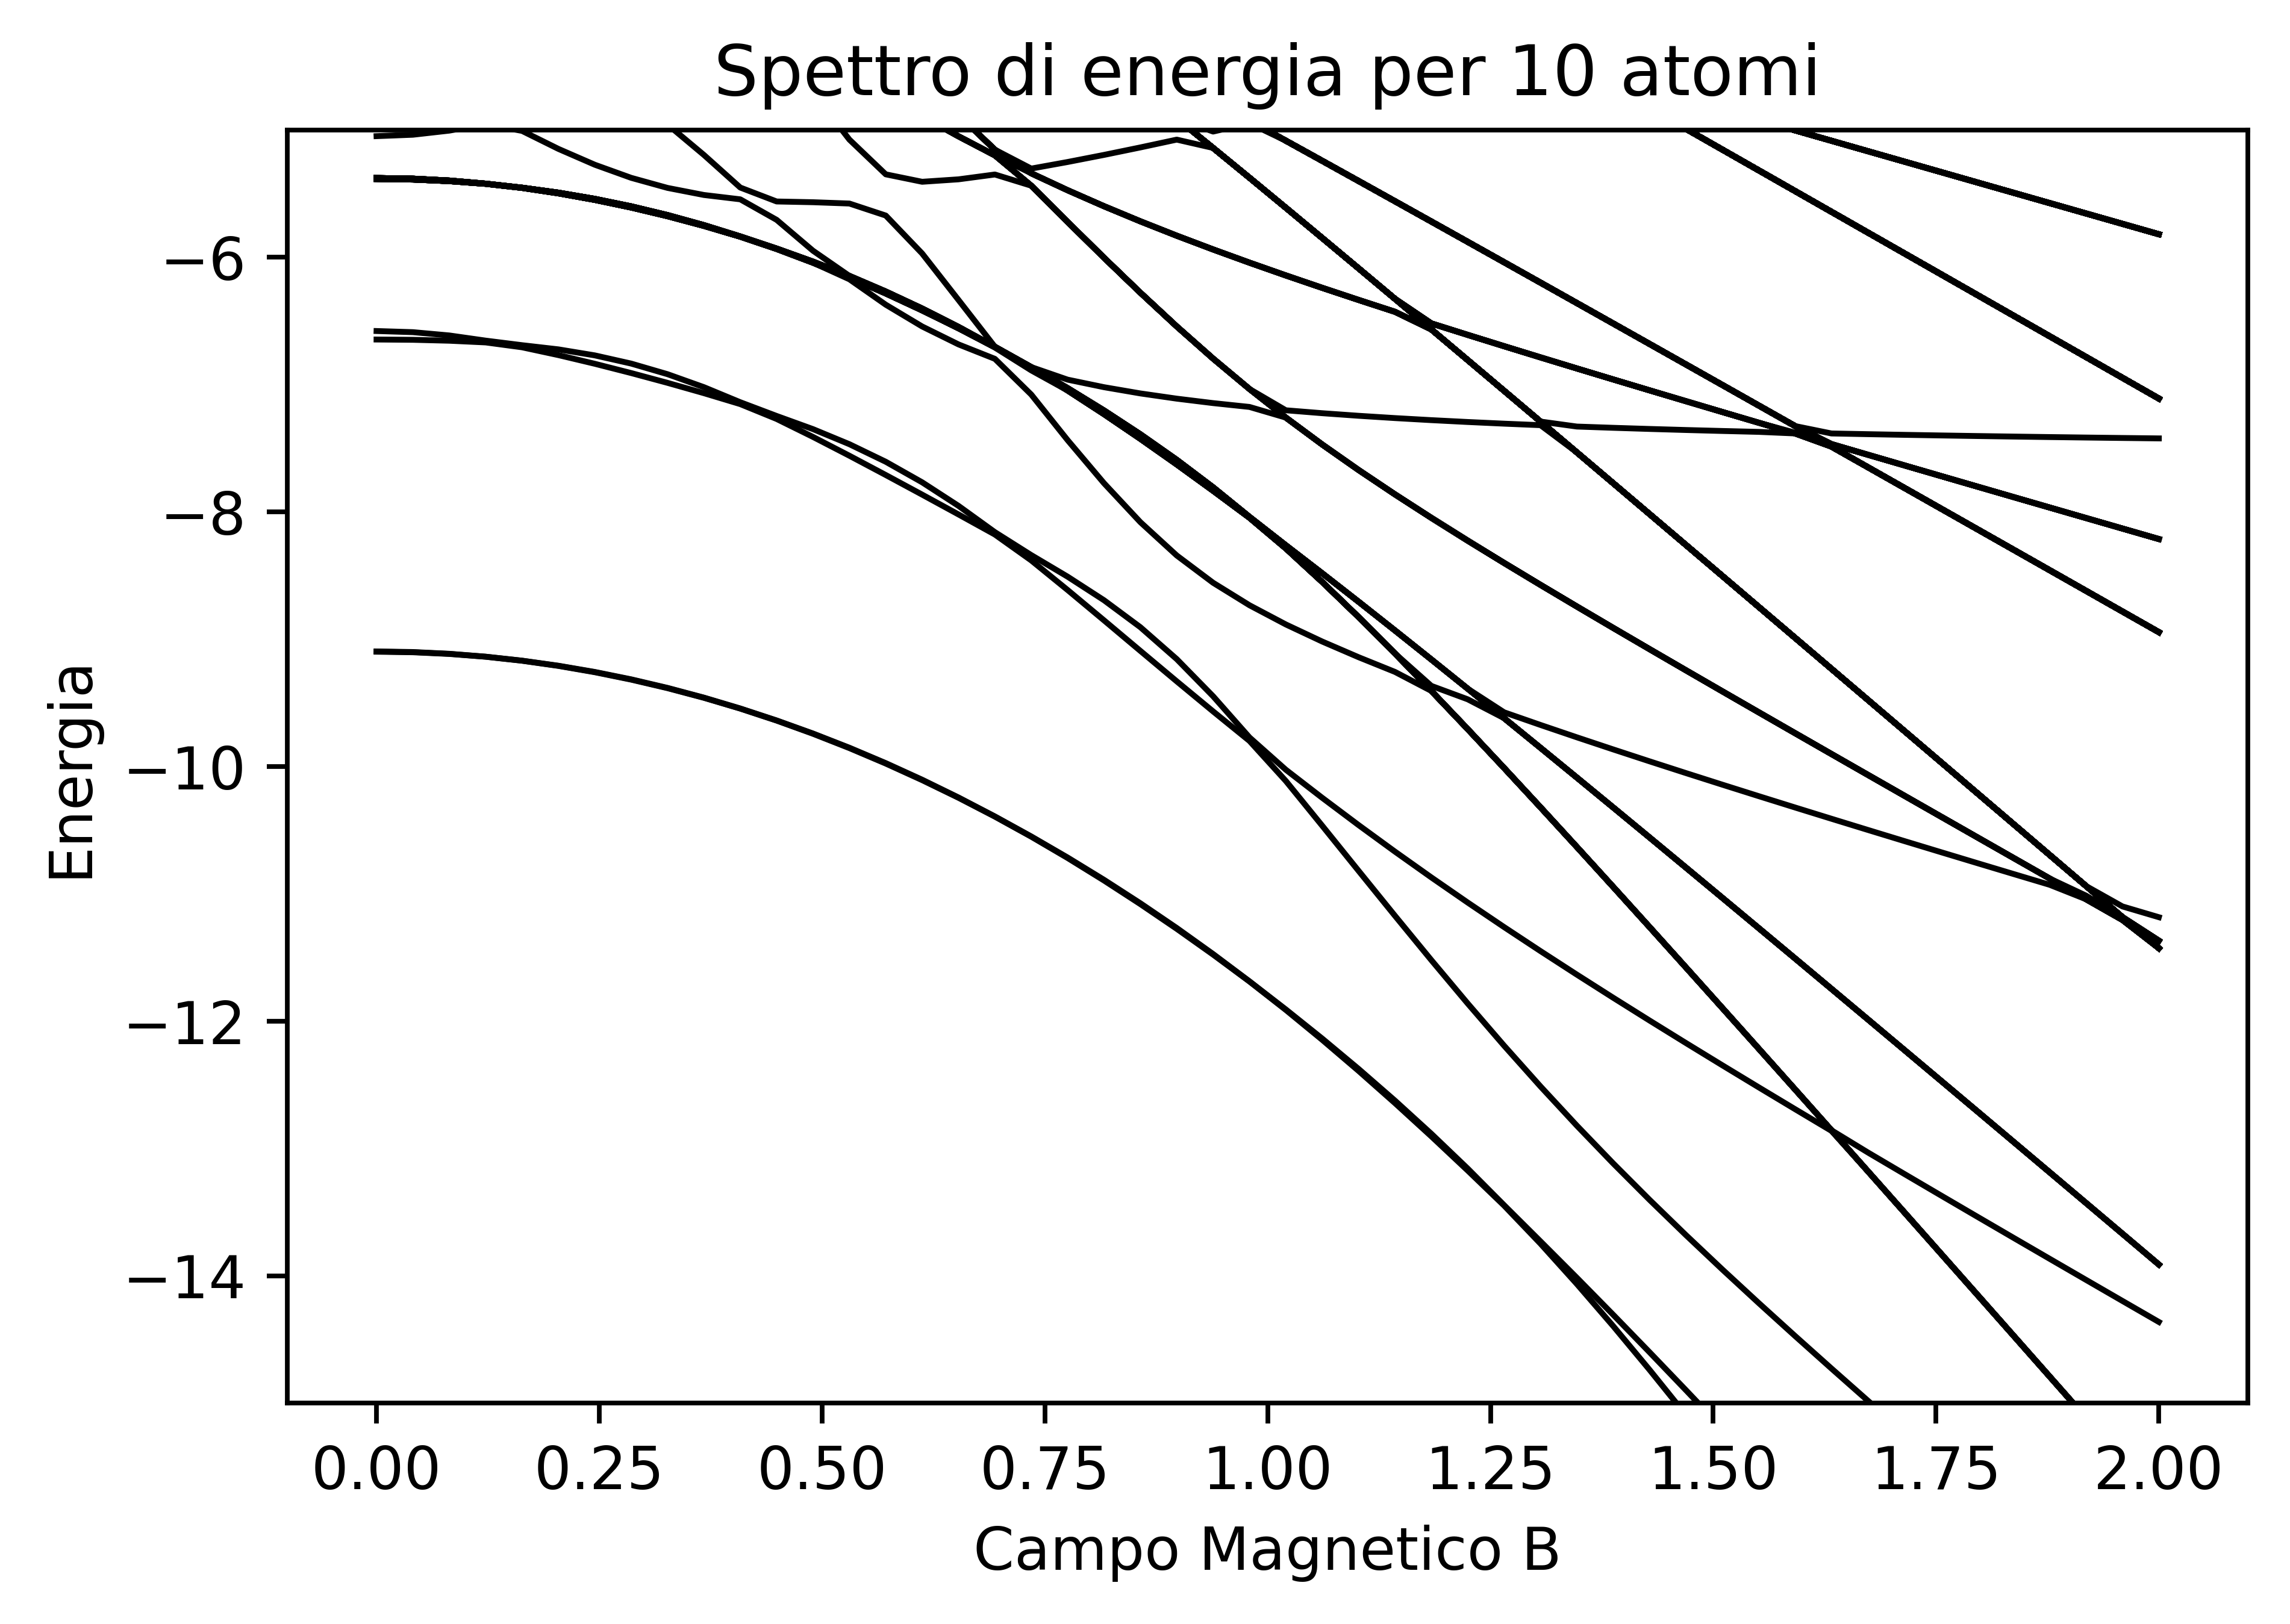

In [52]:
cH = []
for k in B:
    cH.append(Spin_Magnet_Hamilton_class(Natoms,J,gy,gz,k))
    
cGSEigE, EigE = class_par_H_diagonalizer(cH)
spectrum_class_closeup(Bmin,Bmax,50,Natoms,J,gy,gz,-15,-5)

### Diagonalizzazione quantistica con il VQE locale

In [53]:
qH = []
for k in range(len(B)):
    qH.append(Spin_Magnet_Hamilton_quant(Natoms,J,gy,gz,B[k]))

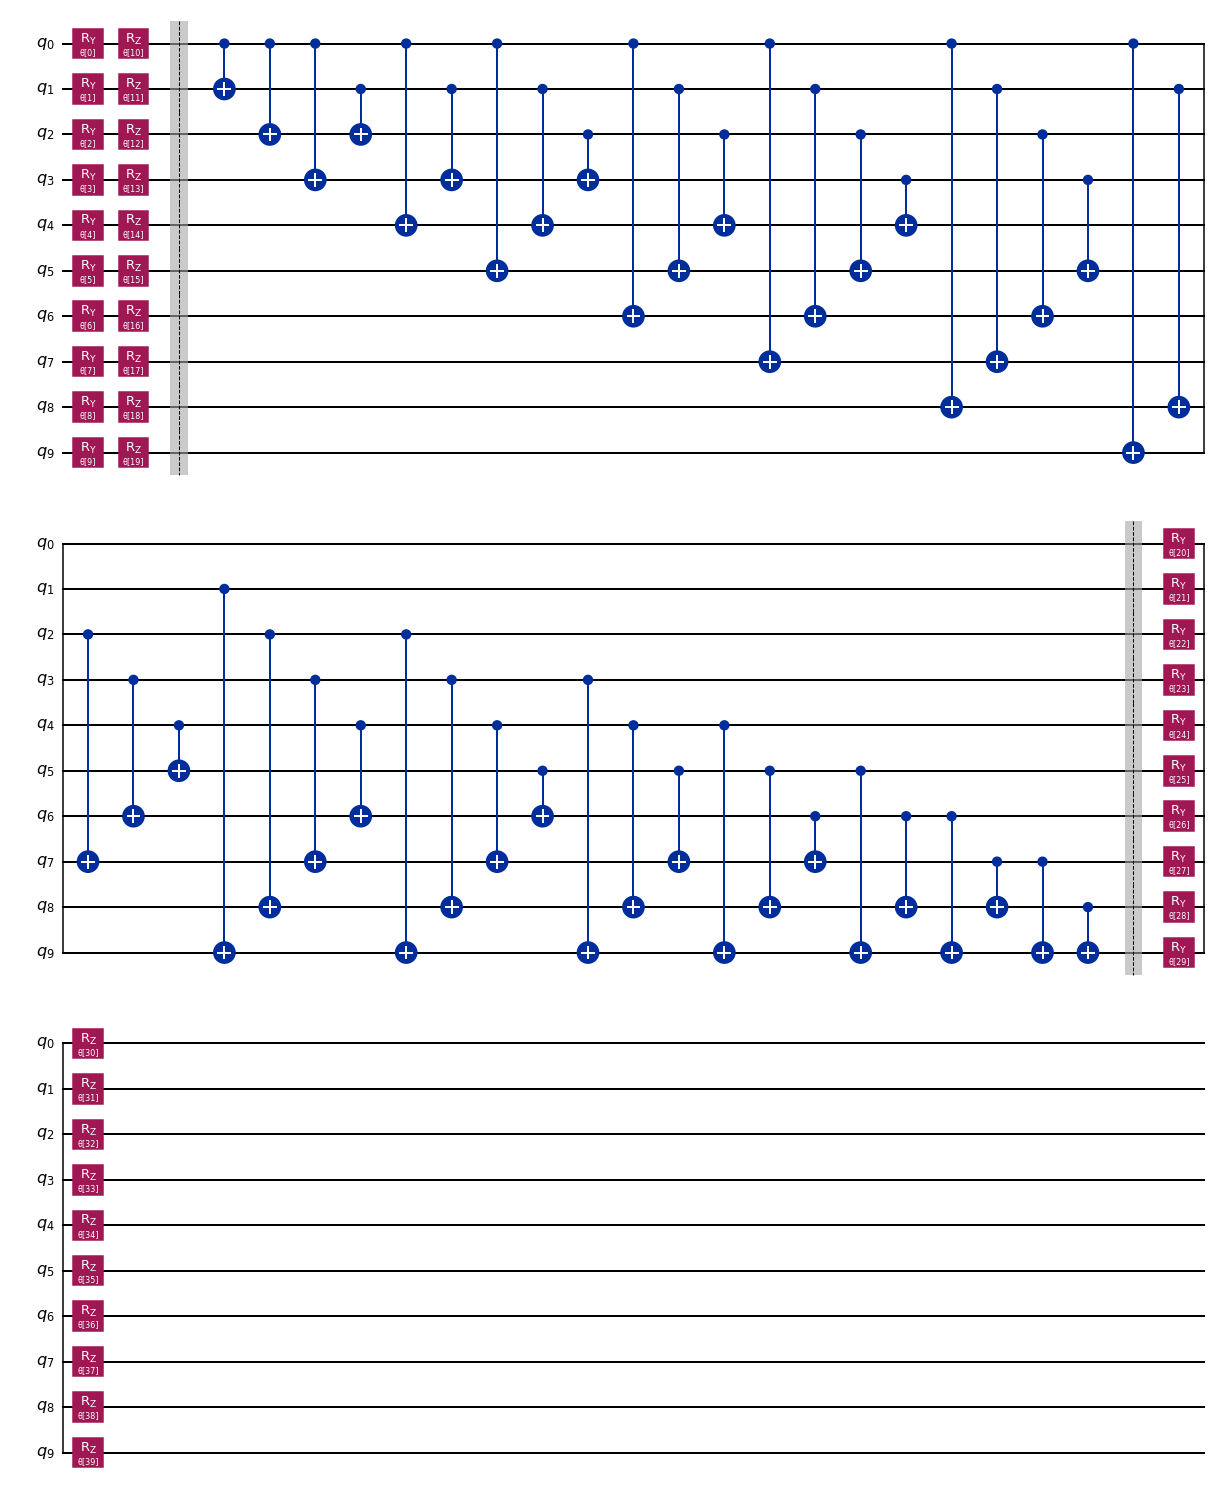

In [54]:
ansatz = EfficientSU2(Natoms, reps=1, entanglement='full', insert_barriers=True) 
ansatz.decompose().draw('mpl', style='iqx')

In [55]:
optimizer = COBYLA(maxiter=400)

np.random.seed(10)  # seed for reproducibility
initial_point = np.random.random(ansatz.num_parameters)

In [56]:
local_vqe = VQE(ansatz=ansatz,
                optimizer=optimizer,
                initial_point=initial_point,
                quantum_instance=StatevectorSimulatorPy(),
                callback=callback)

qGSEigE, qGSstat, meanerr = VQE_par_H_diagonalizer(local_vqe,qH)

'Finito.'

### Risultati

In [57]:
print('Eigenvalues:','Mean error:')
for i in range(len(qGSEigE)):
    print(qGSEigE[i],meanerr[i])

Eigenvalues: Mean error:
-8.959639609739744 0.0
-9.68272877384602 0.0
-11.742033040798075 0.0
-15.019609273267378 0.0
-19.97650486119549 0.0


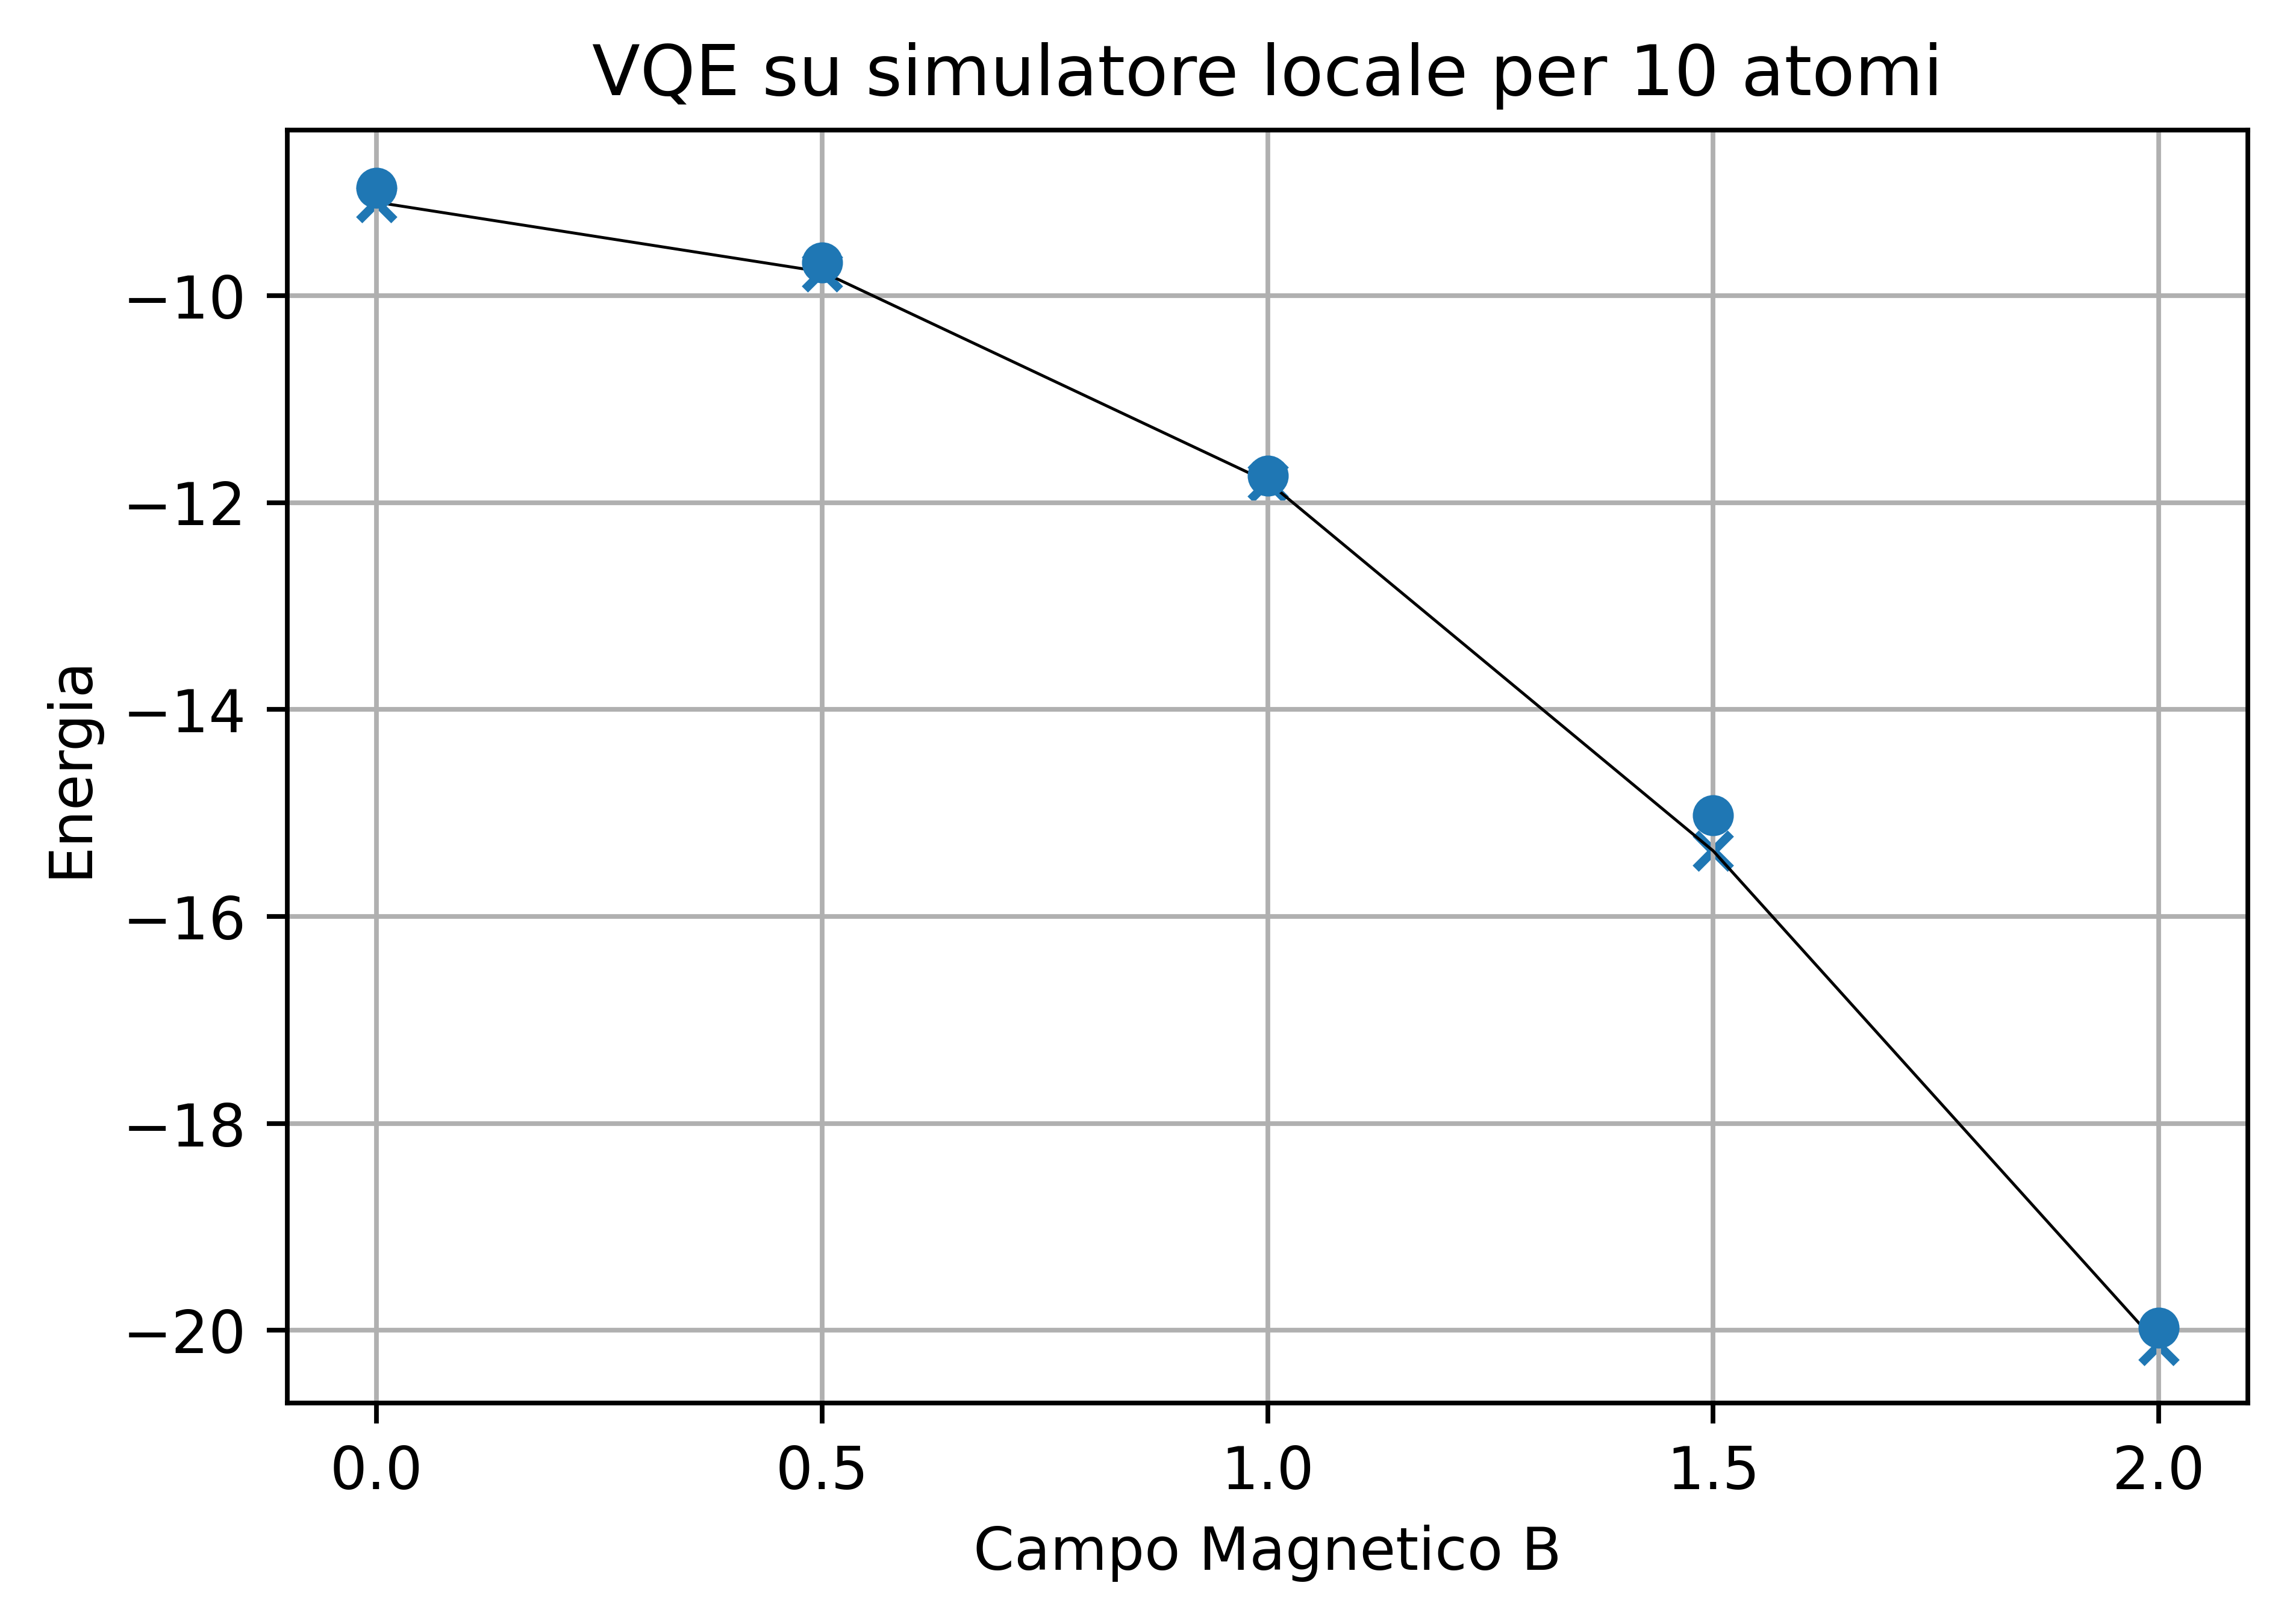

In [58]:
plot_qGS(Bmin,Bmax,100,Neval,Natoms,J,gy,gz,qGSEigE,meanerr)

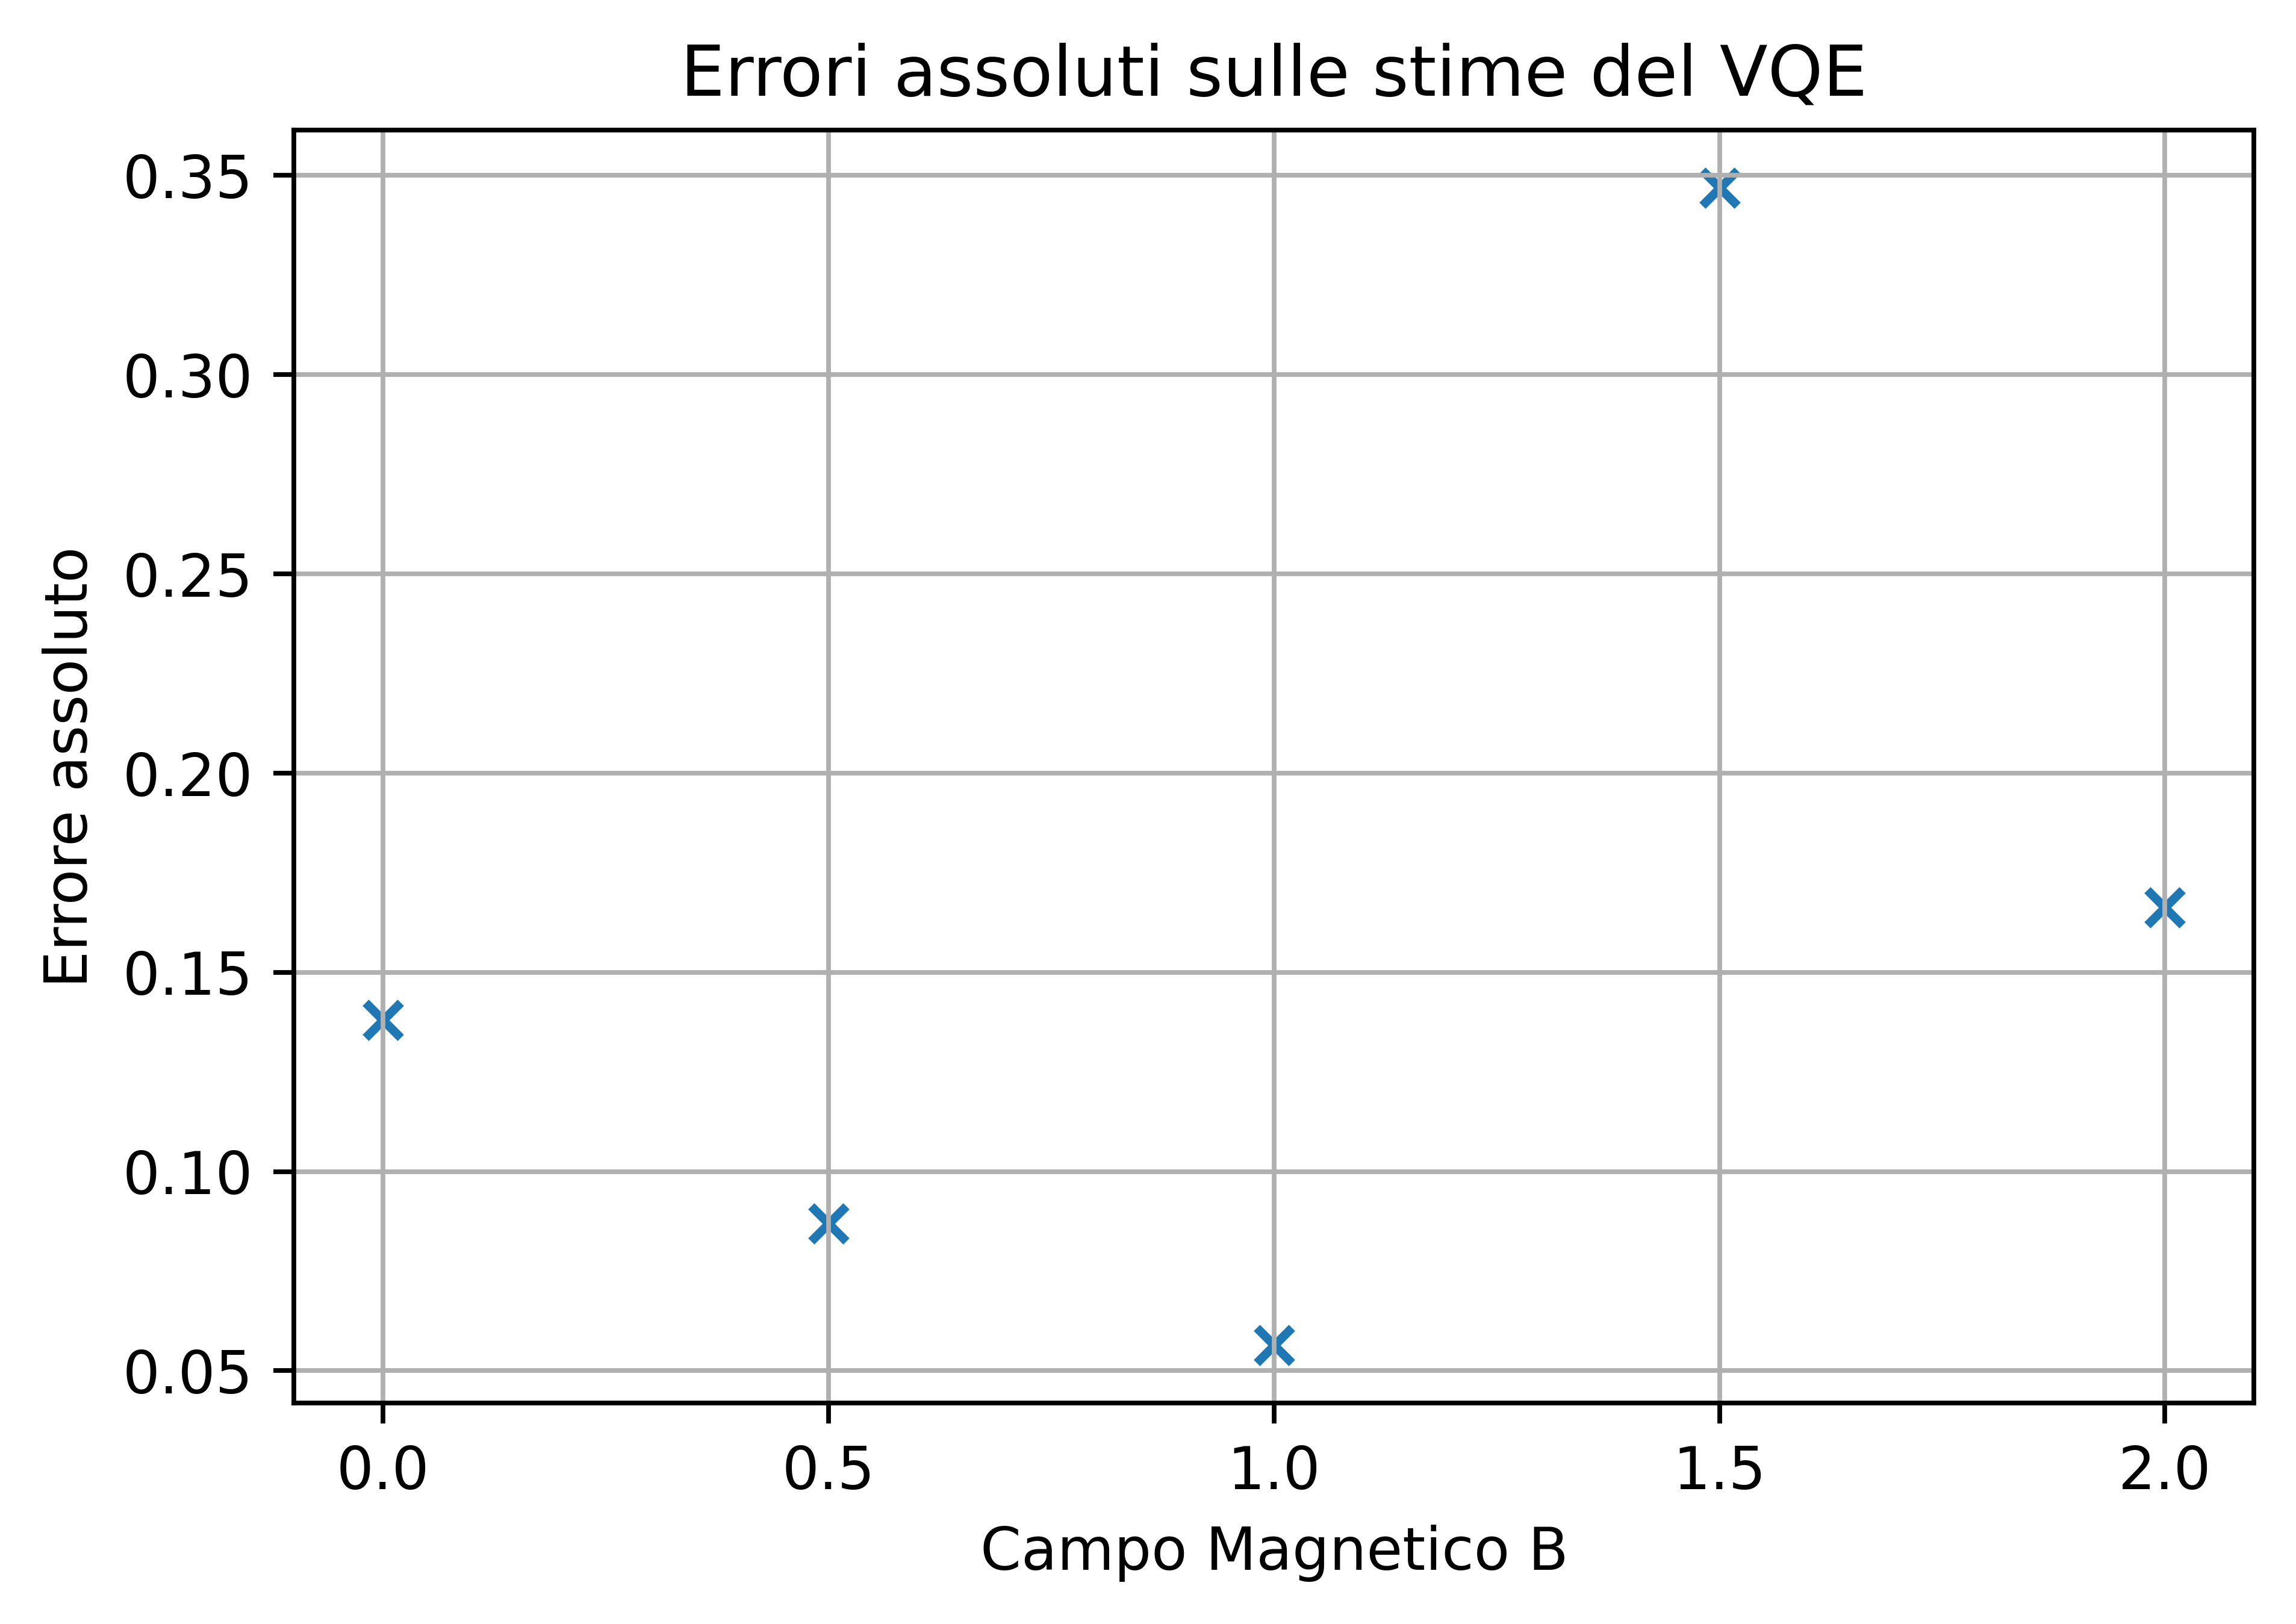

In [59]:
plot_abserr(B,cGSEigE,qGSEigE)

In [60]:
##Funzione per considerare solo gli autostati ad energia più bassa
lowSEigE=[]

for i in EigE:
    tmp=[]
    for j in range(0,len(i)):
        if j<6:
            tmp.append(i[j])
    lowSEigE.append(tmp)

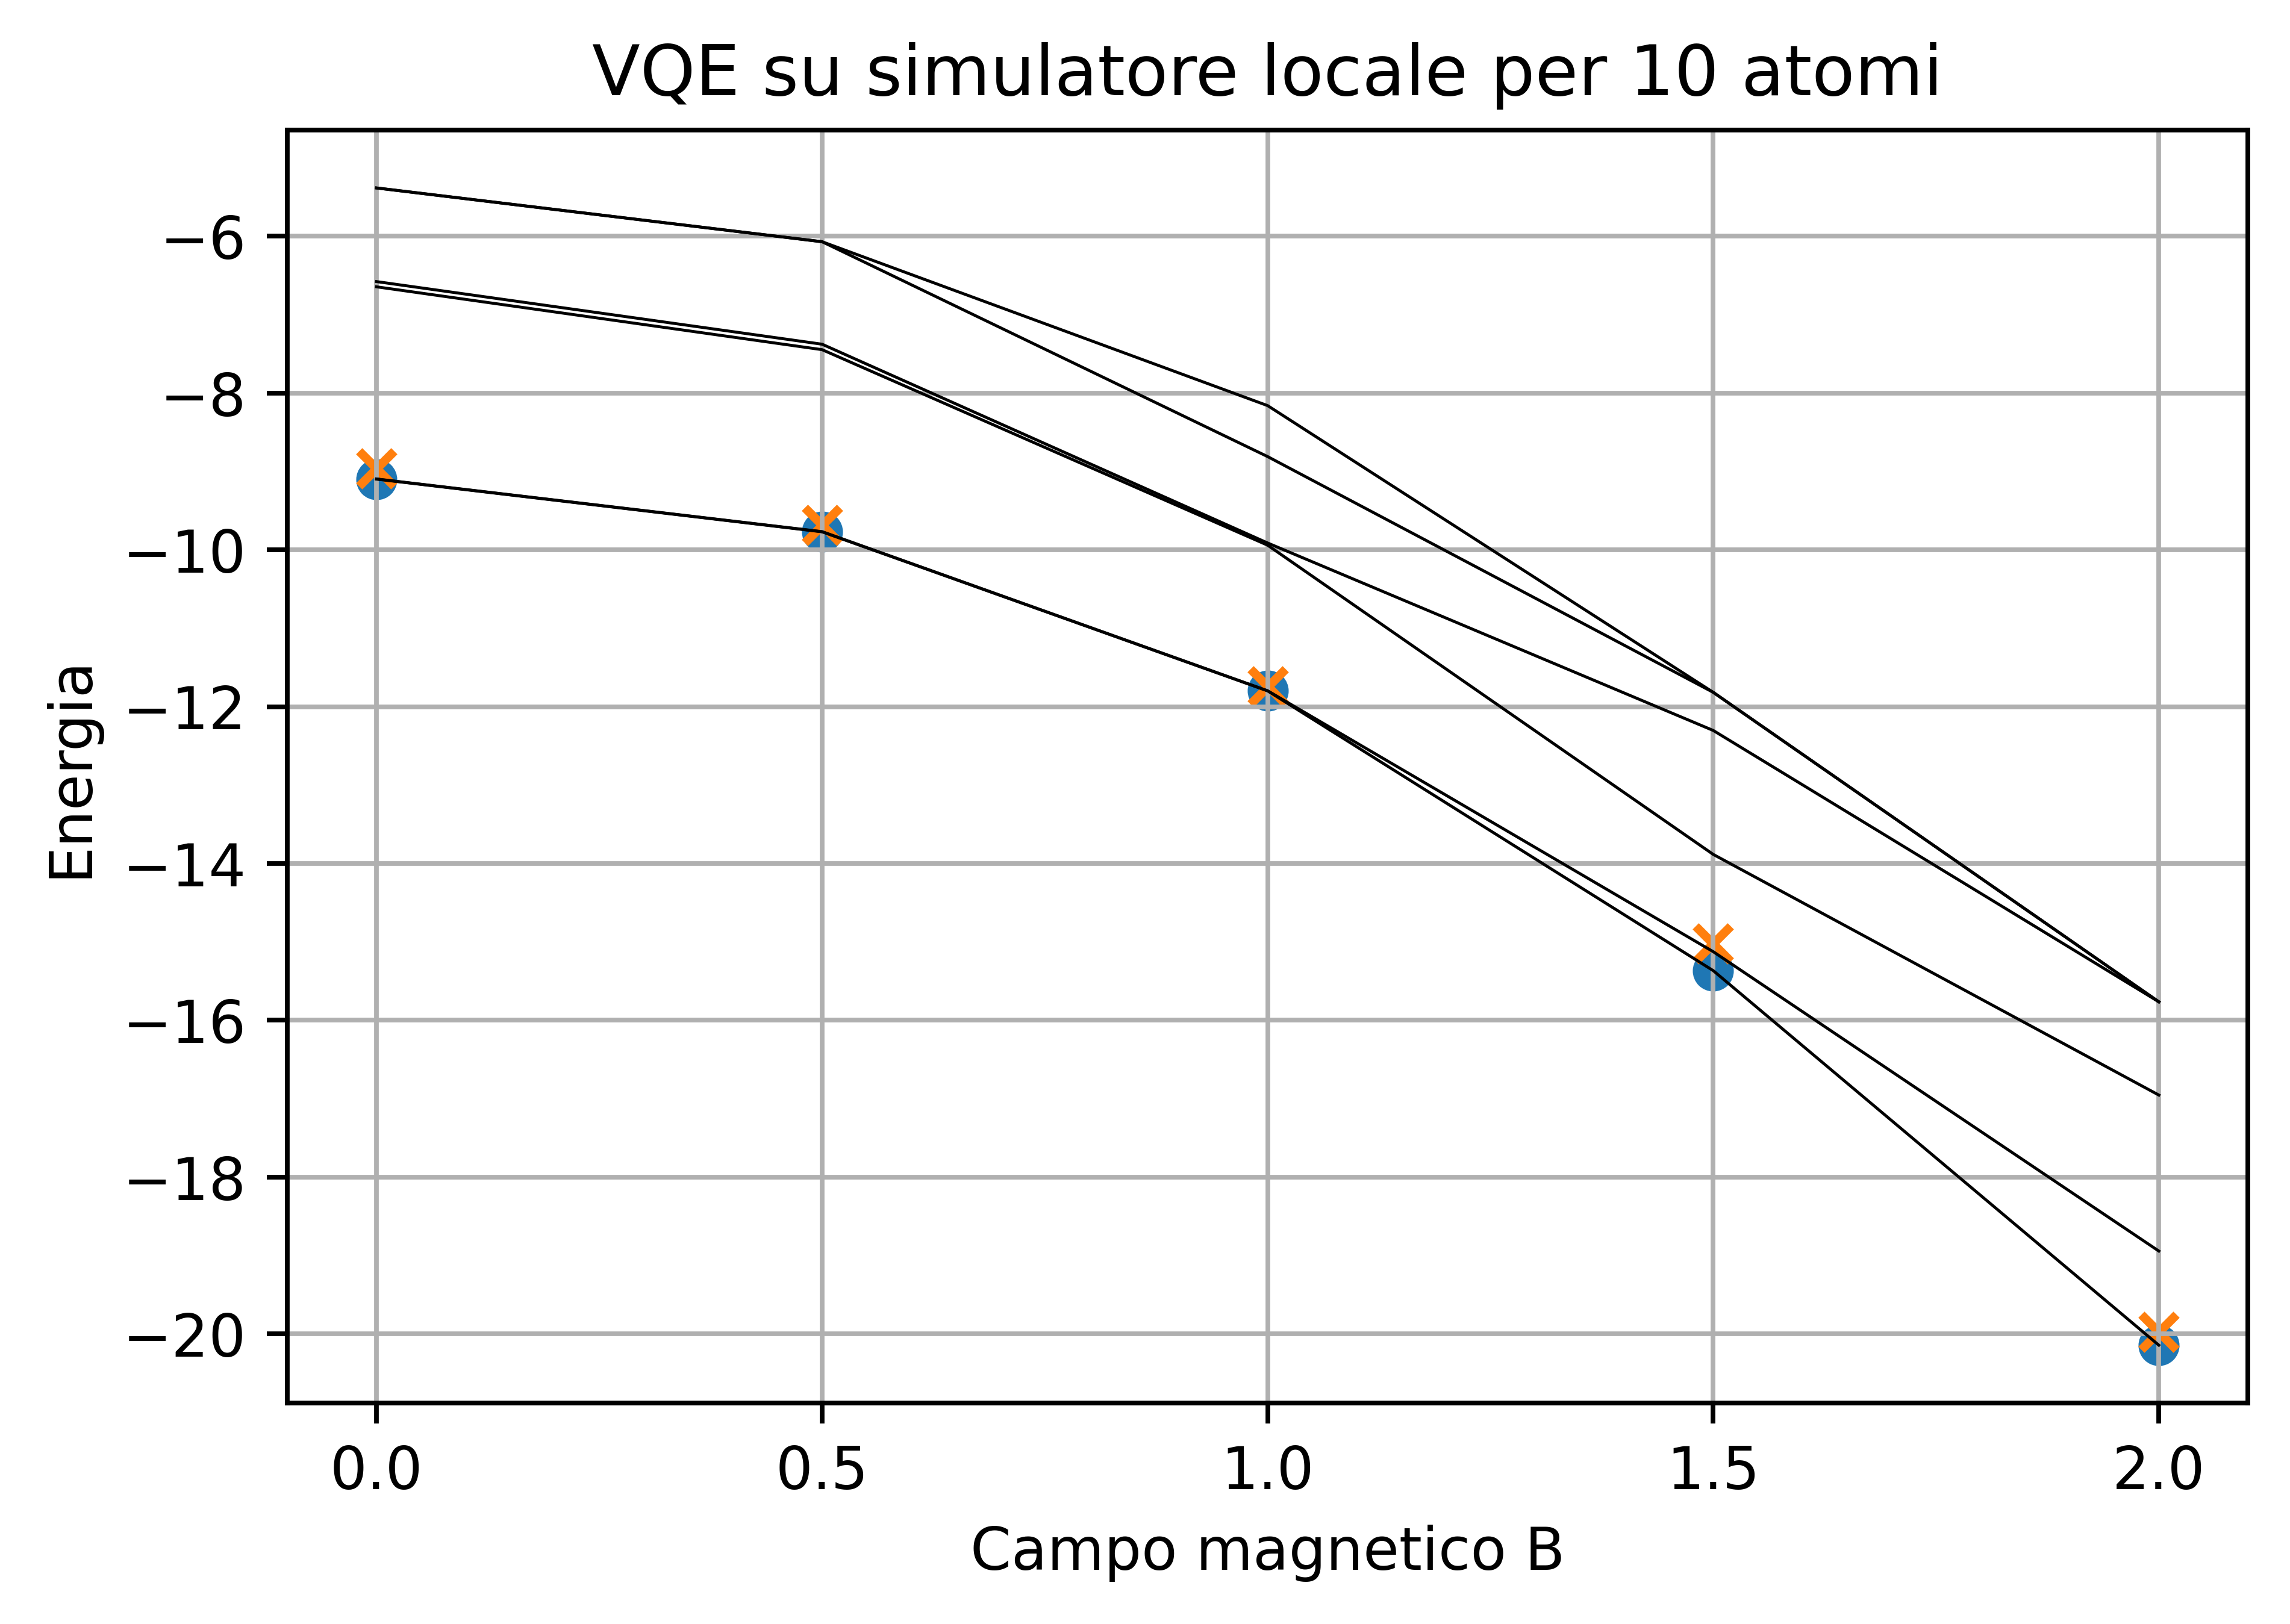

In [61]:
plot_tot([cGSEigE, lowSEigE, qGSEigE],Natoms)

In [ ]:
#states = [[np.round(abs(j)**2,2)for j in i]for i in qGSstat]
#states = [Statevector(entry) for entry in states]
#for i in range(len(states)):
#    display(array_to_latex(states[i], prefix="B={}:\qquad\\left|\\psi_0\\right>\\ \\to\\ ".format(round(B[i],3))))#Statevector(qGSstat[i])
#    display(plot_state_qsphere(qGSstat[i]))

### Evoluzione temporale

E' spesso interessante, nello studio di una certa hamiltoniana, studiare l'evoluzione temporale degli stati. A livello operatoriale, l'evoluzione temporale di uno stato è data da: <br>
$$ \hat U(t)=e^{-\frac{i t\hat H}{\hbar}}$$
$$ \hat U(t)\left|\psi_0\right> = \left|\psi(t)\right>$$

Questo si traduce, dal punto di vista circuitale, nella ricerca di un gate equivalente. Applicando quindi questo gate ad un registro opportunamente inizializzato potremo simulare l'evoluzione dello stato.

Ricaviamo quindi l'evolutore temporale. Il passaggio da $\hat H$ a $\hat U(t)$ è effettuato tramite una funzione di Qiskit. Per ricavare invece la forma del gate dobbiamo considerare gli operatori fondamentali del tipo di computer quantistico su cui stiamo lavorando.

In [86]:
#Importazione librerie

from qiskit.circuit.gate import Gate
from qiskit.extensions import HamiltonianGate
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.compiler import transpile
from qiskit.transpiler import PassManager

In particolare analizziamo due basi:
- Gate di singolo qubit + CNOT (Super Conducting qubits)
- Gate di  Mølmer–Sørensen + Rotazioni di singolo qubit (Ion Trap, $S_4$)

I Gate di Mølmer–Sørensen sono dei gate che effettuano rotazioni su piu qubit contemporaneamente. Nel caso di interazioni a molte particelle ci aspettiamo quindi un numero minore di gate totali. Diminuendo la complessità del circuito andiamo a contrastare l'effetto del rumore.

In [87]:
#Provider del simulatore del computer quantistico Ion-trap: per tutorial
#https://github.com/Qiskit-Partners/qiskit-aqt-provider

from qiskit_aqt_provider import AQTProvider
aqt = AQTProvider('MY_TOKEN') #Sembra non avere davvero bisogno di un token vero
backend = aqt.backends.aqt_qasm_simulator


#Array dei circuiti

SC=[]
IT=[]
SC_depth=[]
IT_depth=[]

#Parametri dell'operatore evoluzione temporale

timestep=0.5
gy = 0.5
gz = 0.
B = 0.3

#Massimo numero di quibits

MaxQubits=7

Il modo in cui traduciamo il circuito di evoluzione temporale in un circuito con gate effettivi è attraverso il la funzione `transpile` , specificando la base su cui decomporre.

In [88]:
#Funzione di costruzione dei circuiti

for i in range(2,MaxQubits+1):
    #Aggiorniamo numero qubit e il parametro J
    Natoms = i
    J = 1/Natoms 
    
    #Costruzione gate e circuito
    ham = Spin_Magnet_Hamilton_quant(Natoms,J,gy,gz,B) #Ricavo PauliSumOp    
    operator=Operator(ham.to_matrix()) #Da PauliSumOp a Operator
    gate = HamiltonianGate(operator,timestep) #Da operatore a gate
    circuit = QuantumCircuit(Natoms) 
    circuit.append(gate, range(0,Natoms)) #Da gate a circuito
    #circuit.draw('mpl', style='iqx') #Step opzionale per disegnare il circuito
    
    
    #Transpile per super conducting
    SC_qc=transpile(circuit,basis_gates=['cx','id','rz','sx','x'])
    
    #Transpile per ion-trap
    IT_qc = transpile(circuit, backend)
    
    SC.append(SC_qc)
    IT.append(IT_qc)
    
    SC_depth.append(SC_qc.depth())
    IT_depth.append(IT_qc.depth())
    
    ipd_clear()
    ipd_display("iterazione",i-1,"di",MaxQubits-1,"completata")
    
ipd_clear()
ipd_display('Finito.')

'Finito.'

Per confrontare i due circuiti ne misuriamo la profondità. All'aumentare del numero di qubit ci aspettiamo una differenza sempre maggiore tra i due casi:

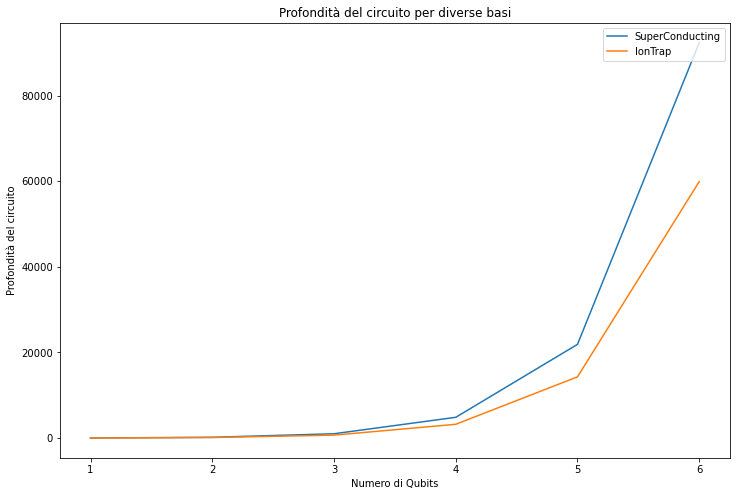

In [89]:
##Funzione di Plot delle profondità, confrontate a numero pari di qubit

Circ_depth=[SC_depth,IT_depth]
Circ_label=["SuperConducting","IonTrap"]
pylab.rcParams['figure.figsize'] = (12, 8)
for i in range(len(Circ_depth)):
    pylab.plot(range(1,len(Circ_depth[i])+1), Circ_depth[i], label=Circ_label[i])
pylab.xlabel('Numero di Qubits')
pylab.ylabel('Profondità del circuito')
pylab.title('Profondità del circuito per diverse basi')
#pylab.yscale('log') #Opzione logaritmica
pylab.legend(loc='upper right');

Visualizziamo visivamente la forma dei due circuiti:

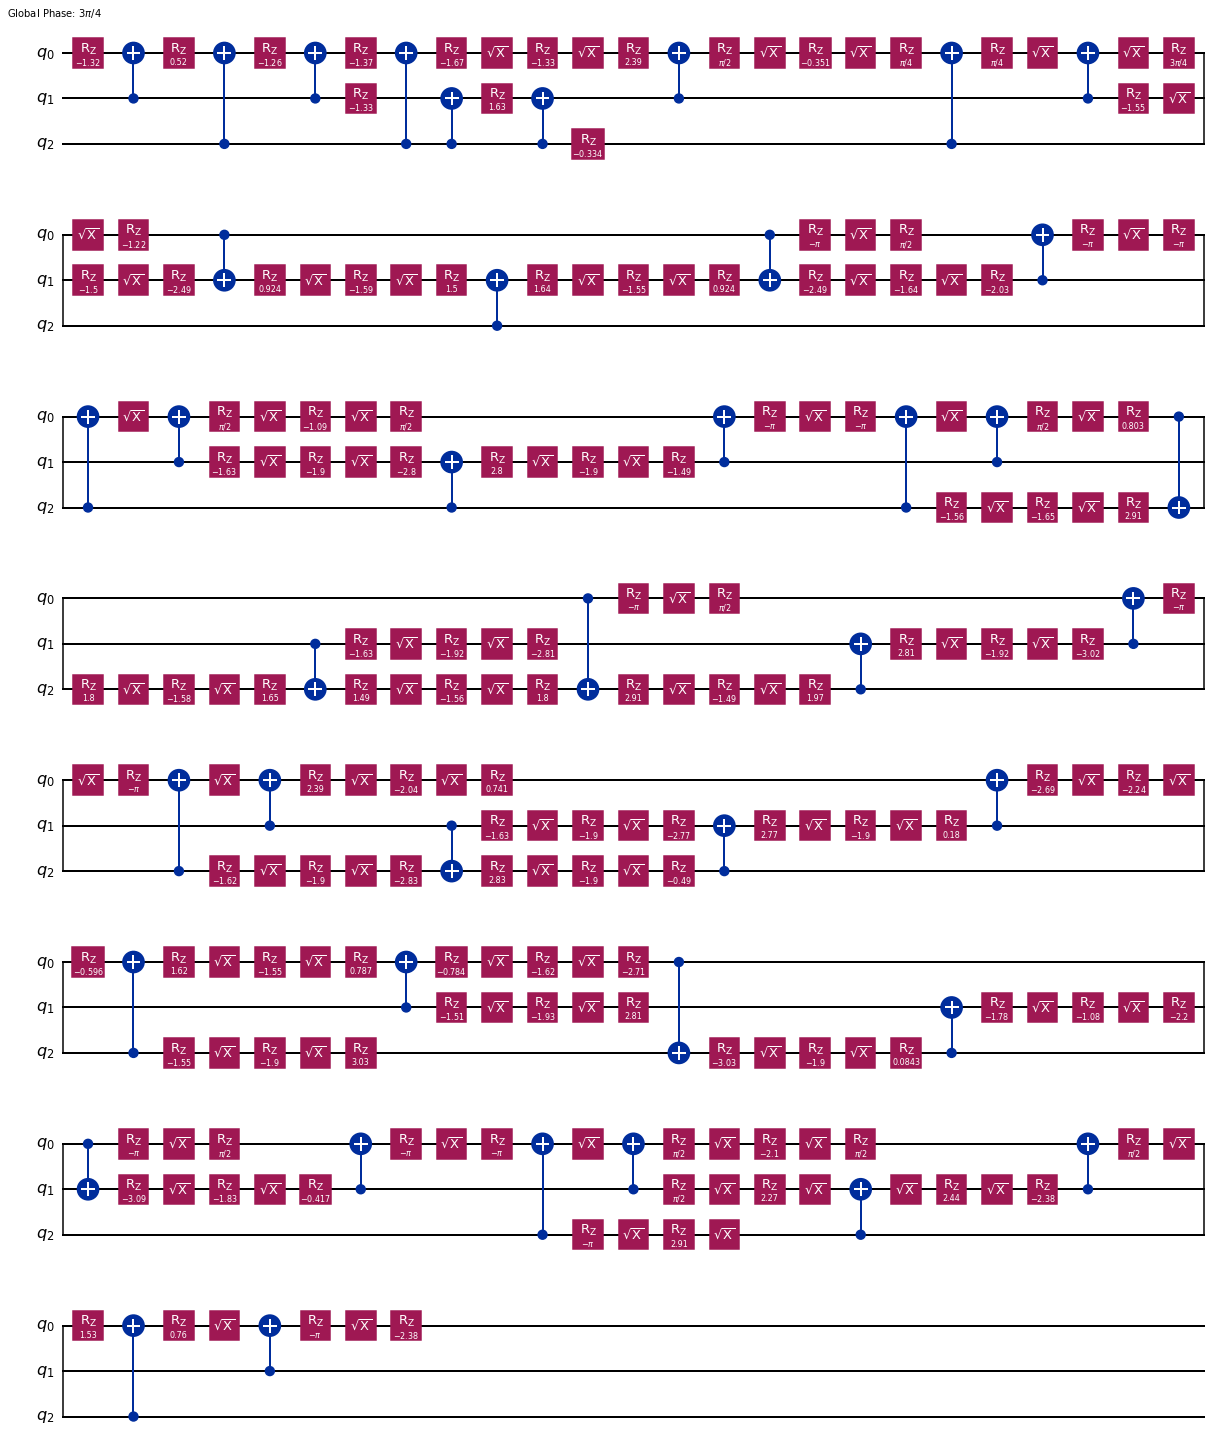

In [90]:
myN=3 #numero di qubit
#SC[myN-2].draw('mpl', style='iqx')

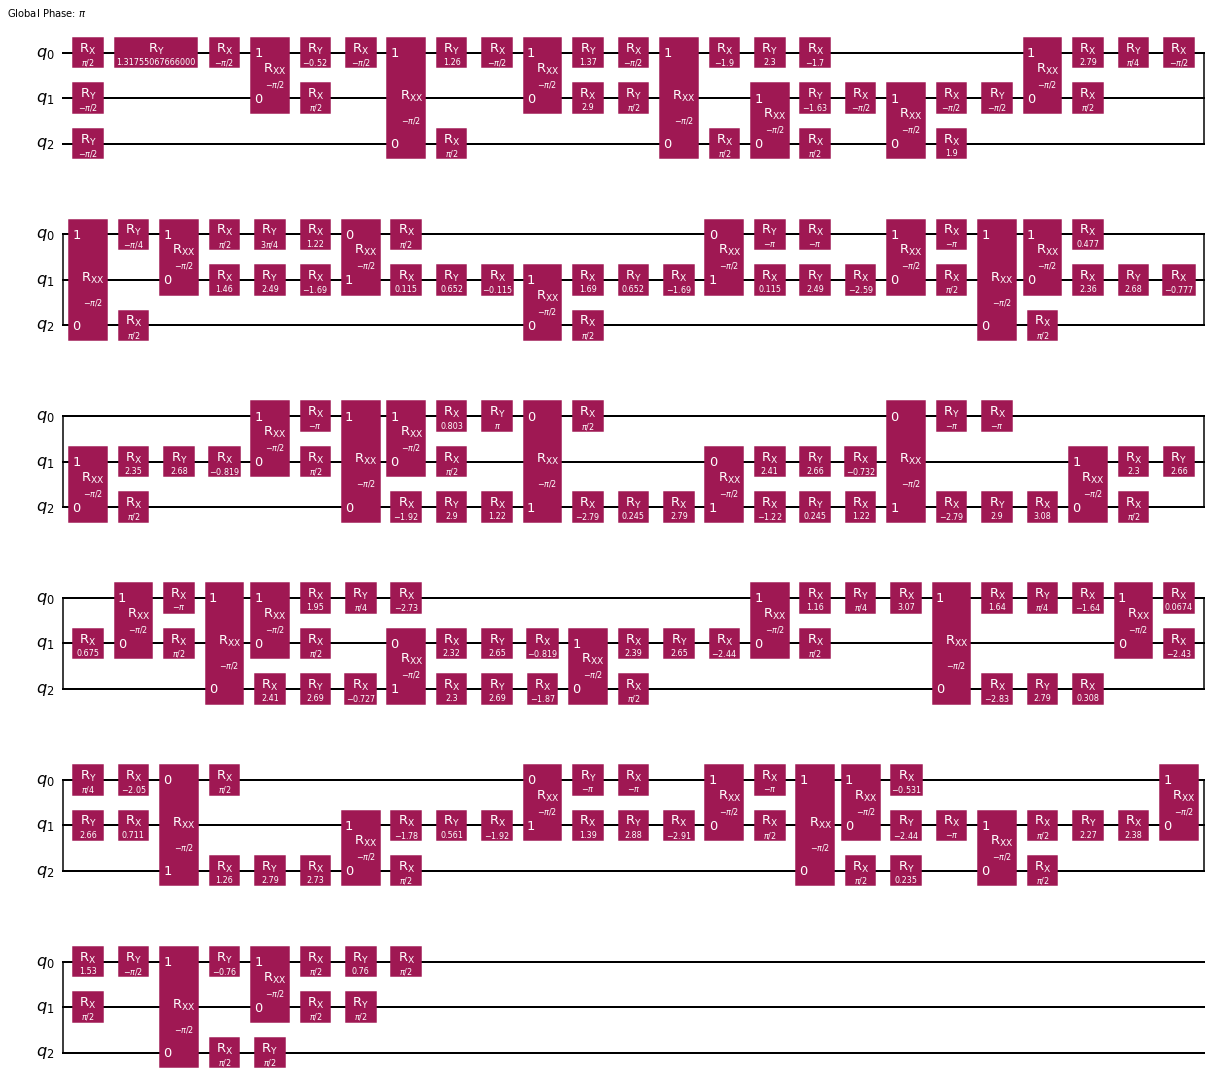

In [91]:
#IT[myN-2].draw('mpl', style='iqx')

## Confronto tra ottimizzatori

##### Considerazioni specifiche:
- COBYLA:

    * Gradient-free
    * Usa algoritmo di approssimazione lineare
    
    
- GradientDescent:

    * Gradient-based
    * Valuta i parametri nella direzione del gradiente negativo
    
- SPSA:

    * Gradient-based
    * Basato su GradientDescent ma approssima stocasticamente il gradiente
    

A seconda del tipo di ottimizzatore ci aspettiamo performance diverse: discutiamo il numero di iterazioni necessarie alla convergenza e la distanza del risultato dal valore di riferimento.

### Confronto senza rumore

Analizziamo la convergenza dei diversi ottimizzatori nel caso del simulatore senza rumore per 3 qubit e 8 qubit. Ci aspettiamo maggiori difficoltà nel caso di campo intermedio, quindi valutiamo per $B \approx 1$.

In [17]:
Natoms = 3 #Cambiamo numero atomi
J = 1./Natoms # 1/Natoms
gy = 2
gz = 0
B = [0.95]

In [18]:
cH = []
for k in B:
    cH.append(Spin_Magnet_Hamilton_class(Natoms,J,gy,gz,k))
    
cGSEigE, EigE = class_par_H_diagonalizer(cH)

In [19]:
qH = [Spin_Magnet_Hamilton_quant(Natoms,J,gy,gz,B[0])]

In [23]:
from IPython.display import display as ipd_display, clear_output as ipd_clear
import numpy as np
import pylab


#from qiskit.providers.basicaer import QasmSimulatorPy                       # local simulator
from qiskit import Aer                                               #Uso statevector perché più veloce, però non ha errori, altrimenti usa qasm_simulator
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA, SPSA, GradientDescent      #Importo gli ottimizzatori

# Ansatz
ansatz = EfficientSU2(Natoms, reps=1, entanglement='linear', insert_barriers=True) 
ansatz.decompose().draw('mpl', style='iqx')
np.random.seed(10)  # seed for reproducibility
initial_point = np.random.random(ansatz.num_parameters)

optimizers = [COBYLA(maxiter=200), SPSA(maxiter=200), GradientDescent(maxiter=42)]    #Scegliamo gli ottimizzatori
#Inizializzo array dei valori degli ottimizzatori
converge_nfev_qH = [np.empty([len(optimizers)], dtype=object) for z in range(len(qH))]   #Lista di ndarray, ciascuno per ogni B
converge_parameters_qH = [np.empty([len(optimizers)], dtype=object) for z in range(len(qH))]
converge_energy_qH = [np.empty([len(optimizers)], dtype=object) for z in range(len(qH))]
converge_stddev_qH = [np.empty([len(optimizers)], dtype=object) for z in range(len(qH))]

# Lista degli ottimizzatori utilizzati
def optimizer_benchmark_noiseless(qH):

    qGSEigE = []    #Valori da mandare nella funzione per i grafici al variare di B
    meanerr = []  

    for j in range(len(qH)):

        for i, optimizer in enumerate(optimizers):

            ipd_clear(wait=True)
            ipd_display("%da iterazione di %d"%(j+1,len(qH)))
            ipd_display('Optimizer: {}        ({} di {})'.format(type(optimizer).__name__,i+1,len(optimizers)))#, end='')
            #print('\rOptimizer: {}        ({} di {})'.format(type(optimizer).__name__,i+1,len(optimizers)))#, end='')

            #Reset dei valori di callback

            global intermediate_info
            intermediate_info = {
                'nfev': [],
                'parameters': [],
                'energy': [],
                'stddev': []
            }

            ##Qui non è molto comodo usare la funzione VQE custom dialog, lasciamo l'implementazione base
            local_vqe = VQE(ansatz=ansatz,
                        optimizer=optimizer,
                        initial_point=initial_point,
                        quantum_instance=QuantumInstance(backend=Aer.get_backend('statevector_simulator')),
                        callback=callback)

            result = local_vqe.compute_minimum_eigenvalue(operator=qH[j])
            converge_nfev_qH[j][i] = intermediate_info['nfev']
            converge_parameters_qH[j][i] = intermediate_info['parameters']
            converge_energy_qH[j][i] = intermediate_info['energy']
            converge_stddev_qH[j][i] = intermediate_info['stddev']

        qGSEigE.append(converge_energy_qH[j][0][-1])                           #Scegliamo di quale ottimizzatore mostrare i
        meanerr.append(converge_stddev_qH[j][0][-1])                           #risultati(0 sta per COBYLA) 
    
    ipd_clear(wait=True)
    ipd_display("Completato.")
    
optimizer_benchmark_noiseless(qH)

'Completato.'

Energia calcolata da ogni ottimizzatore ad ogni step dell'iterazione:

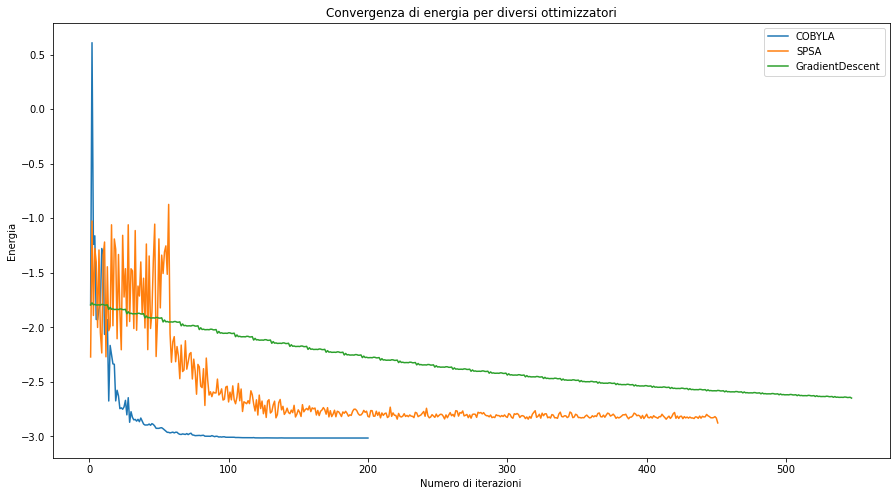

In [24]:
pylab.rcParams['figure.figsize'] = (15, 8)
for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_nfev_qH[0][i], converge_energy_qH[0][i], label=type(optimizer).__name__)
pylab.xlabel('Numero di iterazioni')
pylab.ylabel('Energia')
pylab.title('Convergenza di energia per diversi ottimizzatori')
pylab.legend(loc='upper right');

Ora vediamo quale ottimizzatore converge più velocemente rispetto al valore trovato classicamente (in percentuale):

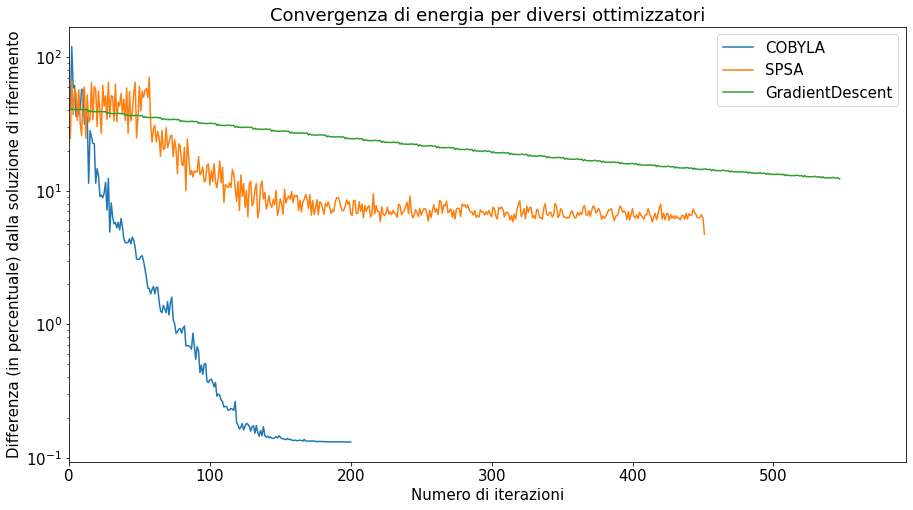

In [25]:
pylab.rcParams['figure.figsize'] = (15, 8)
pylab.rcParams.update({'font.size': 15})  # fontsize of the figure title
for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_nfev_qH[0][i], abs(100*(cGSEigE[0] - converge_energy_qH[0][i])/cGSEigE[0]), label=type(optimizer).__name__)
    pylab.xlim([0, 594])
pylab.xlabel('Numero di iterazioni')
pylab.ylabel('Differenza (in percentuale) dalla soluzione di riferimento')
pylab.title('Convergenza di energia per diversi ottimizzatori')
pylab.yscale('log')
pylab.legend(loc='upper right');

In [26]:
Natoms = 8 #Cambiamo numero atomi
J = 1./Natoms # 1/Natoms
gy = 2
gz = 0
B = [0.95]

In [27]:
cH = []
for k in B:
    cH.append(Spin_Magnet_Hamilton_class(Natoms,J,gy,gz,k))
    
cGSEigE, EigE = class_par_H_diagonalizer(cH)

In [28]:
qH = [Spin_Magnet_Hamilton_quant(Natoms,J,gy,gz,B[0])]

In [29]:
ansatz = EfficientSU2(Natoms, reps=1, entanglement='linear', insert_barriers=True) 
ansatz.decompose().draw('mpl', style='iqx')
np.random.seed(10)  # seed for reproducibility
initial_point = np.random.random(ansatz.num_parameters)

optimizers = [COBYLA(maxiter=200), SPSA(maxiter=200), GradientDescent(maxiter=42)]    #Scegliamo gli ottimizzatori
#Inizializzo array dei valori degli ottimizzatori
converge_nfev_qH = [np.empty([len(optimizers)], dtype=object) for z in range(len(qH))]   #Lista di ndarray, ciascuno per ogni B
converge_parameters_qH = [np.empty([len(optimizers)], dtype=object) for z in range(len(qH))]
converge_energy_qH = [np.empty([len(optimizers)], dtype=object) for z in range(len(qH))]
converge_stddev_qH = [np.empty([len(optimizers)], dtype=object) for z in range(len(qH))]




optimizer_benchmark_noiseless(qH)

'Completato.'

Energia calcolata da ogni ottimizzatore ad ogni step dell'iterazione:

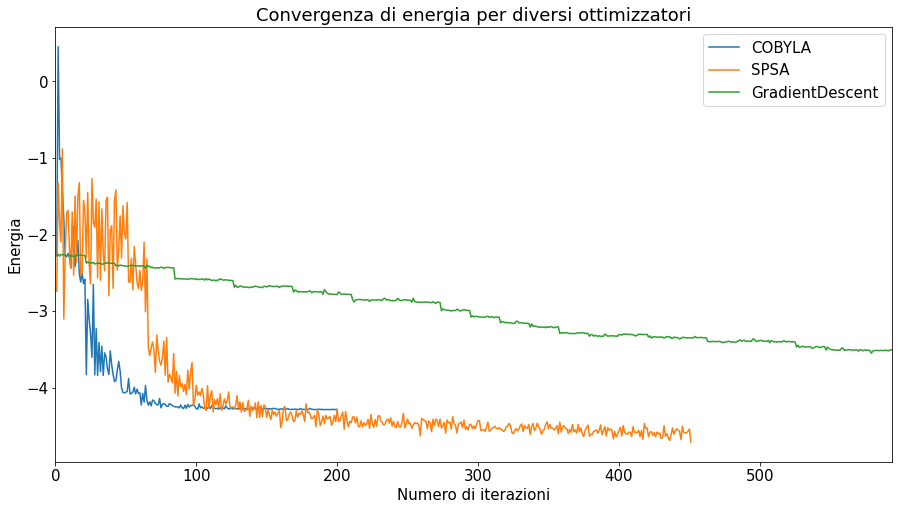

In [48]:
pylab.rcParams['figure.figsize'] = (15, 8)
for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_nfev_qH[0][i], converge_energy_qH[0][i], label=type(optimizer).__name__)
    pylab.xlim([0, 594])
pylab.xlabel('Numero di iterazioni')
pylab.ylabel('Energia')
pylab.title('Convergenza di energia per diversi ottimizzatori')
pylab.legend(loc='upper right');

Ora vediamo quale ottimizzatore converge più velocemente rispetto al valore trovato classicamente (in percentuale):

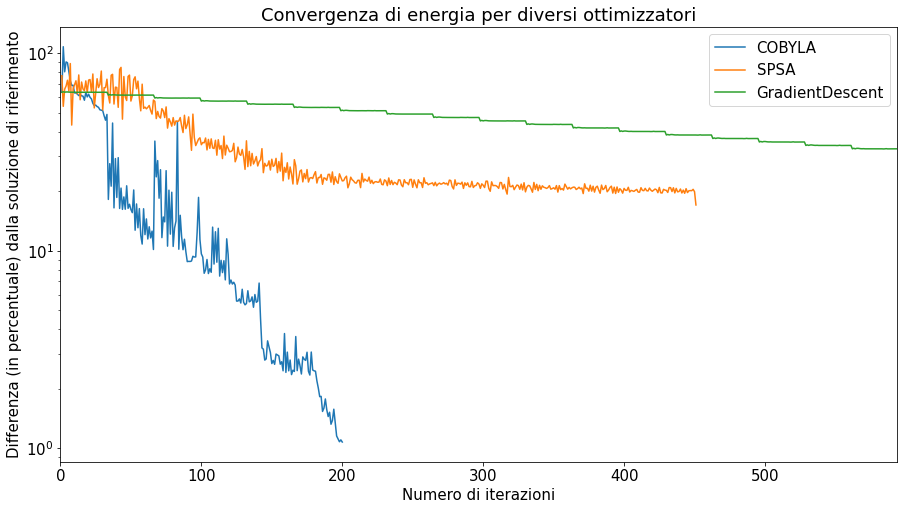

In [31]:
pylab.rcParams['figure.figsize'] = (15, 8)
pylab.rcParams.update({'font.size': 15})  # fontsize of the figure title
for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_nfev_qH[0][i], abs(100*(cGSEigE[0] - converge_energy_qH[0][i])/cGSEigE[0]), label=type(optimizer).__name__)
    pylab.xlim([0, 594])
pylab.xlabel('Numero di iterazioni')
pylab.ylabel('Differenza (in percentuale) dalla soluzione di riferimento')
pylab.title('Convergenza di energia per diversi ottimizzatori')
pylab.yscale('log')
pylab.legend(loc='upper right');

Da 3 a 8 atomi tutti e 3 gli ottimizzatori peggiorano le performance di $\approx 10 \%$.

### Confronto con rumore

Analizziamo la convergenza dei diversi ottimizzatori nel caso del simulatore senza rumore per 3 qubit e 5 qubit, per $B=0$, il caso in cui ci aspettiamo massimo entanglement:

In [32]:
Natoms = 3 #Cambiamo numero atomi
J = 1./Natoms # 1/Natoms
gy = 2
gz = 0
B = [0.95]

In [33]:
cH = []
for k in B:
    cH.append(Spin_Magnet_Hamilton_class(Natoms,J,gy,gz,k))
    
cGSEigE, EigE = class_par_H_diagonalizer(cH)

In [34]:
qH = [Spin_Magnet_Hamilton_quant(Natoms,J,gy,gz,B[0])]

In [35]:
from IPython.display import display as ipd_display, clear_output as ipd_clear
import numpy as np
import pylab


#from qiskit.providers.basicaer import QasmSimulatorPy                       # local simulator
from qiskit import Aer                                               #Uso statevector perché più veloce, però non ha errori, altrimenti usa qasm_simulator
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA, SPSA, GradientDescent      #Importo gli ottimizzatori

# Ansatz
ansatz = EfficientSU2(Natoms, reps=1, entanglement='linear', insert_barriers=True) 
ansatz.decompose().draw('mpl', style='iqx')
np.random.seed(10)  # seed for reproducibility
initial_point = np.random.random(ansatz.num_parameters)

optimizers = [COBYLA(maxiter=200), SPSA(maxiter=200), GradientDescent(maxiter=42)]    #Scegliamo gli ottimizzatori

#Inizializzo array dei valori degli ottimizzatori
converge_nfev_qH = [np.empty([len(optimizers)], dtype=object) for z in range(len(qH))]   #Lista di ndarray, ciascuno per ogni B
converge_parameters_qH = [np.empty([len(optimizers)], dtype=object) for z in range(len(qH))]
converge_energy_qH = [np.empty([len(optimizers)], dtype=object) for z in range(len(qH))]
converge_stddev_qH = [np.empty([len(optimizers)], dtype=object) for z in range(len(qH))]
    

def optimizer_benchmark_noisy(qH):


    qGSEigE = []    #Valori da mandare nella funzione per i grafici al variare di B
    meanerr = []  

    for j in range(len(qH)):

        for i, optimizer in enumerate(optimizers):

            ipd_clear(wait=True)
            ipd_display("%da iterazione di %d"%(j+1,len(qH)))
            ipd_display('Optimizer: {}        ({} di {})'.format(type(optimizer).__name__,i+1,len(optimizers)))#, end='')
            #print('\rOptimizer: {}        ({} di {})'.format(type(optimizer).__name__,i+1,len(optimizers)))#, end='')

            #Reset dei valori di callback
            global intermediate_info
            intermediate_info = {
                'nfev': [],
                'parameters': [],
                'energy': [],
                'stddev': []
            }

            backend = Aer.get_backend('aer_simulator')
            
            #Prendo i modelli per la simulazione con rumore da FakeVigo
            device = QasmSimulator.from_backend(FakeVigo())

            coupling_map = device.configuration().coupling_map
            noise_model = NoiseModel.from_backend(device)
            basis_gates = noise_model.basis_gates

            seed = 170
            iterations = 125
            algorithm_globals.random_seed = seed

            quantum_instance = QuantumInstance(backend,
                                               noise_model=noise_model,
                                               basis_gates=basis_gates,
                                               seed_simulator=seed,
                                               seed_transpiler=seed,
                                               coupling_map=coupling_map)
            
            vqe = VQE(ansatz=ansatz,
                 optimizer=optimizer,
                 initial_point=initial_point,
                 quantum_instance=quantum_instance,
                 callback=callback)

            result = vqe.compute_minimum_eigenvalue(operator=qH[j])
            converge_nfev_qH[j][i] = intermediate_info['nfev']
            converge_parameters_qH[j][i] = intermediate_info['parameters']
            converge_energy_qH[j][i] = intermediate_info['energy']
            converge_stddev_qH[j][i] = intermediate_info['stddev']

        qGSEigE.append(converge_energy_qH[j][0][-1])                           #Scegliamo di quale ottimizzatore mostrare i
        meanerr.append(converge_stddev_qH[j][0][-1])                           #risultati(0 sta per COBYLA) 
    
    ipd_clear(wait=True)
    ipd_display("Completato.")
    
optimizer_benchmark_noisy(qH)

'Completato.'

Energia calcolata da ogni ottimizzatore ad ogni step dell'iterazione:

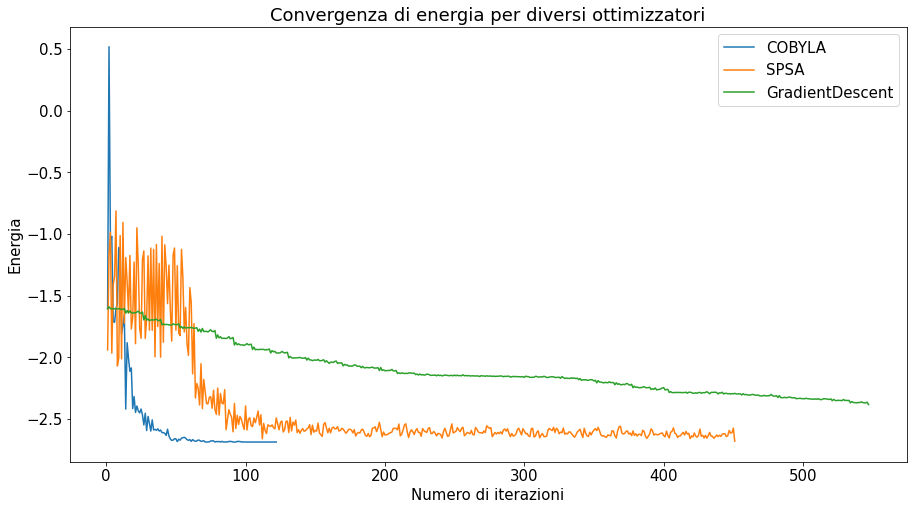

In [36]:
pylab.rcParams['figure.figsize'] = (15, 8)
for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_nfev_qH[0][i], converge_energy_qH[0][i], label=type(optimizer).__name__)
#print(converge_energy_qH[B_fiss][-1])
pylab.xlabel('Numero di iterazioni')
pylab.ylabel('Energia')
pylab.title('Convergenza di energia per diversi ottimizzatori')
pylab.legend(loc='upper right');

Ora vediamo quale ottimizzatore converge più velocemente rispetto al valore trovato classicamente (in percentuale):

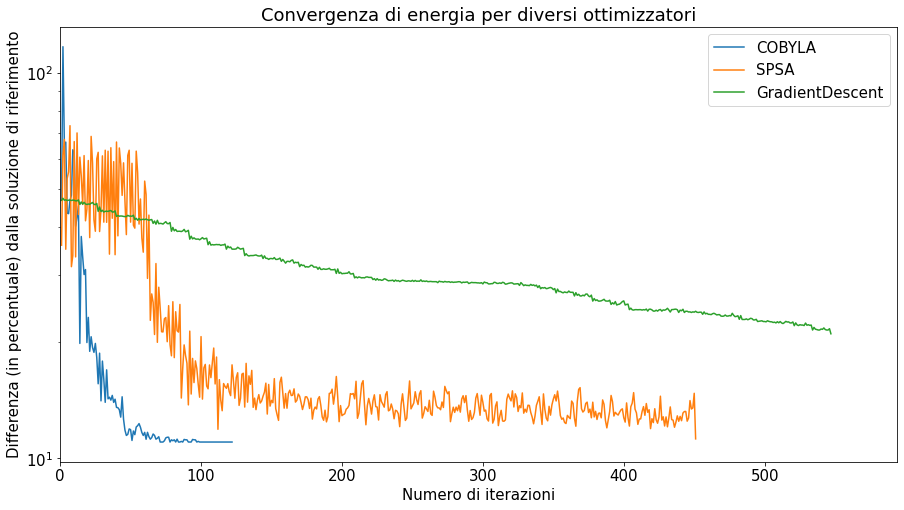

In [37]:
pylab.rcParams['figure.figsize'] = (15, 8)
pylab.rcParams.update({'font.size': 15})  # fontsize of the figure title
for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_nfev_qH[0][i], abs(100*(cGSEigE[0] - converge_energy_qH[0][i])/cGSEigE[0]), label=type(optimizer).__name__)
    pylab.xlim([0, 594])
pylab.xlabel('Numero di iterazioni')
pylab.ylabel('Differenza (in percentuale) dalla soluzione di riferimento')
pylab.title('Convergenza di energia per diversi ottimizzatori')
pylab.yscale('log')
pylab.legend(loc='upper right');

-SPSA e GD non vengono influenzati in modo invasivo dal rumore.

-COBYLA peggiora.

In [38]:
Natoms = 5 #Cambiamo numero atomi
J = 1./Natoms # 1/Natoms
gy = 2
gz = 0
B = [0.95]

In [39]:
cH = []
for k in B:
    cH.append(Spin_Magnet_Hamilton_class(Natoms,J,gy,gz,k))
    
cGSEigE, EigE = class_par_H_diagonalizer(cH)

In [40]:
qH = [Spin_Magnet_Hamilton_quant(Natoms,J,gy,gz,B[0])]

In [42]:
ansatz = EfficientSU2(Natoms, reps=1, entanglement='linear', insert_barriers=True) 
ansatz.decompose().draw('mpl', style='iqx')
np.random.seed(10)  # seed for reproducibility
initial_point = np.random.random(ansatz.num_parameters)

optimizers = [COBYLA(maxiter=200), SPSA(maxiter=200), GradientDescent(maxiter=42)]    #Scegliamo gli ottimizzatori

#Inizializzo array dei valori degli ottimizzatori
converge_nfev_qH = [np.empty([len(optimizers)], dtype=object) for z in range(len(qH))]   #Lista di ndarray, ciascuno per ogni B
converge_parameters_qH = [np.empty([len(optimizers)], dtype=object) for z in range(len(qH))]
converge_energy_qH = [np.empty([len(optimizers)], dtype=object) for z in range(len(qH))]
converge_stddev_qH = [np.empty([len(optimizers)], dtype=object) for z in range(len(qH))]
    




optimizer_benchmark_noisy(qH)

'Completato.'

Energia calcolata da ogni ottimizzatore ad ogni step dell'iterazione:

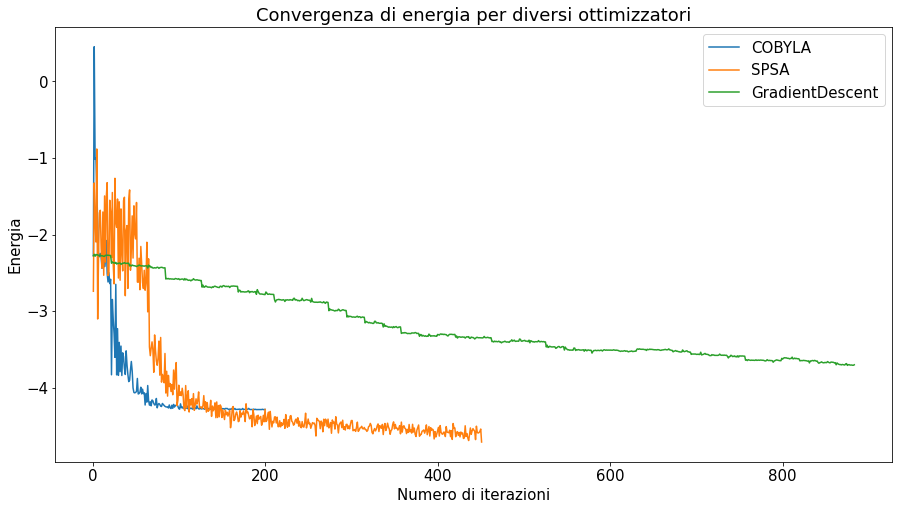

In [43]:
pylab.rcParams['figure.figsize'] = (15, 8)
for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_nfev_qH[0][i], converge_energy_qH[0][i], label=type(optimizer).__name__)
pylab.xlabel('Numero di iterazioni')
pylab.ylabel('Energia')
pylab.title('Convergenza di energia per diversi ottimizzatori')
pylab.legend(loc='upper right');

Ora vediamo quale ottimizzatore converge più velocemente rispetto al valore trovato classicamente (in percentuale):

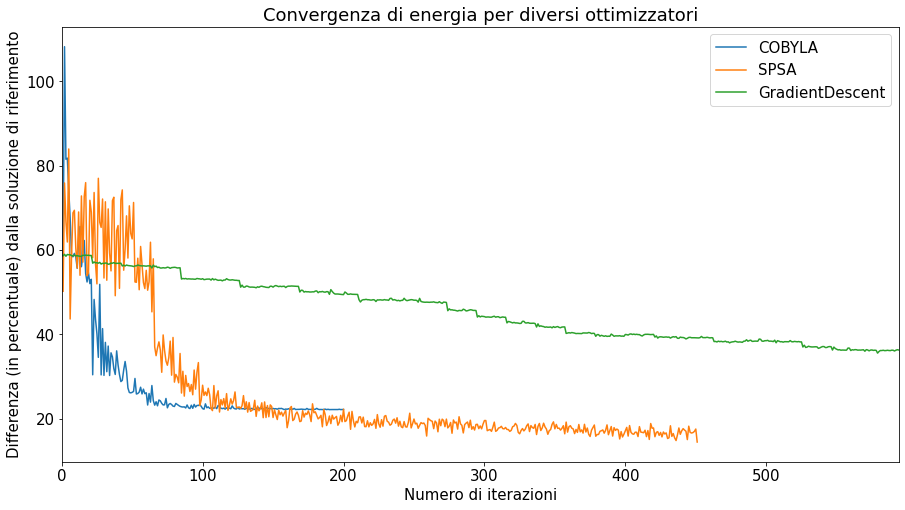

In [47]:
pylab.rcParams['figure.figsize'] = (15, 8)
pylab.rcParams.update({'font.size': 15})  # fontsize of the figure title
for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_nfev_qH[0][i], abs(100*(cGSEigE[0] - converge_energy_qH[0][i])/cGSEigE[0]), label=type(optimizer).__name__)
    pylab.xlim([0, 594])
#    pylab.ylim([0, 30])   
pylab.xlabel('Numero di iterazioni')
pylab.ylabel('Differenza (in percentuale) dalla soluzione di riferimento')
pylab.title('Convergenza di energia per diversi ottimizzatori')
#pylab.yscale('log')
pylab.legend(loc='upper right');

-SPSA il più performante

-Rumore incide sulle pretazioni di COBYLA, anche se rimane comunque il più rapido nel convergere. 

## Confronto fra ansätze

##### Considerazioni specifiche:
- `EfficientSU2`:

    1. approccio euristico
    2. produce un ansatz generico efficiente in termini di hardware
    
    
- Ansatz _physically-motivated_:

    1. richiede lo studio delle simmetrie del sistema: cerchiamo quantità conservate: $\hat A: \left[\hat H,\hat A\right] = 0$
    2. ristringiamo lo spazio di Hilbert in cui cercare
    3. produce un ansatz con un circuito più lungo ma che lavora su un numero di parametri più piccolo

##### Ansatz _physically-motivated_ _Hamiltonian Insipred_:

Dobbiamo costruire un operatore unitario parametrico che conservi $\hat A$, utilizziamo l'approccio hamiltoniano:
- $\hat U(\theta) = \exp\left(i\theta\hat A\right)$ è un operatore unitario che costringe il VQE a campionare l'autospazio di $\hat A$ per l'autovalore corrispondente a $\psi_\text{0}$
- Si trova gate di 2 qubit $W^{(ij)}$ equivalente a $\hat U(\theta)$
- Si costruisce un $\psi_\text{0}$ con $\lambda_A^0=\lambda_A^{min}$
- Costruiamo il circuito di ansatz applicando $W^{(ij)}$ ad ogni coppia di qubit

Nel nostro caso, per esempio, si trova che $\left[\hat H, \hat S_z^i \hat S_z^j\right] = 0$.

In [66]:
from qiskit.circuit.gate import Gate
from qiskit.quantum_info import Operator
from qiskit.extensions import HamiltonianGate
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.compiler import transpile
from qiskit.transpiler import PassManager
from qiskit.circuit.quantumcircuit import QuantumCircuit
import pylab
from qiskit.circuit import Parameter

### Applicazione nel caso 4 qubit
Definiamo il _physically-motivated_ ansatz:

In [72]:
#Ansatz fisicamente motivato

def PMA_ansatz(Natoms,Spin):

    #definiamo il gate Wij di 2 qubit, hamiltonian inspired
    
    PMA_ansatz=QuantumCircuit(Natoms)
    PMA_ansatz.x(range(Natoms))
    
    #Parte di inizializzazione dello stato iniziale
    #Prestiamo attenzione a costruire uno stato con il corretto spin
    
    for i in range(Natoms-2):
        if i%2 ==0:
            PMA_ansatz.h(i)
        else:
            PMA_ansatz.cx(i-1,i)
    if Natoms%4 == 0:
        if Spin==0:
            PMA_ansatz.h(Natoms-2)
            PMA_ansatz.cx(Natoms-2,Natoms-1)
    else:
        if Spin==1:
            PMA_ansatz.h(Natoms-2)
            PMA_ansatz.cx(Natoms-2,Natoms-1)
            
    #Assembliamo le coppie di gate Wij per costruire l'ansatz
    
    for i in range(Natoms):
        
        for j in range(i+1):
            if j != i: 
                theta= Parameter(str(i)+str(j))
                Wgatecirc=QuantumCircuit(2) 
                Wgatecirc.cx(0, 1)
                Wgatecirc.rz(theta,1)
                Wgatecirc.cx(0, 1)
                Wgate=Wgatecirc.to_gate()

                PMA_ansatz.append(Wgate,[i,j])
    return(PMA_ansatz)


Applichiamo l'ansatz e cerchiamo il ground state per 10 atomi:

In [80]:
Natoms = 10 #l'entanglement è corretto per un numero pari di qubits
J = 1/Natoms
gy = 2
gz = 0
B = 2
Spin=1 #1 per spin negativo, 0 per spin positivo
ham = Spin_Magnet_Hamilton_quant(Natoms,J,gy,gz,B)

In [81]:
#Applichiamo l'ansatz
ansatz = QuantumCircuit(Natoms)
ansatz.append((PMA_ansatz(Natoms,Spin).to_gate()),range(Natoms))
initial_point = np.random.random(ansatz.num_parameters)
#ansatz.decompose().decompose().draw('mpl', style='iqx') #disegniamo il circuito

In [82]:
#Scelta ottimizzatore
from qiskit.algorithms.optimizers import COBYLA
maxiter=200 #Numero di iterazioni massime
optimizer = COBYLA(maxiter=50, tol=0.001, rhobeg=1.0)

In [83]:
#Reset delle info intermedie
intermediate_info = {
    'nfev': [],
    'parameters': [],
    'energy': [],
    'stddev': []
}
converge_nfev_qH=[]
converge_parameters_qH=[]
converge_energy_qH=[]
converge_stddev_qH=[]

In [84]:
local_vqe = VQE(ansatz=ansatz,
                optimizer=optimizer,
                initial_point=initial_point,
                quantum_instance=StatevectorSimulatorPy(),
                callback=callback)

local_result = local_vqe.compute_minimum_eigenvalue(operator=ham)
converge_nfev_qH.append(intermediate_info['nfev'])
converge_parameters_qH.append(intermediate_info['parameters'])
converge_energy_qH.append(intermediate_info['energy'])
converge_stddev_qH.append(intermediate_info['stddev'])

/home/heron/anaconda3/lib/python3.8/site-packages/qiskit/utils/run_circuits.py:695: UserWarning: Option max_credits is not used by this backend
  return backend.run(circuits, **run_kwargs)


Text(0.5, 1.0, 'Convergenza di energia')

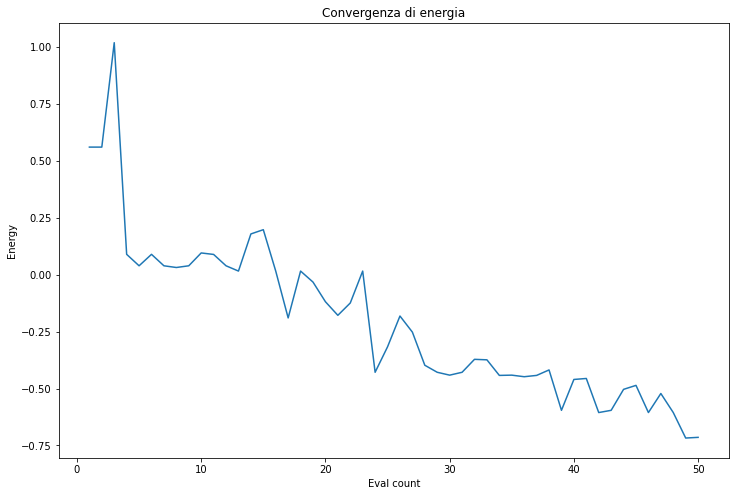

In [92]:
pylab.rcParams['figure.figsize'] = (12, 8)
pylab.plot(converge_nfev_qH[0],converge_energy_qH[0])
#print(converge_energy_qH[B_fiss][-1])
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Convergenza di energia')


##### Considerazioni ansatz
Il prossimo step è l'ottimizzazione dell'ansatz:
- Costruire un circuito più efficiente
- Allargare lo spazio di stati raggiungibili
- Testare con un maggior numero di qubits


#### Bibliografia
[1] H. J. Lipkin, N. Meshkov, and A. J. Glick, Nucl. Phys. 62 , 188 (1965). <br>
[2] F. Pan and J. P. Draayer, Phys. Lett. B 451 , 1 (1999). <br>
[3] P. Ribeiro, J. Vidal, and R. Mosseri, Phys. Rev. E 78 , 021106 (2008) <br>
[4] W. Lavrijsen, A. Tudor, J. Müller, C. Iancu and W. de Jong, Classical Op-
timizers for Noisy Intermediate-Scale Quantum Devices , 2020 IEEE In-
ternational Conference on Quantum Computing and Engineering (QCE),
2020, pp. 267-277, doi: 10.1109/QCE49297.2020.00041. <br>
[5] Crippa, L.;Tacchino, F.; Chizzini, M.; Aita, A.; Grossi, M.; Chiesa, A.;
Santini, P.; Tavernelli, I.; Carretta, S.; Simulating Static and Dynamic
Properties of Magnetic Molecules with Prototype Quantum Computers .
Magnetochemistry 2021 , 7, 117. 12 August 2021. <br>
[6] https://developer.ibm.com/blogs/quantum-computing-qubit-vqe-variational-quantum-eigensolver/ <br>
[7] https://qiskit.org/textbook/ch-applications/vqe-molecules.html